# Installs and Imports

In [2]:
import torch

torch.set_printoptions(threshold=torch.inf)

import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import os
import multiprocessing as mp

if mp.get_start_method() != 'spawn':
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass

import optuna

from PIL import Image

from torchvision.transforms import transforms

from sklearn.model_selection import train_test_split

from torchinfo import summary

import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

from pathlib import Path

from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from utils import train_model, PrintMetricsCallback, denormalize, sample_dataset, process_experiment_logs

# Data Loaders

In [3]:
def load_and_split_data(source_dir, csv_file_name, sample_size, proportions, seed=42):
    # Ensure the proportions sum to 1
    if not 0.99 < sum(proportions) < 1.01:
        raise ValueError("Proportions must sum to 1")

    # Load the CSV file
    source_dir = Path(source_dir)
    csv_path = csv_file_name
    df = pd.read_csv(csv_path)

    # Sample the DataFrame
    sampled_df = df.sample(n=sample_size, random_state=seed)

    # Split the DataFrame based on the proportions provided
    if len(proportions) == 3:
        # Split into train, validation, and test sets
        prop_train, prop_valid, _ = proportions
        train_df, temp_df = train_test_split(sampled_df, train_size=prop_train, random_state=seed)
        valid_df, test_df = train_test_split(temp_df, train_size=prop_valid / (1 - prop_train), random_state=seed)
        return train_df, valid_df, test_df
    elif len(proportions) == 2:
        # Split into train and test sets (valid set is not created)
        prop_train, _ = proportions
        train_df, test_df = train_test_split(sampled_df, train_size=prop_train, random_state=seed)
        return train_df, test_df
    else:
        raise ValueError("Proportions tuple must have either two or three elements")

Defining our custom dataloader builder classes here. In the class definition the sample size of dataset and proportions of split can be changed. 

In [4]:
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform = None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.images_dir = os.path.join(root_dir, 'images')  # Folder containing images

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Construct the full path to the image
        img_name = f"{self.dataframe.iloc[idx]['id']}.tif"
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path)
        label = np.float32(self.dataframe.iloc[idx]['label'])

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_mean_std_from_dataframe(data_df, data_directory, batch_size=128, use_augmentation=True, augment_transform=transforms.Compose([])):

    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if not use_augmentation:
        temp_transform =train_transform
    else:
        temp_transform = transforms.Compose([
            augment_transform,
            train_transform
        ])  
    
    temp_dataset = CancerDataset(data_df, data_directory, temp_transform)
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)
    
    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_batches = 0
    
    for data, _ in temp_loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = torch.sqrt((channels_squared_sum / num_batches) - mean**2)
    
    original_mean = mean.tolist()
    original_std = std.tolist()
    
    print(f"Calculated mean: {original_mean}")
    print(f"Calculated std: {original_std}")
    
    return original_mean, original_std

In [6]:
def get_cancer_dataloaders(sample_size=None, batch_size=128, use_augmentation=True, use_custom_meanstd = False, augment_transform=transforms.Compose([]), mean_std=[[], []]):
    
    data_directory = 'data/datasets/histo_cropped'
    csv_file = data_directory+'/labels.csv'
    
    if sample_size is None:
        sample_size = 220025 # use None for all data
    else:
        sample_size = sample_size
        
    proportions = (0.8, 0.1, 0.1)  # For a three-way split
    random_seed = 31
    
    train_df, valid_df, test_df = load_and_split_data(data_directory, csv_file, sample_size, proportions, random_seed)
        
    if not use_custom_meanstd:
        mean, std = get_mean_std_from_dataframe(train_df, data_directory, batch_size=batch_size, use_augmentation=use_augmentation, augment_transform=augment_transform)
    elif use_custom_meanstd:
        mean = mean_std[0]
        std = mean_std[1]
    
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    
    if not use_augmentation:
        train_transform = transform
    else:
        train_transform = transforms.Compose([
            augment_transform,
            transform
        ])
    
    train_set = CancerDataset(train_df, data_directory, train_transform)
    valid_set = CancerDataset(valid_df, data_directory, transform)
    test_set = CancerDataset(test_df, data_directory, transform)
    
    print(f"Sampled Training set size: {len(train_set)}")
    print(f"Sampled Validation set size: {len(valid_set)}")
    print(f"Sampled Test set size: {len(test_set)}")

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

In [7]:
class BasicLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes, lr=0.001):

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()
        self.lr = lr

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.001)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.95, patience=4, verbose=True)
        # return [optimizer], [{'scheduler': scheduler, 'monitor': 'valid_loss'}]
        return [optimizer]


In [8]:
def plot_model_performance(df):

    df2 = pd.melt(df,id_vars=["exp_name","epoch"],value_vars = ["train_loss","valid_loss"],var_name="Mode",value_name="Loss").replace(
        {"train_loss":"train","valid_loss":"valid"})
    df = pd.melt(df,id_vars=["exp_name","epoch"],value_vars = ["train_acc","valid_acc"],var_name="Mode",value_name="Accuracy").replace(
        {"train_acc":"train","valid_acc":"valid"})
    df["Loss"]=df2["Loss"]

    # Plot training and validation loss
    g = sns.FacetGrid(df,col="exp_name",hue="Mode")
    g.map(sns.lineplot,"epoch","Loss")
    g.add_legend()
    plt.tight_layout()
    plt.show()

    # Plot training and validation accuracy
    g = sns.FacetGrid(df,col="exp_name",hue="Mode")
    g.map(sns.lineplot,"epoch","Accuracy")
    g.add_legend()
    plt.tight_layout()
    plt.show()

In [9]:
def run_experiment(light_model, root_save_dir, exper_name, train_dl, valid_dl, max_epochs=10, verbose = 1):
    model_dir = root_save_dir + '/' + exper_name + '/Models'
    csv_logs_dir = root_save_dir + '/' + exper_name + '/CSVLogs'

    # define our callbacks
    print_cb = PrintMetricsCallback(print_epoch=1)
    model_save_cb = ModelCheckpoint(
        dirpath = model_dir,
        filename = exper_name+'-{epoch:02d}-{valid_acc:.2f}',
        monitor='valid_acc',
        mode='max')
    early_cb = EarlyStopping('valid_acc', min_delta = 0.000,
                             patience = 5, mode = 'max', verbose=True)

    if verbose > 0:
        #all_cbs = [print_cb, model_save_cb, early_cb]
        all_cbs = [print_cb, model_save_cb]
    else:
        all_cbs = [model_save_cb, early_cb]

    # setup the trainer
    logger = CSVLogger(csv_logs_dir,name="model") # don't change name = "model"

    trainer = pl.Trainer(max_epochs=max_epochs,
                         enable_progress_bar=False,
                         callbacks=all_cbs,
                         num_sanity_val_steps=0,
                         val_check_interval=1.0,
                         logger=logger,
                          )

    # train the model!
    trainer.fit(light_model, train_dl, valid_dl)

    # process the logs
    df = process_experiment_logs(csv_logs_dir, exper_name)

    return df, trainer

def plot_valid_acc(df):
    sns.lineplot(data=df, x='epoch',y='valid_acc',hue='exp_name')
    plt.title('Validation Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()

In [10]:
from sklearn.metrics import accuracy_score

def predict_accuracy(trainer, model, test_dl):
    model.eval()
    # Make predictions
    with torch.no_grad():
        
        predictions = trainer.predict(model, dataloaders=test_dl)
        preds = torch.cat(predictions)
        targets = torch.cat([labels for _, labels in test_dl])  # Assuming test_dl yields (data, target)

        acc = accuracy_score(targets.numpy(), preds.numpy())
                             
    print(f'Test Accuracy: {acc * 100:.2f}%')

In [11]:
W, H = 32, 32
#How many values are in the input? We use this to help determine the size of subsequent layers
D = W*H # total pixels
#Hidden layer size
n = 256
#Number of hidden layers
n_layers = 3
#How many channels are in the input?
C = 3
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 2

# Baseline Model

Here I define and train a simple baseline model to compare other models against. No data augmentation or batch nomalization was added to observe the performance of a barebones CNN architectue.

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 32, 32]          [128, 2]                  --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    └─Conv2d: 2-1                       [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    └─LeakyReLU: 2-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
├─MaxPool2d: 1-2                         [128, 32, 32, 32]         [128, 32, 16, 16]         --
├─Sequential: 1-3                        [128, 32, 16, 16]         [128, 64, 16, 16]         --
│    └─Conv2d: 2-3                       [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    └─LeakyReLU: 2-4                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [128, 64, 16, 16]         [128, 64, 8, 8]           --
├─Sequential: 1-5             

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/hkonduru/Documents/MTH 480/CV Project/CancerDataset/Baseline_CNN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 109 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)


Calculated mean: [0.7024408578872681, 0.5446928143501282, 0.6955959796905518]
Calculated std: [0.23786640167236328, 0.28066331148147583, 0.2154562771320343]
Sampled Training set size: 36000
Sampled Validation set size: 4500
Sampled Test set size: 4500
Beginning training for at most 35 epochs


/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.4455, valid_acc: 0.7969, train_loss: 0.5006, train_acc: 0.7605, LR: 1.000000e-03
Epoch 2 Metrics: valid_loss: 0.4701, valid_acc: 0.7878, train_loss: 0.4517, train_acc: 0.7952, LR: 1.000000e-03
Epoch 3 Metrics: valid_loss: 0.4611, valid_acc: 0.7916, train_loss: 0.4401, train_acc: 0.8034, LR: 1.000000e-03
Epoch 4 Metrics: valid_loss: 0.4277, valid_acc: 0.8113, train_loss: 0.4224, train_acc: 0.8118, LR: 1.000000e-03
Epoch 5 Metrics: valid_loss: 0.4267, valid_acc: 0.8142, train_loss: 0.4099, train_acc: 0.8197, LR: 1.000000e-03
Epoch 6 Metrics: valid_loss: 0.4441, valid_acc: 0.8062, train_loss: 0.3977, train_acc: 0.8268, LR: 1.000000e-03
Epoch 7 Metrics: valid_loss: 0.4367, valid_acc: 0.8084, train_loss: 0.3713, train_acc: 0.8408, LR: 1.000000e-03
Epoch 8 Metrics: valid_loss: 0.4443, valid_acc: 0.8031, train_loss: 0.3498, train_acc: 0.8507, LR: 1.000000e-03
Epoch 9 Metrics: valid_loss: 0.4829, valid_acc: 0.7909, train_loss: 0.3142, train_acc: 0.8679, LR: 1.000

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 35 Metrics: valid_loss: 1.6520, valid_acc: 0.7729, train_loss: 0.0342, train_acc: 0.9887, LR: 1.000000e-03
End.  Trained for 35 epochs.


/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predictions: 
tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 

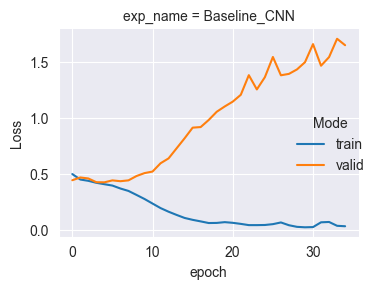

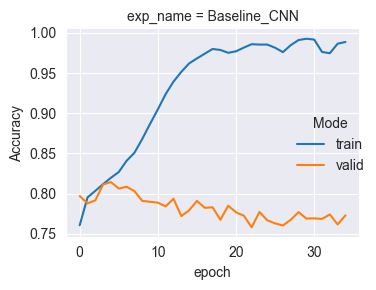

In [157]:
def cnnLayer(in_filters, out_filters=None, kernel_size=3, leak_rate=0.1):
    """
    in_filters: how many channels are coming into the layer
    out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
    kernel_size: how large the kernel should be
    """
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.LeakyReLU(leak_rate)
    )

# define architecture 
cnn_base_model = nn.Sequential(
    cnnLayer(C, n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

# set experiment parameters
exper_name = "Baseline_CNN"
root_save_dir = './CancerDataset'
learning_rate = 0.001
max_epochs = 35
batch_size = 128

device = torch.device('mps')


## Check Model for errors
summary_str = summary(cnn_base_model, input_size = (batch_size,C,H,W), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

## Get dataloaders
train_dl_base, valid_dl_base, test_dl_base = get_cancer_dataloaders(sample_size=45000, use_augmentation = False, batch_size = batch_size)

## Instantiate Lightning Model
light_model_base = BasicLightningModel(cnn_base_model, num_classes = 2, lr = learning_rate)
light_model_base.to(device)

# Train and Validate
baseline_results, trainer_base = run_experiment(light_model_base, root_save_dir, exper_name,
                                  train_dl_base, valid_dl_base,
                                  max_epochs=max_epochs , verbose=1)

# Visualize Results
plot_model_performance( pd.concat([baseline_results]))

In [185]:
predict_accuracy(trainer_base, light_model_base, test_dl_base)

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predictions: 
tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 

## Generate Splits

In [12]:
batch_size = 128

augment_transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.5, hue=0)
])

train_dl, valid_dl, test_dl = get_cancer_dataloaders(sample_size=45000, batch_size = batch_size, use_augmentation = True, use_custom_meanstd=False, augment_transform = augment_transform)

Calculated mean: [0.6022406220436096, 0.47390806674957275, 0.6000879406929016]
Calculated std: [0.3067592680454254, 0.30961474776268005, 0.2954922616481781]
Sampled Training set size: 36000
Sampled Validation set size: 4500
Sampled Test set size: 4500


In [13]:
batch_size = 128

augment_transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.5, hue=0)
])

train_dl_all, valid_dl_all, test_dl_all = get_cancer_dataloaders(sample_size=None, batch_size = batch_size, use_augmentation = True, use_custom_meanstd=False, augment_transform = augment_transform)

Calculated mean: [0.6027849912643433, 0.47438138723373413, 0.6008651852607727]
Calculated std: [0.30734536051750183, 0.3101270794868469, 0.29595351219177246]
Sampled Training set size: 176020
Sampled Validation set size: 22002
Sampled Test set size: 22003


## Data Augmentation

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/hkonduru/Documents/MTH 480/CV Project/CancerDataset/Augment_CNN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 109 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 32, 32]          [128, 2]                  --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    └─Conv2d: 2-1                       [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    └─LeakyReLU: 2-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
├─MaxPool2d: 1-2                         [128, 32, 32, 32]         [128, 32, 16, 16]         --
├─Sequential: 1-3                        [128, 32, 16, 16]         [128, 64, 16, 16]         --
│    └─Conv2d: 2-3                       [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    └─LeakyReLU: 2-4                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [128, 64, 16, 16]         [128, 64, 8, 8]           --
├─Sequential: 1-5             

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.5054, valid_acc: 0.7583, train_loss: 0.5135, train_acc: 0.7547, LR: 1.000000e-03
Epoch 2 Metrics: valid_loss: 0.4708, valid_acc: 0.7768, train_loss: 0.4711, train_acc: 0.7836, LR: 1.000000e-03
Epoch 3 Metrics: valid_loss: 0.4246, valid_acc: 0.8162, train_loss: 0.4507, train_acc: 0.7959, LR: 1.000000e-03
Epoch 4 Metrics: valid_loss: 0.4145, valid_acc: 0.8197, train_loss: 0.4396, train_acc: 0.8026, LR: 1.000000e-03
Epoch 5 Metrics: valid_loss: 0.4265, valid_acc: 0.8134, train_loss: 0.4311, train_acc: 0.8073, LR: 1.000000e-03
Epoch 6 Metrics: valid_loss: 0.4225, valid_acc: 0.8119, train_loss: 0.4245, train_acc: 0.8107, LR: 1.000000e-03
Epoch 7 Metrics: valid_loss: 0.3979, valid_acc: 0.8264, train_loss: 0.4215, train_acc: 0.8122, LR: 1.000000e-03
Epoch 8 Metrics: valid_loss: 0.3985, valid_acc: 0.8242, train_loss: 0.4200, train_acc: 0.8138, LR: 1.000000e-03
Epoch 9 Metrics: valid_loss: 0.4051, valid_acc: 0.8227, train_loss: 0.4166, train_acc: 0.8147, LR: 1.000

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 35 Metrics: valid_loss: 0.4171, valid_acc: 0.8178, train_loss: 0.3914, train_acc: 0.8288, LR: 1.000000e-03
End.  Trained for 35 epochs.


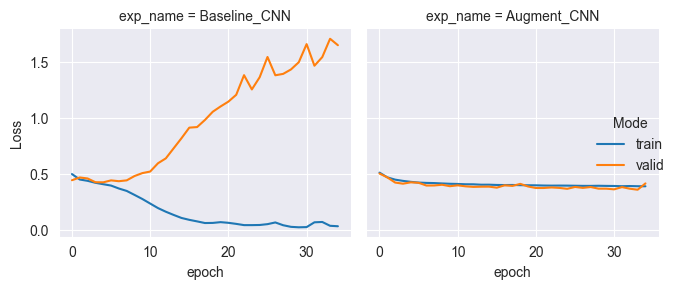

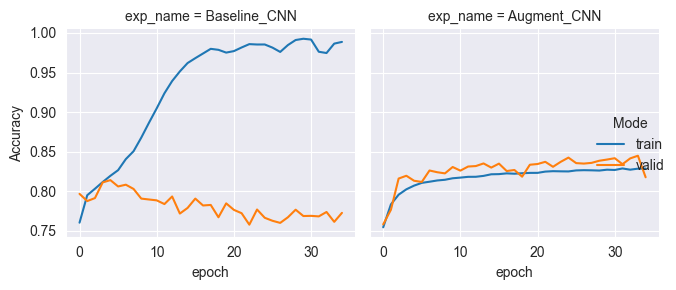

In [248]:
# define architecture 
model_augment = nn.Sequential(
    cnnLayer(C, n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

# set experiment parameters
exper_name = "Augment_CNN"
root_save_dir = './CancerDataset'
learning_rate = 0.001
max_epochs = 35
batch_size = 128

device = torch.device('mps')

## Check Model for errors
summary_str = summary(cnn_base_model, input_size = (batch_size,C,H,W), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

## Instantiate Lightning Model
light_model_aug = BasicLightningModel(model_augment, num_classes = 2, lr = learning_rate)
light_model_aug.to(device)

# Train and Validate
augment_results, trainer_aug = run_experiment(light_model_aug, root_save_dir, exper_name,
                                  train_dl_all, valid_dl_all,
                                  max_epochs=max_epochs , verbose=1)

# Visualize Results
plot_model_performance( pd.concat([baseline_results, augment_results]))

In [250]:
predict_accuracy(trainer_aug, light_model_aug, test_dl_all)

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Test Accuracy: 82.12%


# Transfer Learning

I imported the ResNet 18 architecture along with pre trained weights to train it on our dataset for a few epochs. 

In [161]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.DEFAULT
net_pretrained = resnet18(weights = weights)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/hkonduru/Documents/MTH 480/CV Project/CancerDataset/Resnet18/Models exists and is not empty.
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | ResNet             | 11.2 M
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_

Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4513, valid_acc: 0.7942, train_loss: 0.5100, train_acc: 0.7608, LR: 2.000000e-04
Epoch 2 Metrics: valid_loss: 0.4261, valid_acc: 0.8107, train_loss: 0.4607, train_acc: 0.7934, LR: 2.000000e-04
Epoch 3 Metrics: valid_loss: 0.4155, valid_acc: 0.8178, train_loss: 0.4475, train_acc: 0.8001, LR: 2.000000e-04
Epoch 4 Metrics: valid_loss: 0.3987, valid_acc: 0.8267, train_loss: 0.4346, train_acc: 0.8053, LR: 2.000000e-04
Epoch 5 Metrics: valid_loss: 0.4029, valid_acc: 0.8200, train_loss: 0.4279, train_acc: 0.8079, LR: 2.000000e-04
Epoch 6 Metrics: valid_loss: 0.4011, valid_acc: 0.8218, train_loss: 0.4208, train_acc: 0.8129, LR: 2.000000e-04
Epoch 7 Metrics: valid_loss: 0.4020, valid_acc: 0.8238, train_loss: 0.4155, train_acc: 0.8167, LR: 2.000000e-04
Epoch 8 Metrics: valid_loss: 0.3830, valid_acc: 0.8347, train_loss: 0.4074, train_acc: 0.8197, LR: 2.000000e-04
Epoch 9 Metrics: valid_loss: 0.4126, valid_acc: 0.8167, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4032, valid_acc: 0.8213, train_loss: 0.4063, train_acc: 0.8198, LR: 2.000000e-04
End.  Trained for 10 epochs.


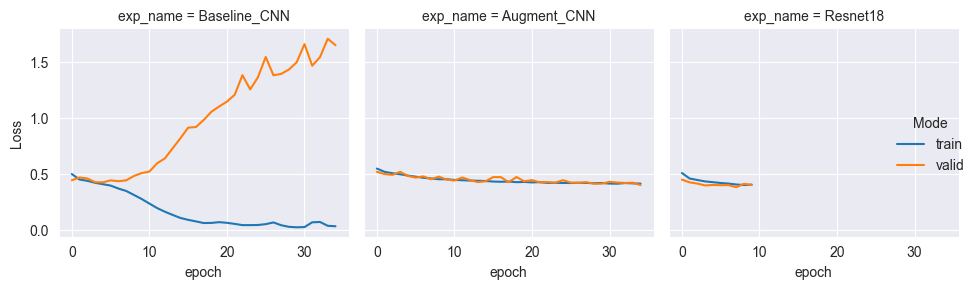

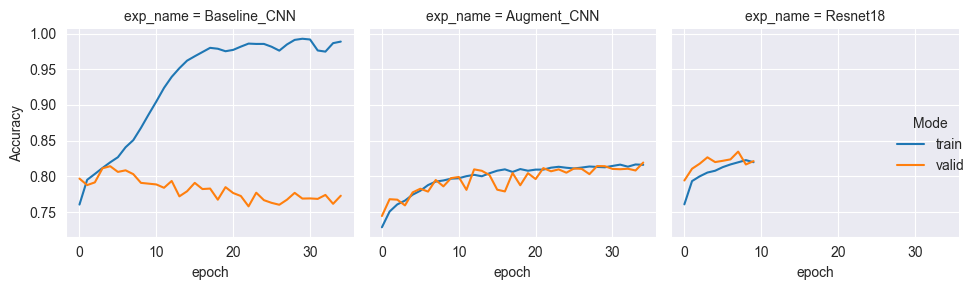

In [220]:
weights = ResNet18_Weights.DEFAULT
net_finetune = resnet18(weights = weights)
    
net_finetune.fc = nn.Linear(net_finetune.fc.in_features, classes)

model_resnet = BasicLightningModel(net_finetune, num_classes = 2, lr = 2e-4)
model_resnet.to(device)

print_cb = PrintMetricsCallback(print_epoch=1)

exper_name = "Resnet18"
root_save_dir = "./CancerDataset"

transfer_results, trainer_resnet = run_experiment(model_resnet, root_save_dir, exper_name,
                                  train_dl, valid_dl,
                                  max_epochs=10)

plot_model_performance( pd.concat([baseline_results, augment_results, transfer_results]))

In [246]:
predict_accuracy(trainer_resnet, model_resnet, test_dl)

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Test Accuracy: 83.00%


# Residual Blocks and Bottlenecks

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 32, 32]          [128, 2]                  --
├─ResidualBottleNeck: 1-1                [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    └─Sequential: 2-1                   [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         128
│    │    └─BatchNorm2d: 3-2             [128, 32, 32, 32]         [128, 32, 32, 32]         64
│    └─Sequential: 2-2                   [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    │    └─BatchNorm2d: 3-3             [128, 3, 32, 32]          [128, 3, 32, 32]          6
│    │    └─ReLU: 3-4                    [128, 3, 32, 32]          [128, 3, 32, 32]          --
│    │    └─Conv2d: 3-5                  [128, 3, 32, 32]          [128, 8, 32, 32]          32
│    │    └─BatchNorm2d: 3-6       

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/hkonduru/Documents/MTH 480/CV Project/CancerDataset/ResidualBottleNeck/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 35 epochs


/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.5376, valid_acc: 0.7104, train_loss: 0.5969, train_acc: 0.7233, LR: 1.000000e-03
Epoch 2 Metrics: valid_loss: 0.4654, valid_acc: 0.7884, train_loss: 0.5336, train_acc: 0.7524, LR: 1.000000e-03
Epoch 3 Metrics: valid_loss: 0.4538, valid_acc: 0.8111, train_loss: 0.4894, train_acc: 0.7793, LR: 1.000000e-03
Epoch 4 Metrics: valid_loss: 0.4804, valid_acc: 0.7782, train_loss: 0.4826, train_acc: 0.7879, LR: 1.000000e-03
Epoch 5 Metrics: valid_loss: 0.4053, valid_acc: 0.8180, train_loss: 0.4584, train_acc: 0.7988, LR: 1.000000e-03
Epoch 6 Metrics: valid_loss: 0.4771, valid_acc: 0.7778, train_loss: 0.4519, train_acc: 0.7988, LR: 1.000000e-03
Epoch 7 Metrics: valid_loss: 0.4194, valid_acc: 0.8140, train_loss: 0.4429, train_acc: 0.8044, LR: 1.000000e-03
Epoch 8 Metrics: valid_loss: 0.4011, valid_acc: 0.8227, train_loss: 0.4342, train_acc: 0.8076, LR: 1.000000e-03
Epoch 9 Metrics: valid_loss: 0.3905, valid_acc: 0.8244, train_loss: 0.4327, train_acc: 0.8093, LR: 1.000

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 35 Metrics: valid_loss: 0.3619, valid_acc: 0.8411, train_loss: 0.3825, train_acc: 0.8342, LR: 1.000000e-03
End.  Trained for 35 epochs.


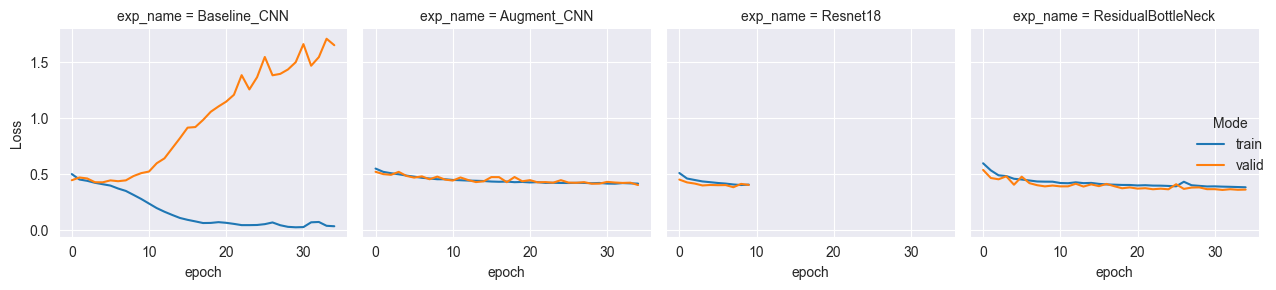

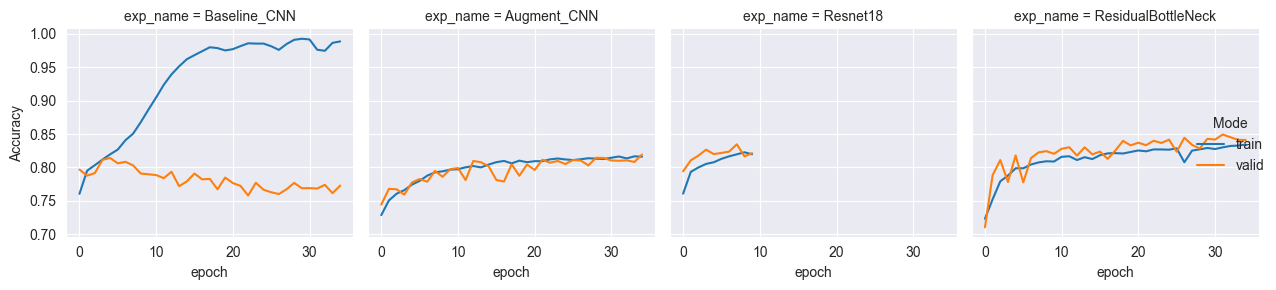

In [240]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        """
        channels: how many channels are in the input/output to this layer
        kernel_size: how large of a filter should we use
        leak_rate: paramter for the LeakyReLU activation function
        """
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return x + self.F(x)
    
    
    
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue. 
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.F = nn.Sequential(
            #Compress down
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
           
            #Normal layer doing a full conv
            nn.BatchNorm2d(bottleneck),
            nn.ReLU(),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            nn.BatchNorm2d(bottleneck),
            nn.ReLU(),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            #Expand back up
            nn.BatchNorm2d(bottleneck),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        # shortcut(x) plays the role of "x", do as little work as possible to keep the tensor shapes the same.
        return self.shortcut(x) + self.F(x) 

C = 3

dropout_rate = 0.2

residual_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(n_filters),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(n_filters, 2*n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(2*n_filters),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(2*n_filters, 4*n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(4*n_filters),
    nn.ReLU(), 
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(4*n_filters, 8*n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(8*n_filters),
    nn.ReLU(),
    
    nn.Flatten(),
    nn.Linear(D*n_filters//8, classes),
    
)

batch_size = 128
learning_rate = 1e-3

summary_str = summary(residual_model, input_size = (batch_size,C,H,W), col_names = ["input_size", "output_size", "num_params"])
print(summary_str)

exper_name = "ResidualBottleNeck"
root_save_dir = './CancerDataset'

lightning_model_residual = BasicLightningModel(residual_model, num_classes = 2, lr = learning_rate)

residual_results, trainer_res = run_experiment(lightning_model_residual, root_save_dir, exper_name, train_dl, valid_dl, max_epochs=35)

plot_model_performance( pd.concat([baseline_results, augment_results, transfer_results, residual_results]))

In [247]:
predict_accuracy(trainer_res, lightning_model_residual, test_dl)

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Test Accuracy: 83.80%


## Residual Blocks with Learning Rate Scheduler

In [14]:
class BasicLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes, lr=0.001):

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()
        self.lr = lr

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.001)
        #optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  mode='min', factor=0.1, patience=3, verbose=True)
        return [optimizer], [{'scheduler': scheduler, 'monitor': 'valid_loss'}]
    


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 32, 32]          [128, 2]                  --
├─ResidualBottleNeck: 1-1                [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    └─Sequential: 2-1                   [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         128
│    │    └─BatchNorm2d: 3-2             [128, 32, 32, 32]         [128, 32, 32, 32]         64
│    └─Sequential: 2-2                   [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    │    └─BatchNorm2d: 3-3             [128, 3, 32, 32]          [128, 3, 32, 32]          6
│    │    └─ReLU: 3-4                    [128, 3, 32, 32]          [128, 3, 32, 32]          --
│    │    └─Conv2d: 3-5                  [128, 3, 32, 32]          [128, 8, 32, 32]          32
│    │    └─BatchNorm2d: 3-6       

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/hkonduru/Documents/MTH 480/CV Project/CancerDataset/LR_Scheduler/Models exists and is not empty.
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (

Beginning training for at most 35 epochs
Epoch 1 Metrics: valid_loss: 0.5116, valid_acc: 0.7587, train_loss: 0.6035, train_acc: 0.7262, LR: 1.000000e-03
Epoch 2 Metrics: valid_loss: 0.5682, valid_acc: 0.7618, train_loss: 0.5133, train_acc: 0.7573, LR: 1.000000e-03
Epoch 3 Metrics: valid_loss: 0.4817, valid_acc: 0.7780, train_loss: 0.4885, train_acc: 0.7764, LR: 1.000000e-03
Epoch 4 Metrics: valid_loss: 0.4407, valid_acc: 0.8049, train_loss: 0.4650, train_acc: 0.7894, LR: 1.000000e-03
Epoch 5 Metrics: valid_loss: 0.5243, valid_acc: 0.8200, train_loss: 0.4528, train_acc: 0.7981, LR: 1.000000e-03
Epoch 6 Metrics: valid_loss: 0.4071, valid_acc: 0.8200, train_loss: 0.4425, train_acc: 0.8019, LR: 1.000000e-03
Epoch 7 Metrics: valid_loss: 0.5086, valid_acc: 0.7916, train_loss: 0.4352, train_acc: 0.8050, LR: 1.000000e-03
Epoch 8 Metrics: valid_loss: 0.4382, valid_acc: 0.7962, train_loss: 0.4429, train_acc: 0.8046, LR: 1.000000e-03
Epoch 9 Metrics: valid_loss: 0.4244, valid_acc: 0.8093, train_l

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 35 Metrics: valid_loss: 0.3523, valid_acc: 0.8482, train_loss: 0.3736, train_acc: 0.8376, LR: 1.000000e-05
End.  Trained for 35 epochs.


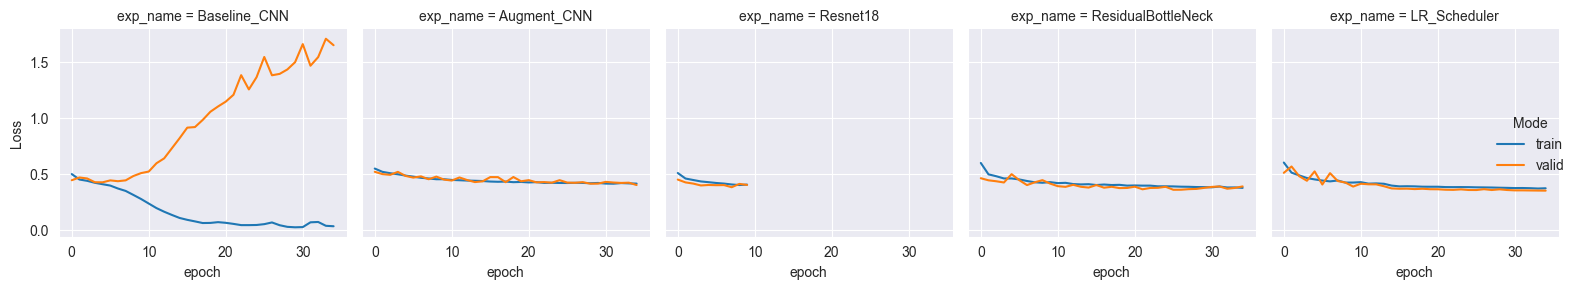

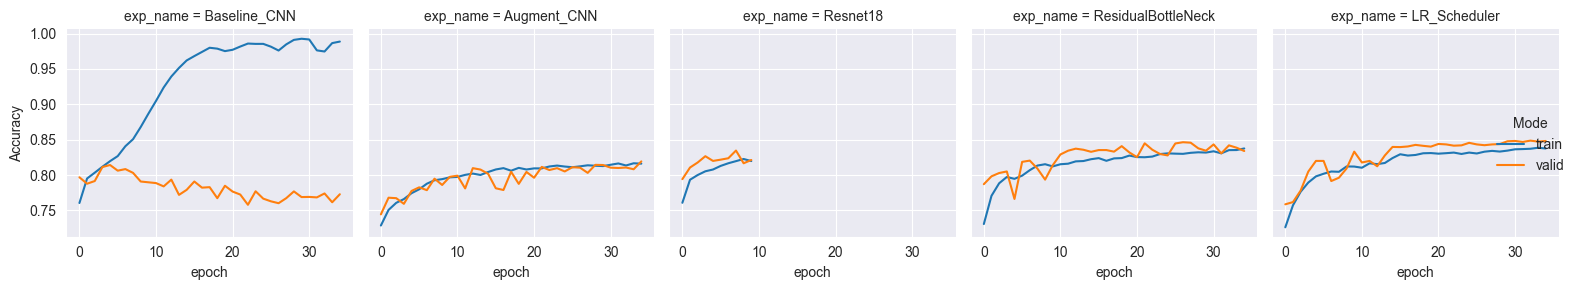

In [228]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        """
        channels: how many channels are in the input/output to this layer
        kernel_size: how large of a filter should we use
        leak_rate: paramter for the LeakyReLU activation function
        """
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return x + self.F(x)
    
    
    
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue. 
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.F = nn.Sequential(
            #Compress down
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
           
            #Normal layer doing a full conv
            nn.BatchNorm2d(bottleneck),
            nn.ReLU(),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            nn.BatchNorm2d(bottleneck),
            nn.ReLU(),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            #Expand back up
            nn.BatchNorm2d(bottleneck),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        # shortcut(x) plays the role of "x", do as little work as possible to keep the tensor shapes the same.
        return self.shortcut(x) + self.F(x) 


C = 3

dropout_rate = 0.2

lrs_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(n_filters),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(n_filters, 2*n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(2*n_filters),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(2*n_filters, 4*n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(4*n_filters),
    nn.ReLU(), 
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(4*n_filters, 8*n_filters, dropout_rate),
    nn.ReLU(),
    
    ResidualBlockE(8*n_filters),
    nn.ReLU(),
    
    nn.Flatten(),
    nn.Linear(D*n_filters//8, classes),
    
)

batch_size = 128
learning_rate = 1e-3

summary_str = summary(lrs_model, input_size = (batch_size,C,H,W), col_names = ["input_size", "output_size", "num_params"])
print(summary_str)

exper_name = "LR_Scheduler"
root_save_dir = './CancerDataset'

lightning_model_lrs = BasicLightningModel(lrs_model, num_classes = 2, lr = learning_rate)


lr_schedule_results, trainer_lrs = run_experiment(lightning_model_lrs, root_save_dir, exper_name, train_dl, valid_dl, max_epochs=35)

plot_model_performance( pd.concat([baseline_results, augment_results, transfer_results, residual_results, lr_schedule_results]))

In [229]:
predict_accuracy(trainer_lrs, lightning_model_lrs, test_dl)

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predictions: 
tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 

# Experimenting

In [237]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        """
        channels: how many channels are in the input/output to this layer
        kernel_size: how large of a filter should we use
        leak_rate: paramter for the LeakyReLU activation function
        """
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
            
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
        )
    
    def forward(self, x):
        return x + self.F(x)
    
    
    
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue. 
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.F = nn.Sequential(
            #Compress down
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
           
            #Normal layer doing a full conv
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            #Expand back up
            nn.BatchNorm2d(bottleneck),
            nn.Dropout(dropout_prob),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        # shortcut(x) plays the role of "x", do as little work as possible to keep the tensor shapes the same.
        return self.shortcut(x) + self.F(x) 
    

def objective(trial):
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1e-2)
    dropout_prob = trial.suggest_float('dropout_rate', 0.0, 1.0)
    leak_rate_bottleneck = trial.suggest_float('leak_rate_bottleneck', 0.0, 1.0)
    leak_rate_residual = trial.suggest_float('leak_rate_residual', 0.0, 1.0)
    leak_rate = trial.suggest_float('leak_rate', 0.0, 1.0)
    
    optuna_model = nn.Sequential(
        
    ResidualBottleNeck(C, n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
    
    ResidualBlockE(n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(n_filters, 2*n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
    
    ResidualBlockE(2*n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(2*n_filters, 4*n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
    
    ResidualBlockE(4*n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
        
    ResidualBottleNeck(4*n_filters, 8*n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
        
    ResidualBlockE(8*n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    
    nn.Flatten(),
    nn.Linear(D*n_filters//8, classes),
    )
        
    
    model = BasicLightningModel(optuna_model, num_classes = 2, lr = learning_rate)

    print_cb = PrintMetricsCallback(print_epoch=1)
    
    trainer = pl.Trainer(
        max_epochs=10, 
        enable_progress_bar=False,
        callbacks=print_cb,
        num_sanity_val_steps=0,
        val_check_interval=1.0
    )

    trainer.fit(model, train_dl, valid_dl)
    
    valid_loss = trainer.logged_metrics['valid_loss'].item()
    
    return valid_loss
    
    

In [238]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print('Best params:', best_params)

[I 2025-01-29 21:25:01,061] A new study created in memory with name: no-name-69286157-5cdc-4971-b26e-48abbcf519a6
/var/folders/nv/ct4ycqjx305_m7v606dxv45w0000gn/T/ipykernel_24349/1184305261.py:75: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1e-2)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated.

Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5383, valid_acc: 0.7398, train_loss: 0.5796, train_acc: 0.7067, LR: 2.434214e-05
Epoch 2 Metrics: valid_loss: 0.5941, valid_acc: 0.6998, train_loss: 0.5487, train_acc: 0.7290, LR: 2.434214e-05
Epoch 3 Metrics: valid_loss: 0.5262, valid_acc: 0.7431, train_loss: 0.5332, train_acc: 0.7403, LR: 2.434214e-05
Epoch 4 Metrics: valid_loss: 0.5015, valid_acc: 0.7616, train_loss: 0.5283, train_acc: 0.7467, LR: 2.434214e-05
Epoch 5 Metrics: valid_loss: 0.5061, valid_acc: 0.7560, train_loss: 0.5197, train_acc: 0.7529, LR: 2.434214e-05
Epoch 6 Metrics: valid_loss: 0.5177, valid_acc: 0.7631, train_loss: 0.5171, train_acc: 0.7522, LR: 2.434214e-05
Epoch 7 Metrics: valid_loss: 0.4903, valid_acc: 0.7813, train_loss: 0.5105, train_acc: 0.7548, LR: 2.434214e-05
Epoch 8 Metrics: valid_loss: 0.4944, valid_acc: 0.7751, train_loss: 0.5018, train_acc: 0.7659, LR: 2.434214e-05
Epoch 9 Metrics: valid_loss: 0.5046, valid_acc: 0.7724, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4946, valid_acc: 0.7918, train_loss: 0.4912, train_acc: 0.7723, LR: 2.434214e-05


[I 2025-01-29 21:32:46,502] Trial 0 finished with value: 0.4946235418319702 and parameters: {'learning_rate': 2.434213899188384e-05, 'dropout_rate': 0.4702341537302057, 'leak_rate_bottleneck': 0.6697246448360449, 'leak_rate_residual': 0.7871123284999144, 'leak_rate': 0.018614625832368392}. Best is trial 0 with value: 0.4946235418319702.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6680, valid_acc: 0.6349, train_loss: 1.0435, train_acc: 0.6656, LR: 9.113078e-03
Epoch 2 Metrics: valid_loss: 0.5996, valid_acc: 0.6816, train_loss: 0.5974, train_acc: 0.7081, LR: 9.113078e-03
Epoch 3 Metrics: valid_loss: 0.5806, valid_acc: 0.7053, train_loss: 0.5960, train_acc: 0.7148, LR: 9.113078e-03
Epoch 4 Metrics: valid_loss: 0.5787, valid_acc: 0.7253, train_loss: 0.5594, train_acc: 0.7314, LR: 9.113078e-03
Epoch 5 Metrics: valid_loss: 0.7782, valid_acc: 0.6618, train_loss: 0.5404, train_acc: 0.7425, LR: 9.113078e-03
Epoch 6 Metrics: valid_loss: 0.6424, valid_acc: 0.6496, train_loss: 0.5328, train_acc: 0.7493, LR: 9.113078e-03
Epoch 7 Metrics: valid_loss: 0.6511, valid_acc: 0.7124, train_loss: 0.5320, train_acc: 0.7478, LR: 9.113078e-03
Epoch 8 Metrics: valid_loss: 0.5067, valid_acc: 0.7660, train_loss: 0.5242, train_acc: 0.7540, LR: 9.113078e-03
Epoch 9 Metrics: valid_loss: 0.855

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 1.0714, valid_acc: 0.5976, train_loss: 0.5214, train_acc: 0.7555, LR: 9.113078e-03


[I 2025-01-29 21:39:55,537] Trial 1 finished with value: 1.0714211463928223 and parameters: {'learning_rate': 0.009113077877186392, 'dropout_rate': 0.21801478181976064, 'leak_rate_bottleneck': 0.8038713543940283, 'leak_rate_residual': 0.8217343386914602, 'leak_rate': 0.788410162279131}. Best is trial 0 with value: 0.4946235418319702.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.31

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5569, valid_acc: 0.7224, train_loss: 0.6197, train_acc: 0.6630, LR: 9.092575e-07
Epoch 2 Metrics: valid_loss: 0.5285, valid_acc: 0.7424, train_loss: 0.5787, train_acc: 0.7045, LR: 9.092575e-07
Epoch 3 Metrics: valid_loss: 0.5221, valid_acc: 0.7498, train_loss: 0.5651, train_acc: 0.7141, LR: 9.092575e-07
Epoch 4 Metrics: valid_loss: 0.5108, valid_acc: 0.7533, train_loss: 0.5550, train_acc: 0.7219, LR: 9.092575e-07
Epoch 5 Metrics: valid_loss: 0.5062, valid_acc: 0.7571, train_loss: 0.5494, train_acc: 0.7274, LR: 9.092575e-07
Epoch 6 Metrics: valid_loss: 0.5041, valid_acc: 0.7604, train_loss: 0.5486, train_acc: 0.7271, LR: 9.092575e-07
Epoch 7 Metrics: valid_loss: 0.4994, valid_acc: 0.7576, train_loss: 0.5413, train_acc: 0.7336, LR: 9.092575e-07
Epoch 8 Metrics: valid_loss: 0.4988, valid_acc: 0.7578, train_loss: 0.5388, train_acc: 0.7321, LR: 9.092575e-07
Epoch 9 Metrics: valid_loss: 0.496

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4950, valid_acc: 0.7596, train_loss: 0.5335, train_acc: 0.7384, LR: 9.092575e-07


[I 2025-01-29 21:48:13,566] Trial 2 finished with value: 0.49504002928733826 and parameters: {'learning_rate': 9.092574621446414e-07, 'dropout_rate': 0.03616301472623884, 'leak_rate_bottleneck': 0.21983858559766445, 'leak_rate_residual': 0.9013288325662898, 'leak_rate': 0.4895185998336463}. Best is trial 0 with value: 0.4946235418319702.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 1.2429, valid_acc: 0.4053, train_loss: 0.6981, train_acc: 0.6215, LR: 1.284332e-06
Epoch 2 Metrics: valid_loss: 1.2251, valid_acc: 0.4073, train_loss: 0.6390, train_acc: 0.6766, LR: 1.284332e-06
Epoch 3 Metrics: valid_loss: 1.1537, valid_acc: 0.4122, train_loss: 0.6259, train_acc: 0.6832, LR: 1.284332e-06
Epoch 4 Metrics: valid_loss: 1.1012, valid_acc: 0.4136, train_loss: 0.6191, train_acc: 0.6861, LR: 1.284332e-06
Epoch 5 Metrics: valid_loss: 1.1375, valid_acc: 0.4133, train_loss: 0.6074, train_acc: 0.6943, LR: 1.284332e-06
Epoch 6 Metrics: valid_loss: 1.1074, valid_acc: 0.4164, train_loss: 0.6001, train_acc: 0.6979, LR: 1.284332e-06
Epoch 7 Metrics: valid_loss: 1.0971, valid_acc: 0.4182, train_loss: 0.5918, train_acc: 0.7032, LR: 1.284332e-06
Epoch 8 Metrics: valid_loss: 1.1583, valid_acc: 0.4100, train_loss: 0.5904, train_acc: 0.7024, LR: 1.284332e-06
Epoch 9 Metrics: valid_loss: 1.094

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 1.0314, valid_acc: 0.4256, train_loss: 0.5805, train_acc: 0.7074, LR: 1.284332e-06


[I 2025-01-29 21:56:09,231] Trial 3 finished with value: 1.031442642211914 and parameters: {'learning_rate': 1.2843324323699696e-06, 'dropout_rate': 0.6295881296876286, 'leak_rate_bottleneck': 0.9412879511460703, 'leak_rate_residual': 0.8487393350690012, 'leak_rate': 0.8467732675690256}. Best is trial 0 with value: 0.4946235418319702.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.3

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6172, valid_acc: 0.6707, train_loss: 0.5847, train_acc: 0.7029, LR: 3.104939e-05
Epoch 2 Metrics: valid_loss: 0.5072, valid_acc: 0.7598, train_loss: 0.5524, train_acc: 0.7268, LR: 3.104939e-05
Epoch 3 Metrics: valid_loss: 0.6237, valid_acc: 0.6833, train_loss: 0.5377, train_acc: 0.7351, LR: 3.104939e-05
Epoch 4 Metrics: valid_loss: 0.5581, valid_acc: 0.7233, train_loss: 0.5262, train_acc: 0.7434, LR: 3.104939e-05
Epoch 5 Metrics: valid_loss: 0.5437, valid_acc: 0.7336, train_loss: 0.5163, train_acc: 0.7508, LR: 3.104939e-05
Epoch 6 Metrics: valid_loss: 0.5508, valid_acc: 0.7398, train_loss: 0.5094, train_acc: 0.7572, LR: 3.104939e-05
Epoch 7 Metrics: valid_loss: 0.5440, valid_acc: 0.7424, train_loss: 0.4980, train_acc: 0.7655, LR: 3.104939e-06
Epoch 8 Metrics: valid_loss: 0.5491, valid_acc: 0.7404, train_loss: 0.4919, train_acc: 0.7677, LR: 3.104939e-06
Epoch 9 Metrics: valid_loss: 0.543

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5398, valid_acc: 0.7471, train_loss: 0.4933, train_acc: 0.7671, LR: 3.104939e-06


[I 2025-01-29 22:04:06,481] Trial 4 finished with value: 0.5398359298706055 and parameters: {'learning_rate': 3.1049390603112463e-05, 'dropout_rate': 0.6406380047782706, 'leak_rate_bottleneck': 0.3792238811558297, 'leak_rate_residual': 0.05217508242191171, 'leak_rate': 0.6567536325289312}. Best is trial 0 with value: 0.4946235418319702.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5172, valid_acc: 0.7509, train_loss: 0.5733, train_acc: 0.7109, LR: 4.481271e-06
Epoch 2 Metrics: valid_loss: 0.5163, valid_acc: 0.7487, train_loss: 0.5471, train_acc: 0.7323, LR: 4.481271e-06
Epoch 3 Metrics: valid_loss: 0.5072, valid_acc: 0.7620, train_loss: 0.5337, train_acc: 0.7417, LR: 4.481271e-06
Epoch 4 Metrics: valid_loss: 0.4936, valid_acc: 0.7642, train_loss: 0.5236, train_acc: 0.7479, LR: 4.481271e-06
Epoch 5 Metrics: valid_loss: 0.4885, valid_acc: 0.7669, train_loss: 0.5172, train_acc: 0.7530, LR: 4.481271e-06
Epoch 6 Metrics: valid_loss: 0.4886, valid_acc: 0.7700, train_loss: 0.5120, train_acc: 0.7567, LR: 4.481271e-06
Epoch 7 Metrics: valid_loss: 0.4783, valid_acc: 0.7731, train_loss: 0.5093, train_acc: 0.7570, LR: 4.481271e-06
Epoch 8 Metrics: valid_loss: 0.4845, valid_acc: 0.7691, train_loss: 0.5049, train_acc: 0.7602, LR: 4.481271e-06
Epoch 9 Metrics: valid_loss: 0.482

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4779, valid_acc: 0.7764, train_loss: 0.4986, train_acc: 0.7656, LR: 4.481271e-06


[I 2025-01-29 22:11:40,989] Trial 5 finished with value: 0.47788041830062866 and parameters: {'learning_rate': 4.481270652621948e-06, 'dropout_rate': 0.15444149011621222, 'leak_rate_bottleneck': 0.4471260685283339, 'leak_rate_residual': 0.8039512896331574, 'leak_rate': 0.44546073657728624}. Best is trial 5 with value: 0.47788041830062866.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.7235, valid_acc: 0.5700, train_loss: 0.9981, train_acc: 0.6560, LR: 6.131642e-03
Epoch 2 Metrics: valid_loss: 1.0362, valid_acc: 0.5256, train_loss: 0.6059, train_acc: 0.7097, LR: 6.131642e-03
Epoch 3 Metrics: valid_loss: 0.6816, valid_acc: 0.6784, train_loss: 0.6116, train_acc: 0.7179, LR: 6.131642e-03
Epoch 4 Metrics: valid_loss: 2.8588, valid_acc: 0.5073, train_loss: 0.6297, train_acc: 0.7211, LR: 6.131642e-03
Epoch 5 Metrics: valid_loss: 0.6822, valid_acc: 0.6158, train_loss: 0.6692, train_acc: 0.7175, LR: 6.131642e-03
Epoch 6 Metrics: valid_loss: 0.9652, valid_acc: 0.5764, train_loss: 0.5915, train_acc: 0.7297, LR: 6.131642e-03
Epoch 7 Metrics: valid_loss: 0.7557, valid_acc: 0.5567, train_loss: 0.5674, train_acc: 0.7422, LR: 6.131642e-03
Epoch 8 Metrics: valid_loss: 0.5858, valid_acc: 0.6924, train_loss: 0.5192, train_acc: 0.7607, LR: 6.131642e-04
Epoch 9 Metrics: valid_loss: 0.624

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5466, valid_acc: 0.7291, train_loss: 0.5086, train_acc: 0.7619, LR: 6.131642e-04
End.  Trained for 10 epochs.


[I 2025-01-29 22:19:05,284] Trial 6 finished with value: 0.546635627746582 and parameters: {'learning_rate': 0.006131641913527843, 'dropout_rate': 0.5503098589371691, 'leak_rate_bottleneck': 0.6704480894912889, 'leak_rate_residual': 0.8606060223133948, 'leak_rate': 0.9399137593208556}. Best is trial 5 with value: 0.47788041830062866.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.31

Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5621, valid_acc: 0.7089, train_loss: 0.5646, train_acc: 0.7188, LR: 6.403124e-05
Epoch 2 Metrics: valid_loss: 0.5399, valid_acc: 0.7331, train_loss: 0.5304, train_acc: 0.7436, LR: 6.403124e-05
Epoch 3 Metrics: valid_loss: 0.4651, valid_acc: 0.7791, train_loss: 0.5036, train_acc: 0.7629, LR: 6.403124e-05
Epoch 4 Metrics: valid_loss: 0.4444, valid_acc: 0.7987, train_loss: 0.4884, train_acc: 0.7742, LR: 6.403124e-05
Epoch 5 Metrics: valid_loss: 0.5302, valid_acc: 0.7693, train_loss: 0.4726, train_acc: 0.7822, LR: 6.403124e-05
Epoch 6 Metrics: valid_loss: 0.4617, valid_acc: 0.7927, train_loss: 0.4668, train_acc: 0.7872, LR: 6.403124e-05
Epoch 7 Metrics: valid_loss: 0.4256, valid_acc: 0.8109, train_loss: 0.4570, train_acc: 0.7908, LR: 6.403124e-05
Epoch 8 Metrics: valid_loss: 0.4499, valid_acc: 0.8002, train_loss: 0.4512, train_acc: 0.7958, LR: 6.403124e-05
Epoch 9 Metrics: valid_loss: 0.4320, valid_acc: 0.8044, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-29 22:26:17,433] Trial 7 finished with value: 0.46687066555023193 and parameters: {'learning_rate': 6.403124210743257e-05, 'dropout_rate': 0.3068588236536912, 'leak_rate_bottleneck': 0.816289800880301, 'leak_rate_residual': 0.1914785419102334, 'leak_rate': 0.1608082835812602}. Best is trial 7 with value: 0.46687066555023193.


Epoch 10 Metrics: valid_loss: 0.4669, valid_acc: 0.7969, train_loss: 0.4417, train_acc: 0.8002, LR: 6.403124e-05
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4635, valid_acc: 0.7900, train_loss: 0.5759, train_acc: 0.7311, LR: 8.860091e-04
Epoch 2 Metrics: valid_loss: 0.5020, valid_acc: 0.7751, train_loss: 0.4931, train_acc: 0.7749, LR: 8.860091e-04
Epoch 3 Metrics: valid_loss: 0.4442, valid_acc: 0.8038, train_loss: 0.4750, train_acc: 0.7865, LR: 8.860091e-04
Epoch 4 Metrics: valid_loss: 0.5612, valid_acc: 0.7744, train_loss: 0.4538, train_acc: 0.7972, LR: 8.860091e-04
Epoch 5 Metrics: valid_loss: 0.4241, valid_acc: 0.8180, train_loss: 0.4552, train_acc: 0.8006, LR: 8.860091e-04
Epoch 6 Metrics: valid_loss: 0.4411, valid_acc: 0.8120, train_loss: 0.4417, train_acc: 0.8062, LR: 8.860091e-04
Epoch 7 Metrics: valid_loss: 0.4838, valid_acc: 0.8073, train_loss: 0.4323, train_acc: 0.8077, LR: 8.860091e-04
Epoch 8 Metrics: valid_loss: 0.4259, valid_acc: 0.8173, train_loss: 0.4305, train_acc: 0.8113, LR: 8.860091e-04
Epoch 9 Metrics: valid_loss: 0.4084, valid_acc: 0.8136, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4178, valid_acc: 0.8151, train_loss: 0.4259, train_acc: 0.8119, LR: 8.860091e-04


[I 2025-01-29 22:32:47,923] Trial 8 finished with value: 0.4178498089313507 and parameters: {'learning_rate': 0.0008860090775310111, 'dropout_rate': 0.315705627229926, 'leak_rate_bottleneck': 0.47495134255403226, 'leak_rate_residual': 0.26261928266006884, 'leak_rate': 0.12801386885673383}. Best is trial 8 with value: 0.4178498089313507.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6778, valid_acc: 0.6016, train_loss: 1.0191, train_acc: 0.4948, LR: 2.410794e-07
Epoch 2 Metrics: valid_loss: 0.6662, valid_acc: 0.6011, train_loss: 0.9562, train_acc: 0.5078, LR: 2.410794e-07
Epoch 3 Metrics: valid_loss: 0.6761, valid_acc: 0.6618, train_loss: 0.9376, train_acc: 0.5168, LR: 2.410794e-07
Epoch 4 Metrics: valid_loss: 0.6887, valid_acc: 0.5260, train_loss: 0.9236, train_acc: 0.5234, LR: 2.410794e-07
Epoch 5 Metrics: valid_loss: 0.6797, valid_acc: 0.6216, train_loss: 0.9115, train_acc: 0.5242, LR: 2.410794e-07
Epoch 6 Metrics: valid_loss: 0.6830, valid_acc: 0.5751, train_loss: 0.8958, train_acc: 0.5334, LR: 2.410794e-07
Epoch 7 Metrics: valid_loss: 0.6849, valid_acc: 0.5582, train_loss: 0.9058, train_acc: 0.5299, LR: 2.410794e-08
Epoch 8 Metrics: valid_loss: 0.6829, valid_acc: 0.5760, train_loss: 0.8982, train_acc: 0.5334, LR: 2.410794e-08
Epoch 9 Metrics: valid_loss: 0.686

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-29 22:39:25,674] Trial 9 finished with value: 0.6799330115318298 and parameters: {'learning_rate': 2.410794474711147e-07, 'dropout_rate': 0.9186147649152515, 'leak_rate_bottleneck': 0.924014479019413, 'leak_rate_residual': 0.6338786078071761, 'leak_rate': 0.9378367286752426}. Best is trial 8 with value: 0.4178498089313507.


Epoch 10 Metrics: valid_loss: 0.6799, valid_acc: 0.5956, train_loss: 0.8884, train_acc: 0.5367, LR: 2.410794e-08
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6765, valid_acc: 0.6016, train_loss: 2.4094, train_acc: 0.5867, LR: 5.909044e-04
Epoch 2 Metrics: valid_loss: 0.6735, valid_acc: 0.6016, train_loss: 2.5661, train_acc: 0.5904, LR: 5.909044e-04
Epoch 3 Metrics: valid_loss: 0.6724, valid_acc: 0.6016, train_loss: 3.1684, train_acc: 0.5893, LR: 5.909044e-04
Epoch 4 Metrics: valid_loss: 0.6729, valid_acc: 0.6016, train_loss: 2.3772, train_acc: 0.5910, LR: 5.909044e-04
Epoch 5 Metrics: valid_loss: 0.6724, valid_acc: 0.6016, train_loss: 2.6680, train_acc: 0.5923, LR: 5.909044e-04
Epoch 6 Metrics: valid_loss: 0.6725, valid_acc: 0.6016, train_loss: 1.9638, train_acc: 0.5906, LR: 5.909044e-04
Epoch 7 Metrics: valid_loss: 0.6726, valid_acc: 0.6016, train_loss: 2.2898, train_acc: 0.5927, LR: 5.909044e-04
Epoch 8 Metrics: valid_loss: 0.6725, valid_acc: 0.6016, train_loss: 2.3540, train_acc: 0.5907, LR: 5.909044e-05
Epoch 9 Metrics: valid_loss: 0.6726, valid_acc: 0.6016, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.6724, valid_acc: 0.6016, train_loss: 1.8333, train_acc: 0.5916, LR: 5.909044e-05


[I 2025-01-29 22:48:07,236] Trial 10 finished with value: 0.6723780035972595 and parameters: {'learning_rate': 0.0005909044451113872, 'dropout_rate': 0.9997826649659843, 'leak_rate_bottleneck': 0.0064105785321083575, 'leak_rate_residual': 0.3451871262750847, 'leak_rate': 0.2557003771878781}. Best is trial 8 with value: 0.4178498089313507.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4988, valid_acc: 0.7582, train_loss: 0.5774, train_acc: 0.7239, LR: 3.493866e-04
Epoch 2 Metrics: valid_loss: 0.4987, valid_acc: 0.7689, train_loss: 0.5242, train_acc: 0.7536, LR: 3.493866e-04
Epoch 3 Metrics: valid_loss: 0.4785, valid_acc: 0.7902, train_loss: 0.4972, train_acc: 0.7705, LR: 3.493866e-04
Epoch 4 Metrics: valid_loss: 0.4773, valid_acc: 0.7793, train_loss: 0.4800, train_acc: 0.7804, LR: 3.493866e-04
Epoch 5 Metrics: valid_loss: 0.4280, valid_acc: 0.8164, train_loss: 0.4695, train_acc: 0.7884, LR: 3.493866e-04
Epoch 6 Metrics: valid_loss: 0.4156, valid_acc: 0.8202, train_loss: 0.4574, train_acc: 0.7938, LR: 3.493866e-04
Epoch 7 Metrics: valid_loss: 0.4043, valid_acc: 0.8249, train_loss: 0.4472, train_acc: 0.7998, LR: 3.493866e-04
Epoch 8 Metrics: valid_loss: 0.4253, valid_acc: 0.8111, train_loss: 0.4428, train_acc: 0.8032, LR: 3.493866e-04
Epoch 9 Metrics: valid_loss: 0.447

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4009, valid_acc: 0.8242, train_loss: 0.4338, train_acc: 0.8088, LR: 3.493866e-04


[I 2025-01-29 22:55:18,603] Trial 11 finished with value: 0.4008787274360657 and parameters: {'learning_rate': 0.00034938663367772946, 'dropout_rate': 0.34616663853305973, 'leak_rate_bottleneck': 0.6082421198393431, 'leak_rate_residual': 0.23705594922490125, 'leak_rate': 0.007296002264779222}. Best is trial 11 with value: 0.4008787274360657.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total par

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6029, valid_acc: 0.7167, train_loss: 0.5785, train_acc: 0.7302, LR: 5.254518e-04
Epoch 2 Metrics: valid_loss: 0.5380, valid_acc: 0.7493, train_loss: 0.5084, train_acc: 0.7654, LR: 5.254518e-04
Epoch 3 Metrics: valid_loss: 0.4514, valid_acc: 0.7962, train_loss: 0.4774, train_acc: 0.7825, LR: 5.254518e-04
Epoch 4 Metrics: valid_loss: 0.5321, valid_acc: 0.7642, train_loss: 0.4653, train_acc: 0.7887, LR: 5.254518e-04
Epoch 5 Metrics: valid_loss: 0.4617, valid_acc: 0.7973, train_loss: 0.4563, train_acc: 0.7959, LR: 5.254518e-04
Epoch 6 Metrics: valid_loss: 0.4786, valid_acc: 0.7764, train_loss: 0.4479, train_acc: 0.7993, LR: 5.254518e-04
Epoch 7 Metrics: valid_loss: 0.4221, valid_acc: 0.8169, train_loss: 0.4455, train_acc: 0.8012, LR: 5.254518e-04
Epoch 8 Metrics: valid_loss: 0.4086, valid_acc: 0.8240, train_loss: 0.4391, train_acc: 0.8055, LR: 5.254518e-04
Epoch 9 Metrics: valid_loss: 0.406

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3947, valid_acc: 0.8227, train_loss: 0.4291, train_acc: 0.8120, LR: 5.254518e-04


[I 2025-01-29 23:01:44,422] Trial 12 finished with value: 0.3946629464626312 and parameters: {'learning_rate': 0.0005254517573985753, 'dropout_rate': 0.37815715331702904, 'leak_rate_bottleneck': 0.5913426748026462, 'leak_rate_residual': 0.3988817627579405, 'leak_rate': 0.010867708702048291}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6677, valid_acc: 0.5940, train_loss: 0.5721, train_acc: 0.7253, LR: 3.796557e-04
Epoch 2 Metrics: valid_loss: 0.4523, valid_acc: 0.7944, train_loss: 0.5044, train_acc: 0.7637, LR: 3.796557e-04
Epoch 3 Metrics: valid_loss: 0.4527, valid_acc: 0.7922, train_loss: 0.4838, train_acc: 0.7789, LR: 3.796557e-04
Epoch 4 Metrics: valid_loss: 0.5074, valid_acc: 0.7833, train_loss: 0.4651, train_acc: 0.7898, LR: 3.796557e-04
Epoch 5 Metrics: valid_loss: 0.4455, valid_acc: 0.7918, train_loss: 0.4557, train_acc: 0.7955, LR: 3.796557e-04
Epoch 6 Metrics: valid_loss: 0.4383, valid_acc: 0.8009, train_loss: 0.4485, train_acc: 0.7994, LR: 3.796557e-04
Epoch 7 Metrics: valid_loss: 0.4365, valid_acc: 0.7993, train_loss: 0.4426, train_acc: 0.8011, LR: 3.796557e-04
Epoch 8 Metrics: valid_loss: 0.4189, valid_acc: 0.8213, train_loss: 0.4367, train_acc: 0.8057, LR: 3.796557e-04
Epoch 9 Metrics: valid_loss: 0.459

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4064, valid_acc: 0.8224, train_loss: 0.4300, train_acc: 0.8089, LR: 3.796557e-04


[I 2025-01-29 23:08:53,133] Trial 13 finished with value: 0.4063531756401062 and parameters: {'learning_rate': 0.0003796556862344899, 'dropout_rate': 0.42723193900677486, 'leak_rate_bottleneck': 0.6029303688752202, 'leak_rate_residual': 0.4771387455522839, 'leak_rate': 0.3246510222770931}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5048, valid_acc: 0.7627, train_loss: 0.5633, train_acc: 0.7270, LR: 1.529625e-04
Epoch 2 Metrics: valid_loss: 0.4932, valid_acc: 0.7624, train_loss: 0.5170, train_acc: 0.7511, LR: 1.529625e-04
Epoch 3 Metrics: valid_loss: 0.4354, valid_acc: 0.8067, train_loss: 0.4920, train_acc: 0.7700, LR: 1.529625e-04
Epoch 4 Metrics: valid_loss: 0.4459, valid_acc: 0.8033, train_loss: 0.4748, train_acc: 0.7821, LR: 1.529625e-04
Epoch 5 Metrics: valid_loss: 0.4433, valid_acc: 0.8033, train_loss: 0.4646, train_acc: 0.7890, LR: 1.529625e-04
Epoch 6 Metrics: valid_loss: 0.4437, valid_acc: 0.8058, train_loss: 0.4545, train_acc: 0.7962, LR: 1.529625e-04
Epoch 7 Metrics: valid_loss: 0.4197, valid_acc: 0.8133, train_loss: 0.4474, train_acc: 0.7969, LR: 1.529625e-04
Epoch 8 Metrics: valid_loss: 0.4161, valid_acc: 0.8169, train_loss: 0.4402, train_acc: 0.8022, LR: 1.529625e-04
Epoch 9 Metrics: valid_loss: 0.477

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4250, valid_acc: 0.8196, train_loss: 0.4327, train_acc: 0.8073, LR: 1.529625e-04


[I 2025-01-29 23:16:27,611] Trial 14 finished with value: 0.4250199794769287 and parameters: {'learning_rate': 0.00015296250637476677, 'dropout_rate': 0.3766732485616331, 'leak_rate_bottleneck': 0.3392793454261718, 'leak_rate_residual': 0.4850995492806168, 'leak_rate': 0.08156846688632005}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6802, valid_acc: 0.6444, train_loss: 0.6732, train_acc: 0.7125, LR: 1.750278e-03
Epoch 2 Metrics: valid_loss: 0.5924, valid_acc: 0.6962, train_loss: 0.5550, train_acc: 0.7398, LR: 1.750278e-03
Epoch 3 Metrics: valid_loss: 0.5466, valid_acc: 0.7344, train_loss: 0.5226, train_acc: 0.7565, LR: 1.750278e-03
Epoch 4 Metrics: valid_loss: 0.4638, valid_acc: 0.7802, train_loss: 0.4901, train_acc: 0.7756, LR: 1.750278e-03
Epoch 5 Metrics: valid_loss: 0.4410, valid_acc: 0.8084, train_loss: 0.4744, train_acc: 0.7860, LR: 1.750278e-03
Epoch 6 Metrics: valid_loss: 0.4845, valid_acc: 0.7776, train_loss: 0.4590, train_acc: 0.7948, LR: 1.750278e-03
Epoch 7 Metrics: valid_loss: 0.4542, valid_acc: 0.8002, train_loss: 0.4701, train_acc: 0.7948, LR: 1.750278e-03
Epoch 8 Metrics: valid_loss: 0.4220, valid_acc: 0.8078, train_loss: 0.4571, train_acc: 0.7985, LR: 1.750278e-03
Epoch 9 Metrics: valid_loss: 0.405

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4325, valid_acc: 0.8084, train_loss: 0.4549, train_acc: 0.8005, LR: 1.750278e-03


[I 2025-01-29 23:23:26,743] Trial 15 finished with value: 0.4324777126312256 and parameters: {'learning_rate': 0.0017502777114645107, 'dropout_rate': 0.7925745686996839, 'leak_rate_bottleneck': 0.5770849232814772, 'leak_rate_residual': 0.10866230598620596, 'leak_rate': 0.2909167417318452}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4628, valid_acc: 0.7869, train_loss: 0.5560, train_acc: 0.7313, LR: 1.552532e-04
Epoch 2 Metrics: valid_loss: 0.5047, valid_acc: 0.7636, train_loss: 0.4993, train_acc: 0.7676, LR: 1.552532e-04
Epoch 3 Metrics: valid_loss: 0.4692, valid_acc: 0.7880, train_loss: 0.4773, train_acc: 0.7791, LR: 1.552532e-04
Epoch 4 Metrics: valid_loss: 0.4691, valid_acc: 0.7882, train_loss: 0.4655, train_acc: 0.7886, LR: 1.552532e-04
Epoch 5 Metrics: valid_loss: 0.4407, valid_acc: 0.8044, train_loss: 0.4577, train_acc: 0.7923, LR: 1.552532e-04
Epoch 6 Metrics: valid_loss: 0.4131, valid_acc: 0.8176, train_loss: 0.4458, train_acc: 0.7985, LR: 1.552532e-04
Epoch 7 Metrics: valid_loss: 0.4053, valid_acc: 0.8142, train_loss: 0.4438, train_acc: 0.7995, LR: 1.552532e-04
Epoch 8 Metrics: valid_loss: 0.4183, valid_acc: 0.8191, train_loss: 0.4463, train_acc: 0.8021, LR: 1.552532e-04
Epoch 9 Metrics: valid_loss: 0.439

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4109, valid_acc: 0.8169, train_loss: 0.4298, train_acc: 0.8082, LR: 1.552532e-04


[I 2025-01-29 23:30:57,464] Trial 16 finished with value: 0.41094985604286194 and parameters: {'learning_rate': 0.00015525320245640884, 'dropout_rate': 0.1346962772887228, 'leak_rate_bottleneck': 0.7661970994689341, 'leak_rate_residual': 0.35080671907726085, 'leak_rate': 0.013127913262246984}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total par

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5089, valid_acc: 0.7613, train_loss: 0.6313, train_acc: 0.7067, LR: 2.190007e-03
Epoch 2 Metrics: valid_loss: 0.5003, valid_acc: 0.7653, train_loss: 0.5403, train_acc: 0.7439, LR: 2.190007e-03
Epoch 3 Metrics: valid_loss: 0.4913, valid_acc: 0.7798, train_loss: 0.5287, train_acc: 0.7552, LR: 2.190007e-03
Epoch 4 Metrics: valid_loss: 0.4686, valid_acc: 0.7931, train_loss: 0.5274, train_acc: 0.7599, LR: 2.190007e-03
Epoch 5 Metrics: valid_loss: 0.4625, valid_acc: 0.7867, train_loss: 0.5013, train_acc: 0.7781, LR: 2.190007e-03
Epoch 6 Metrics: valid_loss: 0.4605, valid_acc: 0.7942, train_loss: 0.4885, train_acc: 0.7837, LR: 2.190007e-03
Epoch 7 Metrics: valid_loss: 0.4605, valid_acc: 0.7936, train_loss: 0.4854, train_acc: 0.7861, LR: 2.190007e-03
Epoch 8 Metrics: valid_loss: 0.4197, valid_acc: 0.8158, train_loss: 0.4805, train_acc: 0.7937, LR: 2.190007e-03
Epoch 9 Metrics: valid_loss: 0.459

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4293, valid_acc: 0.8129, train_loss: 0.4665, train_acc: 0.7942, LR: 2.190007e-03


[I 2025-01-29 23:38:42,748] Trial 17 finished with value: 0.42931726574897766 and parameters: {'learning_rate': 0.0021900068667293935, 'dropout_rate': 0.5589276769226088, 'leak_rate_bottleneck': 0.22928114505545083, 'leak_rate_residual': 0.6037984914823598, 'leak_rate': 0.6101502305903387}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5222, valid_acc: 0.7427, train_loss: 0.5549, train_acc: 0.7175, LR: 1.049905e-05
Epoch 2 Metrics: valid_loss: 0.5028, valid_acc: 0.7591, train_loss: 0.5237, train_acc: 0.7439, LR: 1.049905e-05
Epoch 3 Metrics: valid_loss: 0.4922, valid_acc: 0.7691, train_loss: 0.5148, train_acc: 0.7509, LR: 1.049905e-05
Epoch 4 Metrics: valid_loss: 0.4756, valid_acc: 0.7722, train_loss: 0.5029, train_acc: 0.7626, LR: 1.049905e-05
Epoch 5 Metrics: valid_loss: 0.4722, valid_acc: 0.7840, train_loss: 0.4966, train_acc: 0.7636, LR: 1.049905e-05
Epoch 6 Metrics: valid_loss: 0.4618, valid_acc: 0.7840, train_loss: 0.4887, train_acc: 0.7689, LR: 1.049905e-05
Epoch 7 Metrics: valid_loss: 0.4756, valid_acc: 0.7753, train_loss: 0.4855, train_acc: 0.7717, LR: 1.049905e-05
Epoch 8 Metrics: valid_loss: 0.4537, valid_acc: 0.7869, train_loss: 0.4802, train_acc: 0.7759, LR: 1.049905e-05
Epoch 9 Metrics: valid_loss: 0.452

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-29 23:46:09,071] Trial 18 finished with value: 0.4398342967033386 and parameters: {'learning_rate': 1.049905244516802e-05, 'dropout_rate': 0.011744187368958103, 'leak_rate_bottleneck': 0.5820840816964673, 'leak_rate_residual': 0.37505443734394767, 'leak_rate': 0.19625583396925766}. Best is trial 12 with value: 0.3946629464626312.


Epoch 10 Metrics: valid_loss: 0.4398, valid_acc: 0.8018, train_loss: 0.4708, train_acc: 0.7819, LR: 1.049905e-05
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5701, valid_acc: 0.7320, train_loss: 0.5535, train_acc: 0.7325, LR: 1.271409e-04
Epoch 2 Metrics: valid_loss: 0.5093, valid_acc: 0.7653, train_loss: 0.4996, train_acc: 0.7664, LR: 1.271409e-04
Epoch 3 Metrics: valid_loss: 0.5139, valid_acc: 0.7600, train_loss: 0.4794, train_acc: 0.7782, LR: 1.271409e-04
Epoch 4 Metrics: valid_loss: 0.4681, valid_acc: 0.7889, train_loss: 0.4686, train_acc: 0.7872, LR: 1.271409e-04
Epoch 5 Metrics: valid_loss: 0.5548, valid_acc: 0.7527, train_loss: 0.4591, train_acc: 0.7924, LR: 1.271409e-04
Epoch 6 Metrics: valid_loss: 0.4692, valid_acc: 0.7978, train_loss: 0.4501, train_acc: 0.7963, LR: 1.271409e-04
Epoch 7 Metrics: valid_loss: 0.4258, valid_acc: 0.8087, train_loss: 0.4461, train_acc: 0.8000, LR: 1.271409e-04
Epoch 8 Metrics: valid_loss: 0.4364, valid_acc: 0.8109, train_loss: 0.4404, train_acc: 0.8014, LR: 1.271409e-04
Epoch 9 Metrics: valid_loss: 0.4543, valid_acc: 0.7936, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-29 23:52:46,689] Trial 19 finished with value: 0.4243815243244171 and parameters: {'learning_rate': 0.0001271408969831984, 'dropout_rate': 0.259847995790621, 'leak_rate_bottleneck': 0.6756655439571232, 'leak_rate_residual': 0.18238081150975882, 'leak_rate': 0.37342596763910096}. Best is trial 12 with value: 0.3946629464626312.


Epoch 10 Metrics: valid_loss: 0.4244, valid_acc: 0.8176, train_loss: 0.4336, train_acc: 0.8059, LR: 1.271409e-04
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4768, valid_acc: 0.7824, train_loss: 0.6414, train_acc: 0.7167, LR: 3.104997e-03
Epoch 2 Metrics: valid_loss: 0.4340, valid_acc: 0.8122, train_loss: 0.5143, train_acc: 0.7603, LR: 3.104997e-03
Epoch 3 Metrics: valid_loss: 0.4285, valid_acc: 0.8038, train_loss: 0.4758, train_acc: 0.7824, LR: 3.104997e-03
Epoch 4 Metrics: valid_loss: 0.4283, valid_acc: 0.8142, train_loss: 0.4624, train_acc: 0.7904, LR: 3.104997e-03
Epoch 5 Metrics: valid_loss: 0.4458, valid_acc: 0.7938, train_loss: 0.4522, train_acc: 0.8007, LR: 3.104997e-03
Epoch 6 Metrics: valid_loss: 0.4196, valid_acc: 0.8091, train_loss: 0.4482, train_acc: 0.8005, LR: 3.104997e-03
Epoch 7 Metrics: valid_loss: 0.4050, valid_acc: 0.8176, train_loss: 0.4451, train_acc: 0.8018, LR: 3.104997e-03
Epoch 8 Metrics: valid_loss: 0.4357, valid_acc: 0.8104, train_loss: 0.4419, train_acc: 0.8046, LR: 3.104997e-03
Epoch 9 Metrics: valid_loss: 0.9377, valid_acc: 0.7396, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4619, valid_acc: 0.8033, train_loss: 0.4572, train_acc: 0.7937, LR: 3.104997e-03


[I 2025-01-30 00:00:06,500] Trial 20 finished with value: 0.46192046999931335 and parameters: {'learning_rate': 0.0031049969972857714, 'dropout_rate': 0.399590639108526, 'leak_rate_bottleneck': 0.2815205973549004, 'leak_rate_residual': 0.6203121805007821, 'leak_rate': 0.20579093195339543}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5127, valid_acc: 0.7569, train_loss: 0.5683, train_acc: 0.7297, LR: 4.490113e-04
Epoch 2 Metrics: valid_loss: 0.6222, valid_acc: 0.7611, train_loss: 0.5081, train_acc: 0.7625, LR: 4.490113e-04
Epoch 3 Metrics: valid_loss: 0.4770, valid_acc: 0.7942, train_loss: 0.4876, train_acc: 0.7761, LR: 4.490113e-04
Epoch 4 Metrics: valid_loss: 0.4779, valid_acc: 0.7904, train_loss: 0.4703, train_acc: 0.7864, LR: 4.490113e-04
Epoch 5 Metrics: valid_loss: 0.4673, valid_acc: 0.7838, train_loss: 0.4608, train_acc: 0.7926, LR: 4.490113e-04
Epoch 6 Metrics: valid_loss: 0.6511, valid_acc: 0.7562, train_loss: 0.4540, train_acc: 0.7963, LR: 4.490113e-04
Epoch 7 Metrics: valid_loss: 0.5243, valid_acc: 0.7718, train_loss: 0.4442, train_acc: 0.8015, LR: 4.490113e-04
Epoch 8 Metrics: valid_loss: 0.4120, valid_acc: 0.8164, train_loss: 0.4405, train_acc: 0.8023, LR: 4.490113e-04
Epoch 9 Metrics: valid_loss: 0.552

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 00:07:25,604] Trial 21 finished with value: 0.5213590264320374 and parameters: {'learning_rate': 0.00044901133784980957, 'dropout_rate': 0.4505065932752359, 'leak_rate_bottleneck': 0.5606707031990634, 'leak_rate_residual': 0.4792290240579894, 'leak_rate': 0.3248368593570912}. Best is trial 12 with value: 0.3946629464626312.


Epoch 10 Metrics: valid_loss: 0.5214, valid_acc: 0.7711, train_loss: 0.4338, train_acc: 0.8079, LR: 4.490113e-04
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4615, valid_acc: 0.7876, train_loss: 0.5560, train_acc: 0.7283, LR: 2.604092e-04
Epoch 2 Metrics: valid_loss: 0.5288, valid_acc: 0.7607, train_loss: 0.5004, train_acc: 0.7671, LR: 2.604092e-04
Epoch 3 Metrics: valid_loss: 0.4585, valid_acc: 0.7922, train_loss: 0.4756, train_acc: 0.7822, LR: 2.604092e-04
Epoch 4 Metrics: valid_loss: 0.4332, valid_acc: 0.8113, train_loss: 0.4666, train_acc: 0.7890, LR: 2.604092e-04
Epoch 5 Metrics: valid_loss: 0.4735, valid_acc: 0.7900, train_loss: 0.4542, train_acc: 0.7965, LR: 2.604092e-04
Epoch 6 Metrics: valid_loss: 0.4478, valid_acc: 0.7951, train_loss: 0.4461, train_acc: 0.7990, LR: 2.604092e-04
Epoch 7 Metrics: valid_loss: 0.4015, valid_acc: 0.8189, train_loss: 0.4387, train_acc: 0.8057, LR: 2.604092e-04
Epoch 8 Metrics: valid_loss: 0.4196, valid_acc: 0.8220, train_loss: 0.4392, train_acc: 0.8025, LR: 2.604092e-04
Epoch 9 Metrics: valid_loss: 0.4028, valid_acc: 0.8238, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4028, valid_acc: 0.8189, train_loss: 0.4299, train_acc: 0.8102, LR: 2.604092e-04


[I 2025-01-30 00:14:37,467] Trial 22 finished with value: 0.40278634428977966 and parameters: {'learning_rate': 0.000260409184939652, 'dropout_rate': 0.3860185047061274, 'leak_rate_bottleneck': 0.7309533611187579, 'leak_rate_residual': 0.4305704465628972, 'leak_rate': 0.08323643428043444}. Best is trial 12 with value: 0.3946629464626312.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4748, valid_acc: 0.7807, train_loss: 0.5642, train_acc: 0.7286, LR: 2.439584e-04
Epoch 2 Metrics: valid_loss: 0.4571, valid_acc: 0.7824, train_loss: 0.5081, train_acc: 0.7643, LR: 2.439584e-04
Epoch 3 Metrics: valid_loss: 0.4361, valid_acc: 0.8020, train_loss: 0.4850, train_acc: 0.7767, LR: 2.439584e-04
Epoch 4 Metrics: valid_loss: 0.5165, valid_acc: 0.7689, train_loss: 0.4670, train_acc: 0.7879, LR: 2.439584e-04
Epoch 5 Metrics: valid_loss: 0.4165, valid_acc: 0.8196, train_loss: 0.4555, train_acc: 0.7958, LR: 2.439584e-04
Epoch 6 Metrics: valid_loss: 0.4235, valid_acc: 0.8158, train_loss: 0.4493, train_acc: 0.7994, LR: 2.439584e-04
Epoch 7 Metrics: valid_loss: 0.4276, valid_acc: 0.8120, train_loss: 0.4410, train_acc: 0.8022, LR: 2.439584e-04
Epoch 8 Metrics: valid_loss: 0.4475, valid_acc: 0.8011, train_loss: 0.4364, train_acc: 0.8071, LR: 2.439584e-04
Epoch 9 Metrics: valid_loss: 0.463

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3884, valid_acc: 0.8300, train_loss: 0.4170, train_acc: 0.8160, LR: 2.439584e-05


[I 2025-01-30 00:22:23,935] Trial 23 finished with value: 0.3883902430534363 and parameters: {'learning_rate': 0.00024395837229446594, 'dropout_rate': 0.34027068697768814, 'leak_rate_bottleneck': 0.7491849501710743, 'leak_rate_residual': 0.24547989826229483, 'leak_rate': 0.08232239922177167}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total para

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5009, valid_acc: 0.7560, train_loss: 0.5542, train_acc: 0.7263, LR: 6.317056e-05
Epoch 2 Metrics: valid_loss: 0.4884, valid_acc: 0.7673, train_loss: 0.5217, train_acc: 0.7538, LR: 6.317056e-05
Epoch 3 Metrics: valid_loss: 0.4573, valid_acc: 0.7953, train_loss: 0.5026, train_acc: 0.7633, LR: 6.317056e-05
Epoch 4 Metrics: valid_loss: 0.4720, valid_acc: 0.7771, train_loss: 0.4847, train_acc: 0.7760, LR: 6.317056e-05
Epoch 5 Metrics: valid_loss: 0.4398, valid_acc: 0.8053, train_loss: 0.4729, train_acc: 0.7817, LR: 6.317056e-05
Epoch 6 Metrics: valid_loss: 0.4428, valid_acc: 0.7976, train_loss: 0.4637, train_acc: 0.7902, LR: 6.317056e-05
Epoch 7 Metrics: valid_loss: 0.4426, valid_acc: 0.8062, train_loss: 0.4593, train_acc: 0.7905, LR: 6.317056e-05
Epoch 8 Metrics: valid_loss: 0.4137, valid_acc: 0.8140, train_loss: 0.4510, train_acc: 0.7932, LR: 6.317056e-05
Epoch 9 Metrics: valid_loss: 0.453

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4143, valid_acc: 0.8144, train_loss: 0.4411, train_acc: 0.8016, LR: 6.317056e-05


[I 2025-01-30 00:30:10,986] Trial 24 finished with value: 0.4142700433731079 and parameters: {'learning_rate': 6.317055651737178e-05, 'dropout_rate': 0.19773734355035066, 'leak_rate_bottleneck': 0.8281916397657626, 'leak_rate_residual': 0.24233572695636943, 'leak_rate': 0.015921090725372605}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total para

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5039, valid_acc: 0.7598, train_loss: 0.6071, train_acc: 0.7197, LR: 1.587015e-03
Epoch 2 Metrics: valid_loss: 0.5059, valid_acc: 0.7602, train_loss: 0.5406, train_acc: 0.7486, LR: 1.587015e-03
Epoch 3 Metrics: valid_loss: 0.4616, valid_acc: 0.7836, train_loss: 0.5244, train_acc: 0.7586, LR: 1.587015e-03
Epoch 4 Metrics: valid_loss: 0.4630, valid_acc: 0.7876, train_loss: 0.4865, train_acc: 0.7766, LR: 1.587015e-03
Epoch 5 Metrics: valid_loss: 0.4776, valid_acc: 0.7769, train_loss: 0.4682, train_acc: 0.7856, LR: 1.587015e-03
Epoch 6 Metrics: valid_loss: 0.4171, valid_acc: 0.8144, train_loss: 0.4503, train_acc: 0.7967, LR: 1.587015e-03
Epoch 7 Metrics: valid_loss: 0.4029, valid_acc: 0.8229, train_loss: 0.4398, train_acc: 0.8028, LR: 1.587015e-03
Epoch 8 Metrics: valid_loss: 0.3950, valid_acc: 0.8276, train_loss: 0.4321, train_acc: 0.8063, LR: 1.587015e-03
Epoch 9 Metrics: valid_loss: 0.440

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4342, valid_acc: 0.8047, train_loss: 0.4275, train_acc: 0.8104, LR: 1.587015e-03


[I 2025-01-30 00:37:51,712] Trial 25 finished with value: 0.4341660737991333 and parameters: {'learning_rate': 0.001587015477495382, 'dropout_rate': 0.3118919365976193, 'leak_rate_bottleneck': 0.48339755396764383, 'leak_rate_residual': 0.28849192013624797, 'leak_rate': 0.11430725245865636}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4805, valid_acc: 0.7722, train_loss: 0.5600, train_acc: 0.7242, LR: 7.334309e-05
Epoch 2 Metrics: valid_loss: 0.4847, valid_acc: 0.7738, train_loss: 0.5221, train_acc: 0.7512, LR: 7.334309e-05
Epoch 3 Metrics: valid_loss: 0.4402, valid_acc: 0.8024, train_loss: 0.4980, train_acc: 0.7682, LR: 7.334309e-05
Epoch 4 Metrics: valid_loss: 0.4231, valid_acc: 0.8098, train_loss: 0.4778, train_acc: 0.7805, LR: 7.334309e-05
Epoch 5 Metrics: valid_loss: 0.4480, valid_acc: 0.8000, train_loss: 0.4642, train_acc: 0.7881, LR: 7.334309e-05
Epoch 6 Metrics: valid_loss: 0.4306, valid_acc: 0.8091, train_loss: 0.4574, train_acc: 0.7913, LR: 7.334309e-05
Epoch 7 Metrics: valid_loss: 0.4199, valid_acc: 0.8144, train_loss: 0.4508, train_acc: 0.7948, LR: 7.334309e-05
Epoch 8 Metrics: valid_loss: 0.4066, valid_acc: 0.8198, train_loss: 0.4473, train_acc: 0.7984, LR: 7.334309e-05
Epoch 9 Metrics: valid_loss: 0.424

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4070, valid_acc: 0.8140, train_loss: 0.4357, train_acc: 0.8057, LR: 7.334309e-05


[I 2025-01-30 00:45:38,907] Trial 26 finished with value: 0.4070303440093994 and parameters: {'learning_rate': 7.334309347428265e-05, 'dropout_rate': 0.10021539842445332, 'leak_rate_bottleneck': 0.9054532845837413, 'leak_rate_residual': 0.008541028095043202, 'leak_rate': 0.00041626281395978904}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total p

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6669, valid_acc: 0.6387, train_loss: 0.5904, train_acc: 0.7237, LR: 7.732552e-04
Epoch 2 Metrics: valid_loss: 0.7488, valid_acc: 0.6738, train_loss: 0.5232, train_acc: 0.7550, LR: 7.732552e-04
Epoch 3 Metrics: valid_loss: 0.5302, valid_acc: 0.7529, train_loss: 0.4861, train_acc: 0.7780, LR: 7.732552e-04
Epoch 4 Metrics: valid_loss: 0.4890, valid_acc: 0.7638, train_loss: 0.4743, train_acc: 0.7861, LR: 7.732552e-04
Epoch 5 Metrics: valid_loss: 0.5280, valid_acc: 0.7569, train_loss: 0.4636, train_acc: 0.7912, LR: 7.732552e-04
Epoch 6 Metrics: valid_loss: 0.6189, valid_acc: 0.7160, train_loss: 0.4560, train_acc: 0.7975, LR: 7.732552e-04
Epoch 7 Metrics: valid_loss: 0.4751, valid_acc: 0.7844, train_loss: 0.4421, train_acc: 0.8044, LR: 7.732552e-04
Epoch 8 Metrics: valid_loss: 0.4869, valid_acc: 0.7716, train_loss: 0.4397, train_acc: 0.8058, LR: 7.732552e-04
Epoch 9 Metrics: valid_loss: 0.456

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5024, valid_acc: 0.7818, train_loss: 0.4351, train_acc: 0.8069, LR: 7.732552e-04


[I 2025-01-30 00:53:31,512] Trial 27 finished with value: 0.5024206638336182 and parameters: {'learning_rate': 0.0007732552249618778, 'dropout_rate': 0.5274405944422116, 'leak_rate_bottleneck': 0.993636925648823, 'leak_rate_residual': 0.14804666310610193, 'leak_rate': 0.24037854934460612}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.8149, valid_acc: 0.5393, train_loss: 0.6007, train_acc: 0.6848, LR: 1.491185e-05
Epoch 2 Metrics: valid_loss: 0.8941, valid_acc: 0.4818, train_loss: 0.5660, train_acc: 0.7154, LR: 1.491185e-05
Epoch 3 Metrics: valid_loss: 0.9781, valid_acc: 0.4660, train_loss: 0.5574, train_acc: 0.7234, LR: 1.491185e-05
Epoch 4 Metrics: valid_loss: 0.8929, valid_acc: 0.5622, train_loss: 0.5467, train_acc: 0.7297, LR: 1.491185e-05
Epoch 5 Metrics: valid_loss: 0.8442, valid_acc: 0.5504, train_loss: 0.5397, train_acc: 0.7332, LR: 1.491185e-05
Epoch 6 Metrics: valid_loss: 0.8929, valid_acc: 0.5391, train_loss: 0.5319, train_acc: 0.7404, LR: 1.491185e-06
Epoch 7 Metrics: valid_loss: 0.8974, valid_acc: 0.5416, train_loss: 0.5341, train_acc: 0.7381, LR: 1.491185e-06
Epoch 8 Metrics: valid_loss: 0.8872, valid_acc: 0.5604, train_loss: 0.5346, train_acc: 0.7389, LR: 1.491185e-06
Epoch 9 Metrics: valid_loss: 0.882

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.8805, valid_acc: 0.5624, train_loss: 0.5310, train_acc: 0.7443, LR: 1.491185e-07


[I 2025-01-30 01:01:25,096] Trial 28 finished with value: 0.8805378079414368 and parameters: {'learning_rate': 1.4911853186686673e-05, 'dropout_rate': 0.6908775743026123, 'leak_rate_bottleneck': 0.7190730007196875, 'leak_rate_residual': 0.3098437139828603, 'leak_rate': 0.08518827530528722}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5029, valid_acc: 0.7578, train_loss: 0.5651, train_acc: 0.7261, LR: 2.731824e-04
Epoch 2 Metrics: valid_loss: 0.4782, valid_acc: 0.7873, train_loss: 0.5098, train_acc: 0.7610, LR: 2.731824e-04
Epoch 3 Metrics: valid_loss: 0.4315, valid_acc: 0.8158, train_loss: 0.4832, train_acc: 0.7796, LR: 2.731824e-04
Epoch 4 Metrics: valid_loss: 0.4314, valid_acc: 0.8047, train_loss: 0.4652, train_acc: 0.7915, LR: 2.731824e-04
Epoch 5 Metrics: valid_loss: 0.5043, valid_acc: 0.7791, train_loss: 0.4581, train_acc: 0.7922, LR: 2.731824e-04
Epoch 6 Metrics: valid_loss: 0.4194, valid_acc: 0.8142, train_loss: 0.4473, train_acc: 0.7989, LR: 2.731824e-04
Epoch 7 Metrics: valid_loss: 0.4180, valid_acc: 0.8089, train_loss: 0.4431, train_acc: 0.8011, LR: 2.731824e-04
Epoch 8 Metrics: valid_loss: 0.4304, valid_acc: 0.8002, train_loss: 0.4369, train_acc: 0.8052, LR: 2.731824e-04
Epoch 9 Metrics: valid_loss: 0.398

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3990, valid_acc: 0.8267, train_loss: 0.4301, train_acc: 0.8089, LR: 2.731824e-04


[I 2025-01-30 01:09:43,837] Trial 29 finished with value: 0.399016410112381 and parameters: {'learning_rate': 0.0002731824070172106, 'dropout_rate': 0.4834716205631734, 'leak_rate_bottleneck': 0.6043267765535293, 'leak_rate_residual': 0.5594069363305165, 'leak_rate': 0.07693161571908069}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6026, valid_acc: 0.6696, train_loss: 0.5965, train_acc: 0.6904, LR: 5.003275e-06
Epoch 2 Metrics: valid_loss: 0.5943, valid_acc: 0.6740, train_loss: 0.5617, train_acc: 0.7207, LR: 5.003275e-06
Epoch 3 Metrics: valid_loss: 0.6050, valid_acc: 0.6738, train_loss: 0.5518, train_acc: 0.7274, LR: 5.003275e-06
Epoch 4 Metrics: valid_loss: 0.6071, valid_acc: 0.6804, train_loss: 0.5430, train_acc: 0.7343, LR: 5.003275e-06
Epoch 5 Metrics: valid_loss: 0.5747, valid_acc: 0.7113, train_loss: 0.5373, train_acc: 0.7369, LR: 5.003275e-06
Epoch 6 Metrics: valid_loss: 0.6080, valid_acc: 0.6880, train_loss: 0.5360, train_acc: 0.7395, LR: 5.003275e-06
Epoch 7 Metrics: valid_loss: 0.6147, valid_acc: 0.6913, train_loss: 0.5269, train_acc: 0.7428, LR: 5.003275e-06
Epoch 8 Metrics: valid_loss: 0.6070, valid_acc: 0.6900, train_loss: 0.5273, train_acc: 0.7439, LR: 5.003275e-06
Epoch 9 Metrics: valid_loss: 0.580

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5875, valid_acc: 0.7131, train_loss: 0.5215, train_acc: 0.7491, LR: 5.003275e-07


[I 2025-01-30 01:17:51,019] Trial 30 finished with value: 0.5875174403190613 and parameters: {'learning_rate': 5.0032746188001175e-06, 'dropout_rate': 0.48136596533438714, 'leak_rate_bottleneck': 0.5143552253092856, 'leak_rate_residual': 0.6978637029574288, 'leak_rate': 0.4156124694033455}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5071, valid_acc: 0.7684, train_loss: 0.5647, train_acc: 0.7330, LR: 2.685637e-04
Epoch 2 Metrics: valid_loss: 0.4658, valid_acc: 0.7904, train_loss: 0.5035, train_acc: 0.7666, LR: 2.685637e-04
Epoch 3 Metrics: valid_loss: 0.4409, valid_acc: 0.8038, train_loss: 0.4722, train_acc: 0.7853, LR: 2.685637e-04
Epoch 4 Metrics: valid_loss: 0.4464, valid_acc: 0.8129, train_loss: 0.4640, train_acc: 0.7929, LR: 2.685637e-04
Epoch 5 Metrics: valid_loss: 0.4294, valid_acc: 0.8049, train_loss: 0.4572, train_acc: 0.7956, LR: 2.685637e-04
Epoch 6 Metrics: valid_loss: 0.4130, valid_acc: 0.8240, train_loss: 0.4453, train_acc: 0.8002, LR: 2.685637e-04
Epoch 7 Metrics: valid_loss: 0.4232, valid_acc: 0.8149, train_loss: 0.4402, train_acc: 0.8035, LR: 2.685637e-04
Epoch 8 Metrics: valid_loss: 0.4094, valid_acc: 0.8227, train_loss: 0.4328, train_acc: 0.8079, LR: 2.685637e-04
Epoch 9 Metrics: valid_loss: 0.404

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4249, valid_acc: 0.8127, train_loss: 0.4313, train_acc: 0.8083, LR: 2.685637e-04


[I 2025-01-30 01:25:58,543] Trial 31 finished with value: 0.4248616695404053 and parameters: {'learning_rate': 0.0002685637197516926, 'dropout_rate': 0.3554039858683199, 'leak_rate_bottleneck': 0.6545891558736076, 'leak_rate_residual': 0.5395017324069356, 'leak_rate': 0.06852167324770156}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5566, valid_acc: 0.7611, train_loss: 0.5854, train_acc: 0.7260, LR: 1.184148e-03
Epoch 2 Metrics: valid_loss: 0.5159, valid_acc: 0.7718, train_loss: 0.5020, train_acc: 0.7704, LR: 1.184148e-03
Epoch 3 Metrics: valid_loss: 0.4258, valid_acc: 0.8113, train_loss: 0.4780, train_acc: 0.7847, LR: 1.184148e-03
Epoch 4 Metrics: valid_loss: 0.5123, valid_acc: 0.7662, train_loss: 0.4586, train_acc: 0.7938, LR: 1.184148e-03
Epoch 5 Metrics: valid_loss: 0.4484, valid_acc: 0.8011, train_loss: 0.4519, train_acc: 0.7981, LR: 1.184148e-03
Epoch 6 Metrics: valid_loss: 0.4446, valid_acc: 0.8018, train_loss: 0.4438, train_acc: 0.8047, LR: 1.184148e-03
Epoch 7 Metrics: valid_loss: 0.4425, valid_acc: 0.8229, train_loss: 0.4451, train_acc: 0.8019, LR: 1.184148e-03
Epoch 8 Metrics: valid_loss: 0.3959, valid_acc: 0.8253, train_loss: 0.4283, train_acc: 0.8146, LR: 1.184148e-04
Epoch 9 Metrics: valid_loss: 0.391

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3959, valid_acc: 0.8211, train_loss: 0.4105, train_acc: 0.8177, LR: 1.184148e-04


[I 2025-01-30 01:33:59,119] Trial 32 finished with value: 0.39593568444252014 and parameters: {'learning_rate': 0.0011841477441507833, 'dropout_rate': 0.2188828822880254, 'leak_rate_bottleneck': 0.6394016173466623, 'leak_rate_residual': 0.4033281325339222, 'leak_rate': 0.14409414526198244}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5469, valid_acc: 0.7464, train_loss: 0.7551, train_acc: 0.7029, LR: 6.158409e-03
Epoch 2 Metrics: valid_loss: 0.5055, valid_acc: 0.7562, train_loss: 0.5436, train_acc: 0.7433, LR: 6.158409e-03
Epoch 3 Metrics: valid_loss: 0.4646, valid_acc: 0.7871, train_loss: 0.5063, train_acc: 0.7625, LR: 6.158409e-03
Epoch 4 Metrics: valid_loss: 0.4525, valid_acc: 0.7933, train_loss: 0.4939, train_acc: 0.7741, LR: 6.158409e-03
Epoch 5 Metrics: valid_loss: 0.4570, valid_acc: 0.7971, train_loss: 0.4792, train_acc: 0.7821, LR: 6.158409e-03
Epoch 6 Metrics: valid_loss: 0.4703, valid_acc: 0.7760, train_loss: 0.4666, train_acc: 0.7897, LR: 6.158409e-03
Epoch 7 Metrics: valid_loss: 0.4238, valid_acc: 0.8131, train_loss: 0.4587, train_acc: 0.7936, LR: 6.158409e-03
Epoch 8 Metrics: valid_loss: 0.4704, valid_acc: 0.7860, train_loss: 0.4509, train_acc: 0.7999, LR: 6.158409e-03
Epoch 9 Metrics: valid_loss: 0.446

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4311, valid_acc: 0.8160, train_loss: 0.4463, train_acc: 0.8012, LR: 6.158409e-03


[I 2025-01-30 01:41:58,637] Trial 33 finished with value: 0.4310515820980072 and parameters: {'learning_rate': 0.0061584091437943, 'dropout_rate': 0.2455762763376123, 'leak_rate_bottleneck': 0.8515027004551081, 'leak_rate_residual': 0.4088043865139951, 'leak_rate': 0.1882662639526658}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.31

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5368, valid_acc: 0.7347, train_loss: 0.5970, train_acc: 0.7266, LR: 8.299809e-04
Epoch 2 Metrics: valid_loss: 0.4876, valid_acc: 0.7773, train_loss: 0.5243, train_acc: 0.7556, LR: 8.299809e-04
Epoch 3 Metrics: valid_loss: 0.4649, valid_acc: 0.7882, train_loss: 0.5048, train_acc: 0.7671, LR: 8.299809e-04
Epoch 4 Metrics: valid_loss: 0.4342, valid_acc: 0.8080, train_loss: 0.4811, train_acc: 0.7818, LR: 8.299809e-04
Epoch 5 Metrics: valid_loss: 0.4593, valid_acc: 0.8013, train_loss: 0.4633, train_acc: 0.7920, LR: 8.299809e-04
Epoch 6 Metrics: valid_loss: 0.4554, valid_acc: 0.7918, train_loss: 0.4600, train_acc: 0.7950, LR: 8.299809e-04
Epoch 7 Metrics: valid_loss: 0.4073, valid_acc: 0.8213, train_loss: 0.4480, train_acc: 0.8008, LR: 8.299809e-04
Epoch 8 Metrics: valid_loss: 0.4262, valid_acc: 0.8124, train_loss: 0.4418, train_acc: 0.8033, LR: 8.299809e-04
Epoch 9 Metrics: valid_loss: 0.416

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4284, valid_acc: 0.8162, train_loss: 0.4326, train_acc: 0.8109, LR: 8.299809e-04


[I 2025-01-30 01:49:43,627] Trial 34 finished with value: 0.42838671803474426 and parameters: {'learning_rate': 0.0008299809249385658, 'dropout_rate': 0.2575057938661339, 'leak_rate_bottleneck': 0.7600268129824643, 'leak_rate_residual': 0.5639737189929853, 'leak_rate': 0.1512753948354798}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5012, valid_acc: 0.7467, train_loss: 0.6049, train_acc: 0.7178, LR: 1.059353e-03
Epoch 2 Metrics: valid_loss: 0.4677, valid_acc: 0.7807, train_loss: 0.5077, train_acc: 0.7609, LR: 1.059353e-03
Epoch 3 Metrics: valid_loss: 0.4559, valid_acc: 0.7920, train_loss: 0.4868, train_acc: 0.7812, LR: 1.059353e-03
Epoch 4 Metrics: valid_loss: 0.4526, valid_acc: 0.7982, train_loss: 0.4714, train_acc: 0.7866, LR: 1.059353e-03
Epoch 5 Metrics: valid_loss: 0.4524, valid_acc: 0.7847, train_loss: 0.4593, train_acc: 0.7931, LR: 1.059353e-03
Epoch 6 Metrics: valid_loss: 0.4377, valid_acc: 0.7996, train_loss: 0.4546, train_acc: 0.7981, LR: 1.059353e-03
Epoch 7 Metrics: valid_loss: 0.5112, valid_acc: 0.7660, train_loss: 0.4558, train_acc: 0.7959, LR: 1.059353e-03
Epoch 8 Metrics: valid_loss: 0.4572, valid_acc: 0.7851, train_loss: 0.4489, train_acc: 0.7967, LR: 1.059353e-03
Epoch 9 Metrics: valid_loss: 0.427

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4365, valid_acc: 0.8058, train_loss: 0.4382, train_acc: 0.8053, LR: 1.059353e-03


[I 2025-01-30 01:57:58,530] Trial 35 finished with value: 0.4364631474018097 and parameters: {'learning_rate': 0.0010593533693325132, 'dropout_rate': 0.4794287816288157, 'leak_rate_bottleneck': 0.39613653752214006, 'leak_rate_residual': 0.7220493929790905, 'leak_rate': 0.570316999516015}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6741, valid_acc: 0.5936, train_loss: 0.6859, train_acc: 0.7065, LR: 3.659350e-03
Epoch 2 Metrics: valid_loss: 0.5553, valid_acc: 0.7227, train_loss: 0.5378, train_acc: 0.7429, LR: 3.659350e-03
Epoch 3 Metrics: valid_loss: 0.5696, valid_acc: 0.7358, train_loss: 0.5242, train_acc: 0.7566, LR: 3.659350e-03
Epoch 4 Metrics: valid_loss: 0.4829, valid_acc: 0.7711, train_loss: 0.5190, train_acc: 0.7590, LR: 3.659350e-03
Epoch 5 Metrics: valid_loss: 0.4756, valid_acc: 0.7820, train_loss: 0.5048, train_acc: 0.7682, LR: 3.659350e-03
Epoch 6 Metrics: valid_loss: 0.4712, valid_acc: 0.7827, train_loss: 0.5034, train_acc: 0.7697, LR: 3.659350e-03
Epoch 7 Metrics: valid_loss: 0.4617, valid_acc: 0.7860, train_loss: 0.5000, train_acc: 0.7710, LR: 3.659350e-03
Epoch 8 Metrics: valid_loss: 0.4816, valid_acc: 0.7789, train_loss: 0.4982, train_acc: 0.7728, LR: 3.659350e-03
Epoch 9 Metrics: valid_loss: 0.464

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4917, valid_acc: 0.7842, train_loss: 0.4938, train_acc: 0.7764, LR: 3.659350e-03


[I 2025-01-30 02:08:40,393] Trial 36 finished with value: 0.4917139708995819 and parameters: {'learning_rate': 0.0036593496575839427, 'dropout_rate': 0.1849217440605657, 'leak_rate_bottleneck': 0.6604991484356079, 'leak_rate_residual': 0.43047626803825084, 'leak_rate': 0.7481913378286782}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4963, valid_acc: 0.7680, train_loss: 0.5518, train_acc: 0.7278, LR: 3.336604e-05
Epoch 2 Metrics: valid_loss: 0.4873, valid_acc: 0.7696, train_loss: 0.5195, train_acc: 0.7521, LR: 3.336604e-05
Epoch 3 Metrics: valid_loss: 0.4682, valid_acc: 0.7829, train_loss: 0.4971, train_acc: 0.7660, LR: 3.336604e-05
Epoch 4 Metrics: valid_loss: 0.4473, valid_acc: 0.7964, train_loss: 0.4837, train_acc: 0.7757, LR: 3.336604e-05
Epoch 5 Metrics: valid_loss: 0.4325, valid_acc: 0.8107, train_loss: 0.4745, train_acc: 0.7830, LR: 3.336604e-05
Epoch 6 Metrics: valid_loss: 0.4353, valid_acc: 0.8058, train_loss: 0.4663, train_acc: 0.7867, LR: 3.336604e-05
Epoch 7 Metrics: valid_loss: 0.4439, valid_acc: 0.8033, train_loss: 0.4591, train_acc: 0.7903, LR: 3.336604e-05
Epoch 8 Metrics: valid_loss: 0.4211, valid_acc: 0.8124, train_loss: 0.4513, train_acc: 0.7946, LR: 3.336604e-05
Epoch 9 Metrics: valid_loss: 0.410

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4564, valid_acc: 0.7909, train_loss: 0.4414, train_acc: 0.8026, LR: 3.336604e-05


[I 2025-01-30 02:16:45,557] Trial 37 finished with value: 0.4563937783241272 and parameters: {'learning_rate': 3.336604376709626e-05, 'dropout_rate': 0.08321914464829644, 'leak_rate_bottleneck': 0.5265463503628518, 'leak_rate_residual': 0.5370024764558484, 'leak_rate': 0.06490912793165562}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6403, valid_acc: 0.6384, train_loss: 0.7962, train_acc: 0.6739, LR: 8.567230e-03
Epoch 2 Metrics: valid_loss: 0.7781, valid_acc: 0.5864, train_loss: 0.6354, train_acc: 0.7062, LR: 8.567230e-03
Epoch 3 Metrics: valid_loss: 0.5985, valid_acc: 0.6860, train_loss: 0.6612, train_acc: 0.7024, LR: 8.567230e-03
Epoch 4 Metrics: valid_loss: 0.5359, valid_acc: 0.7393, train_loss: 0.6644, train_acc: 0.7071, LR: 8.567230e-03
Epoch 5 Metrics: valid_loss: 0.5180, valid_acc: 0.7678, train_loss: 0.5888, train_acc: 0.7224, LR: 8.567230e-03
Epoch 6 Metrics: valid_loss: 0.5230, valid_acc: 0.7698, train_loss: 0.5642, train_acc: 0.7343, LR: 8.567230e-03
Epoch 7 Metrics: valid_loss: 0.5481, valid_acc: 0.7342, train_loss: 0.5514, train_acc: 0.7377, LR: 8.567230e-03
Epoch 8 Metrics: valid_loss: 0.4777, valid_acc: 0.7827, train_loss: 0.5232, train_acc: 0.7519, LR: 8.567230e-03
Epoch 9 Metrics: valid_loss: 0.472

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4382, valid_acc: 0.8018, train_loss: 0.4926, train_acc: 0.7736, LR: 8.567230e-03


[I 2025-01-30 02:24:37,338] Trial 38 finished with value: 0.4381941258907318 and parameters: {'learning_rate': 0.00856723035908631, 'dropout_rate': 0.6383253963573259, 'leak_rate_bottleneck': 0.4265266271903141, 'leak_rate_residual': 0.983349681071773, 'leak_rate': 0.24244861629130066}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.3

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5398, valid_acc: 0.7316, train_loss: 0.5787, train_acc: 0.7121, LR: 1.196358e-04
Epoch 2 Metrics: valid_loss: 0.5202, valid_acc: 0.7444, train_loss: 0.5357, train_acc: 0.7417, LR: 1.196358e-04
Epoch 3 Metrics: valid_loss: 0.5152, valid_acc: 0.7533, train_loss: 0.5190, train_acc: 0.7536, LR: 1.196358e-04
Epoch 4 Metrics: valid_loss: 0.5018, valid_acc: 0.7729, train_loss: 0.5108, train_acc: 0.7593, LR: 1.196358e-04
Epoch 5 Metrics: valid_loss: 0.4954, valid_acc: 0.7720, train_loss: 0.5027, train_acc: 0.7643, LR: 1.196358e-04
Epoch 6 Metrics: valid_loss: 0.5470, valid_acc: 0.7807, train_loss: 0.4900, train_acc: 0.7726, LR: 1.196358e-04
Epoch 7 Metrics: valid_loss: 0.4450, valid_acc: 0.8087, train_loss: 0.4797, train_acc: 0.7802, LR: 1.196358e-04
Epoch 8 Metrics: valid_loss: 0.4577, valid_acc: 0.8004, train_loss: 0.4667, train_acc: 0.7851, LR: 1.196358e-04
Epoch 9 Metrics: valid_loss: 0.442

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4356, valid_acc: 0.8091, train_loss: 0.4586, train_acc: 0.7938, LR: 1.196358e-04


[I 2025-01-30 02:33:05,027] Trial 39 finished with value: 0.43559718132019043 and parameters: {'learning_rate': 0.00011963582967991985, 'dropout_rate': 0.5706229592635803, 'leak_rate_bottleneck': 0.7016293416118365, 'leak_rate_residual': 0.7031456304510465, 'leak_rate': 0.14075167590708043}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6921, valid_acc: 0.5964, train_loss: 0.5900, train_acc: 0.7039, LR: 4.425742e-05
Epoch 2 Metrics: valid_loss: 0.7377, valid_acc: 0.6156, train_loss: 0.5558, train_acc: 0.7263, LR: 4.425742e-05
Epoch 3 Metrics: valid_loss: 0.5914, valid_acc: 0.6911, train_loss: 0.5420, train_acc: 0.7338, LR: 4.425742e-05
Epoch 4 Metrics: valid_loss: 0.5042, valid_acc: 0.7722, train_loss: 0.5330, train_acc: 0.7421, LR: 4.425742e-05
Epoch 5 Metrics: valid_loss: 0.5235, valid_acc: 0.7562, train_loss: 0.5252, train_acc: 0.7480, LR: 4.425742e-05
Epoch 6 Metrics: valid_loss: 0.5676, valid_acc: 0.7289, train_loss: 0.5149, train_acc: 0.7555, LR: 4.425742e-05
Epoch 7 Metrics: valid_loss: 0.5003, valid_acc: 0.7693, train_loss: 0.5076, train_acc: 0.7611, LR: 4.425742e-05
Epoch 8 Metrics: valid_loss: 0.6003, valid_acc: 0.7316, train_loss: 0.5009, train_acc: 0.7649, LR: 4.425742e-05
Epoch 9 Metrics: valid_loss: 0.564

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5143, valid_acc: 0.7691, train_loss: 0.4906, train_acc: 0.7711, LR: 4.425742e-05


[I 2025-01-30 02:42:07,153] Trial 40 finished with value: 0.5143327116966248 and parameters: {'learning_rate': 4.4257424687972086e-05, 'dropout_rate': 0.7162674997674555, 'leak_rate_bottleneck': 0.6180921629306927, 'leak_rate_residual': 0.3904753901696886, 'leak_rate': 0.47753970392951084}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4975, valid_acc: 0.7636, train_loss: 0.5686, train_acc: 0.7295, LR: 2.367973e-04
Epoch 2 Metrics: valid_loss: 0.4735, valid_acc: 0.7884, train_loss: 0.5021, train_acc: 0.7646, LR: 2.367973e-04
Epoch 3 Metrics: valid_loss: 0.4377, valid_acc: 0.8053, train_loss: 0.4761, train_acc: 0.7817, LR: 2.367973e-04
Epoch 4 Metrics: valid_loss: 0.4528, valid_acc: 0.8011, train_loss: 0.4546, train_acc: 0.7964, LR: 2.367973e-04
Epoch 5 Metrics: valid_loss: 0.4161, valid_acc: 0.8242, train_loss: 0.4498, train_acc: 0.8002, LR: 2.367973e-04
Epoch 6 Metrics: valid_loss: 0.4103, valid_acc: 0.8198, train_loss: 0.4416, train_acc: 0.8031, LR: 2.367973e-04
Epoch 7 Metrics: valid_loss: 0.4668, valid_acc: 0.7958, train_loss: 0.4346, train_acc: 0.8060, LR: 2.367973e-04
Epoch 8 Metrics: valid_loss: 0.4509, valid_acc: 0.8080, train_loss: 0.4304, train_acc: 0.8079, LR: 2.367973e-04
Epoch 9 Metrics: valid_loss: 0.453

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3940, valid_acc: 0.8298, train_loss: 0.4256, train_acc: 0.8108, LR: 2.367973e-04


[I 2025-01-30 02:51:25,001] Trial 41 finished with value: 0.3940126299858093 and parameters: {'learning_rate': 0.00023679726723934997, 'dropout_rate': 0.33178948129273494, 'leak_rate_bottleneck': 0.622867478309846, 'leak_rate_residual': 0.2910620093298319, 'leak_rate': 0.046071335824763256}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5474, valid_acc: 0.7640, train_loss: 0.5608, train_acc: 0.7297, LR: 2.688472e-04
Epoch 2 Metrics: valid_loss: 0.4534, valid_acc: 0.7958, train_loss: 0.5010, train_acc: 0.7692, LR: 2.688472e-04
Epoch 3 Metrics: valid_loss: 0.4795, valid_acc: 0.7982, train_loss: 0.4793, train_acc: 0.7829, LR: 2.688472e-04
Epoch 4 Metrics: valid_loss: 0.4190, valid_acc: 0.8184, train_loss: 0.4553, train_acc: 0.7977, LR: 2.688472e-04
Epoch 5 Metrics: valid_loss: 0.4193, valid_acc: 0.8080, train_loss: 0.4501, train_acc: 0.7979, LR: 2.688472e-04
Epoch 6 Metrics: valid_loss: 0.4133, valid_acc: 0.8193, train_loss: 0.4418, train_acc: 0.8045, LR: 2.688472e-04
Epoch 7 Metrics: valid_loss: 0.4230, valid_acc: 0.8171, train_loss: 0.4388, train_acc: 0.8076, LR: 2.688472e-04
Epoch 8 Metrics: valid_loss: 0.4113, valid_acc: 0.8220, train_loss: 0.4344, train_acc: 0.8088, LR: 2.688472e-04
Epoch 9 Metrics: valid_loss: 0.455

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4241, valid_acc: 0.8118, train_loss: 0.4309, train_acc: 0.8087, LR: 2.688472e-04


[I 2025-01-30 03:00:32,510] Trial 42 finished with value: 0.424111545085907 and parameters: {'learning_rate': 0.00026884720551604, 'dropout_rate': 0.2847456819072881, 'leak_rate_bottleneck': 0.5403792955248631, 'leak_rate_residual': 0.32466793733377336, 'leak_rate': 0.06263282653167579}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5120, valid_acc: 0.7484, train_loss: 0.5679, train_acc: 0.7207, LR: 1.925476e-04
Epoch 2 Metrics: valid_loss: 0.5089, valid_acc: 0.7611, train_loss: 0.5099, train_acc: 0.7585, LR: 1.925476e-04
Epoch 3 Metrics: valid_loss: 0.5111, valid_acc: 0.7702, train_loss: 0.4840, train_acc: 0.7776, LR: 1.925476e-04
Epoch 4 Metrics: valid_loss: 0.5301, valid_acc: 0.7833, train_loss: 0.4639, train_acc: 0.7901, LR: 1.925476e-04
Epoch 5 Metrics: valid_loss: 0.5505, valid_acc: 0.7567, train_loss: 0.4557, train_acc: 0.7949, LR: 1.925476e-04
Epoch 6 Metrics: valid_loss: 0.5275, valid_acc: 0.7698, train_loss: 0.4491, train_acc: 0.7986, LR: 1.925476e-04
Epoch 7 Metrics: valid_loss: 0.5018, valid_acc: 0.7893, train_loss: 0.4275, train_acc: 0.8094, LR: 1.925476e-05
Epoch 8 Metrics: valid_loss: 0.4950, valid_acc: 0.7916, train_loss: 0.4245, train_acc: 0.8124, LR: 1.925476e-05
Epoch 9 Metrics: valid_loss: 0.507

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4810, valid_acc: 0.7991, train_loss: 0.4217, train_acc: 0.8109, LR: 1.925476e-05


[I 2025-01-30 03:10:02,142] Trial 43 finished with value: 0.4810466170310974 and parameters: {'learning_rate': 0.000192547607631999, 'dropout_rate': 0.41856882294313175, 'leak_rate_bottleneck': 0.777214675417588, 'leak_rate_residual': 0.20847983024128025, 'leak_rate': 0.13814392361716388}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4950, valid_acc: 0.7642, train_loss: 0.5674, train_acc: 0.7183, LR: 9.111616e-05
Epoch 2 Metrics: valid_loss: 0.5031, valid_acc: 0.7724, train_loss: 0.5269, train_acc: 0.7488, LR: 9.111616e-05
Epoch 3 Metrics: valid_loss: 0.4486, valid_acc: 0.7991, train_loss: 0.5044, train_acc: 0.7628, LR: 9.111616e-05
Epoch 4 Metrics: valid_loss: 0.4483, valid_acc: 0.8069, train_loss: 0.4863, train_acc: 0.7741, LR: 9.111616e-05
Epoch 5 Metrics: valid_loss: 0.4312, valid_acc: 0.8122, train_loss: 0.4722, train_acc: 0.7849, LR: 9.111616e-05
Epoch 6 Metrics: valid_loss: 0.4331, valid_acc: 0.8129, train_loss: 0.4679, train_acc: 0.7854, LR: 9.111616e-05
Epoch 7 Metrics: valid_loss: 0.4238, valid_acc: 0.8127, train_loss: 0.4551, train_acc: 0.7934, LR: 9.111616e-05
Epoch 8 Metrics: valid_loss: 0.4606, valid_acc: 0.7944, train_loss: 0.4517, train_acc: 0.7974, LR: 9.111616e-05
Epoch 9 Metrics: valid_loss: 0.423

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4065, valid_acc: 0.8204, train_loss: 0.4361, train_acc: 0.8040, LR: 9.111616e-05


[I 2025-01-30 03:19:02,602] Trial 44 finished with value: 0.40648624300956726 and parameters: {'learning_rate': 9.111616428349291e-05, 'dropout_rate': 0.341304313710712, 'leak_rate_bottleneck': 0.634590714684789, 'leak_rate_residual': 0.12309374359757033, 'leak_rate': 0.04062760131797172}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4713, valid_acc: 0.7807, train_loss: 0.5764, train_acc: 0.7228, LR: 4.803260e-04
Epoch 2 Metrics: valid_loss: 0.5486, valid_acc: 0.7364, train_loss: 0.4972, train_acc: 0.7704, LR: 4.803260e-04
Epoch 3 Metrics: valid_loss: 0.6769, valid_acc: 0.7829, train_loss: 0.4749, train_acc: 0.7847, LR: 4.803260e-04
Epoch 4 Metrics: valid_loss: 0.4622, valid_acc: 0.7871, train_loss: 0.4547, train_acc: 0.7973, LR: 4.803260e-04
Epoch 5 Metrics: valid_loss: 0.4350, valid_acc: 0.8004, train_loss: 0.4472, train_acc: 0.8018, LR: 4.803260e-04
Epoch 6 Metrics: valid_loss: 0.4377, valid_acc: 0.8149, train_loss: 0.4441, train_acc: 0.8021, LR: 4.803260e-04
Epoch 7 Metrics: valid_loss: 0.4302, valid_acc: 0.8124, train_loss: 0.4391, train_acc: 0.8042, LR: 4.803260e-04
Epoch 8 Metrics: valid_loss: 0.3975, valid_acc: 0.8269, train_loss: 0.4329, train_acc: 0.8097, LR: 4.803260e-04
Epoch 9 Metrics: valid_loss: 0.406

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3990, valid_acc: 0.8260, train_loss: 0.4212, train_acc: 0.8159, LR: 4.803260e-04


[I 2025-01-30 03:27:47,592] Trial 45 finished with value: 0.39901071786880493 and parameters: {'learning_rate': 0.00048032597770226716, 'dropout_rate': 0.21330901176088157, 'leak_rate_bottleneck': 0.8780364923613705, 'leak_rate_residual': 0.27989910206670654, 'leak_rate': 0.13001959160609025}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total par

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5224, valid_acc: 0.7433, train_loss: 0.5686, train_acc: 0.7311, LR: 5.542725e-04
Epoch 2 Metrics: valid_loss: 0.4449, valid_acc: 0.8087, train_loss: 0.4890, train_acc: 0.7763, LR: 5.542725e-04
Epoch 3 Metrics: valid_loss: 0.4598, valid_acc: 0.7929, train_loss: 0.4682, train_acc: 0.7881, LR: 5.542725e-04
Epoch 4 Metrics: valid_loss: 0.4309, valid_acc: 0.8156, train_loss: 0.4569, train_acc: 0.7959, LR: 5.542725e-04
Epoch 5 Metrics: valid_loss: 0.4510, valid_acc: 0.7989, train_loss: 0.4531, train_acc: 0.7991, LR: 5.542725e-04
Epoch 6 Metrics: valid_loss: 0.4082, valid_acc: 0.8211, train_loss: 0.4509, train_acc: 0.7982, LR: 5.542725e-04
Epoch 7 Metrics: valid_loss: 0.4092, valid_acc: 0.8218, train_loss: 0.4409, train_acc: 0.8049, LR: 5.542725e-04
Epoch 8 Metrics: valid_loss: 0.4280, valid_acc: 0.8140, train_loss: 0.4357, train_acc: 0.8068, LR: 5.542725e-04
Epoch 9 Metrics: valid_loss: 0.415

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4165, valid_acc: 0.8200, train_loss: 0.4303, train_acc: 0.8091, LR: 5.542725e-04


[I 2025-01-30 03:36:03,276] Trial 46 finished with value: 0.4164617657661438 and parameters: {'learning_rate': 0.0005542725118570763, 'dropout_rate': 0.2096558691977124, 'leak_rate_bottleneck': 0.872570411815216, 'leak_rate_residual': 0.27666312677257415, 'leak_rate': 0.18080689232763797}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5634, valid_acc: 0.7907, train_loss: 0.6010, train_acc: 0.7256, LR: 1.103790e-03
Epoch 2 Metrics: valid_loss: 0.5068, valid_acc: 0.7840, train_loss: 0.5101, train_acc: 0.7677, LR: 1.103790e-03
Epoch 3 Metrics: valid_loss: 0.4375, valid_acc: 0.7984, train_loss: 0.4902, train_acc: 0.7807, LR: 1.103790e-03
Epoch 4 Metrics: valid_loss: 0.4293, valid_acc: 0.8013, train_loss: 0.4648, train_acc: 0.7944, LR: 1.103790e-03
Epoch 5 Metrics: valid_loss: 0.4927, valid_acc: 0.7584, train_loss: 0.4575, train_acc: 0.7977, LR: 1.103790e-03
Epoch 6 Metrics: valid_loss: 0.4057, valid_acc: 0.8189, train_loss: 0.4477, train_acc: 0.8013, LR: 1.103790e-03
Epoch 7 Metrics: valid_loss: 0.4053, valid_acc: 0.8160, train_loss: 0.4359, train_acc: 0.8048, LR: 1.103790e-03
Epoch 8 Metrics: valid_loss: 0.4148, valid_acc: 0.8084, train_loss: 0.4346, train_acc: 0.8069, LR: 1.103790e-03
Epoch 9 Metrics: valid_loss: 0.393

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4104, valid_acc: 0.8236, train_loss: 0.4256, train_acc: 0.8122, LR: 1.103790e-03


[I 2025-01-30 03:44:15,098] Trial 47 finished with value: 0.4104204475879669 and parameters: {'learning_rate': 0.001103790473908884, 'dropout_rate': 0.1624035127502375, 'leak_rate_bottleneck': 0.9754262084913141, 'leak_rate_residual': 0.2250298485127439, 'leak_rate': 0.11118912078563054}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5377, valid_acc: 0.7329, train_loss: 0.6650, train_acc: 0.7169, LR: 2.928354e-03
Epoch 2 Metrics: valid_loss: 0.5181, valid_acc: 0.7582, train_loss: 0.5104, train_acc: 0.7631, LR: 2.928354e-03
Epoch 3 Metrics: valid_loss: 0.4604, valid_acc: 0.8016, train_loss: 0.4835, train_acc: 0.7780, LR: 2.928354e-03
Epoch 4 Metrics: valid_loss: 0.5681, valid_acc: 0.7702, train_loss: 0.4710, train_acc: 0.7870, LR: 2.928354e-03
Epoch 5 Metrics: valid_loss: 0.4473, valid_acc: 0.8007, train_loss: 0.4626, train_acc: 0.7907, LR: 2.928354e-03
Epoch 6 Metrics: valid_loss: 0.4189, valid_acc: 0.8133, train_loss: 0.4550, train_acc: 0.7985, LR: 2.928354e-03
Epoch 7 Metrics: valid_loss: 0.4289, valid_acc: 0.8127, train_loss: 0.4470, train_acc: 0.8002, LR: 2.928354e-03
Epoch 8 Metrics: valid_loss: 0.5780, valid_acc: 0.7733, train_loss: 0.4451, train_acc: 0.8032, LR: 2.928354e-03
Epoch 9 Metrics: valid_loss: 0.444

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4238, valid_acc: 0.8133, train_loss: 0.4398, train_acc: 0.8059, LR: 2.928354e-03


[I 2025-01-30 03:52:28,855] Trial 48 finished with value: 0.4238111674785614 and parameters: {'learning_rate': 0.0029283536479388886, 'dropout_rate': 0.05147706713022665, 'leak_rate_bottleneck': 0.8904816939995197, 'leak_rate_residual': 0.34522649244796105, 'leak_rate': 0.28918921918937057}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4871, valid_acc: 0.7793, train_loss: 0.6237, train_acc: 0.7247, LR: 1.521626e-03
Epoch 2 Metrics: valid_loss: 0.4378, valid_acc: 0.8036, train_loss: 0.4963, train_acc: 0.7686, LR: 1.521626e-03
Epoch 3 Metrics: valid_loss: 0.4392, valid_acc: 0.8062, train_loss: 0.4677, train_acc: 0.7865, LR: 1.521626e-03
Epoch 4 Metrics: valid_loss: 0.4518, valid_acc: 0.7967, train_loss: 0.4559, train_acc: 0.7949, LR: 1.521626e-03
Epoch 5 Metrics: valid_loss: 0.4168, valid_acc: 0.8173, train_loss: 0.4430, train_acc: 0.8001, LR: 1.521626e-03
Epoch 6 Metrics: valid_loss: 0.4070, valid_acc: 0.8196, train_loss: 0.4357, train_acc: 0.8052, LR: 1.521626e-03
Epoch 7 Metrics: valid_loss: 0.4441, valid_acc: 0.7991, train_loss: 0.4293, train_acc: 0.8111, LR: 1.521626e-03
Epoch 8 Metrics: valid_loss: 0.4174, valid_acc: 0.8167, train_loss: 0.4259, train_acc: 0.8110, LR: 1.521626e-03
Epoch 9 Metrics: valid_loss: 0.414

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4244, valid_acc: 0.8069, train_loss: 0.4212, train_acc: 0.8142, LR: 1.521626e-03


[I 2025-01-30 04:01:01,390] Trial 49 finished with value: 0.42438480257987976 and parameters: {'learning_rate': 0.0015216258792210158, 'dropout_rate': 0.23418589828332248, 'leak_rate_bottleneck': 0.10625290544843169, 'leak_rate_residual': 0.06394143722959925, 'leak_rate': 0.2281347710046788}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total para

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4658, valid_acc: 0.7927, train_loss: 0.5651, train_acc: 0.7355, LR: 5.231760e-04
Epoch 2 Metrics: valid_loss: 0.4289, valid_acc: 0.8089, train_loss: 0.4845, train_acc: 0.7776, LR: 5.231760e-04
Epoch 3 Metrics: valid_loss: 0.4706, valid_acc: 0.7967, train_loss: 0.4714, train_acc: 0.7877, LR: 5.231760e-04
Epoch 4 Metrics: valid_loss: 0.4178, valid_acc: 0.8122, train_loss: 0.4571, train_acc: 0.7922, LR: 5.231760e-04
Epoch 5 Metrics: valid_loss: 0.4606, valid_acc: 0.7809, train_loss: 0.4439, train_acc: 0.8020, LR: 5.231760e-04
Epoch 6 Metrics: valid_loss: 0.4044, valid_acc: 0.8198, train_loss: 0.4356, train_acc: 0.8082, LR: 5.231760e-04
Epoch 7 Metrics: valid_loss: 0.4104, valid_acc: 0.8193, train_loss: 0.4340, train_acc: 0.8082, LR: 5.231760e-04
Epoch 8 Metrics: valid_loss: 0.4076, valid_acc: 0.8180, train_loss: 0.4340, train_acc: 0.8103, LR: 5.231760e-04
Epoch 9 Metrics: valid_loss: 0.431

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4023, valid_acc: 0.8244, train_loss: 0.4232, train_acc: 0.8141, LR: 5.231760e-04


[I 2025-01-30 04:09:43,450] Trial 50 finished with value: 0.4022858738899231 and parameters: {'learning_rate': 0.0005231760290619271, 'dropout_rate': 0.11991501888028208, 'leak_rate_bottleneck': 0.792608375710521, 'leak_rate_residual': 0.1780885337169335, 'leak_rate': 0.03577998677969363}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5325, valid_acc: 0.7536, train_loss: 0.5729, train_acc: 0.7305, LR: 3.999074e-04
Epoch 2 Metrics: valid_loss: 0.4877, valid_acc: 0.7922, train_loss: 0.5155, train_acc: 0.7607, LR: 3.999074e-04
Epoch 3 Metrics: valid_loss: 0.4595, valid_acc: 0.7867, train_loss: 0.4895, train_acc: 0.7778, LR: 3.999074e-04
Epoch 4 Metrics: valid_loss: 0.4340, valid_acc: 0.8038, train_loss: 0.4742, train_acc: 0.7847, LR: 3.999074e-04
Epoch 5 Metrics: valid_loss: 0.4268, valid_acc: 0.8098, train_loss: 0.4590, train_acc: 0.7922, LR: 3.999074e-04
Epoch 6 Metrics: valid_loss: 0.5034, valid_acc: 0.7842, train_loss: 0.4515, train_acc: 0.7991, LR: 3.999074e-04
Epoch 7 Metrics: valid_loss: 0.4172, valid_acc: 0.8153, train_loss: 0.4459, train_acc: 0.8044, LR: 3.999074e-04
Epoch 8 Metrics: valid_loss: 0.4405, valid_acc: 0.7993, train_loss: 0.4434, train_acc: 0.8044, LR: 3.999074e-04
Epoch 9 Metrics: valid_loss: 0.422

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4071, valid_acc: 0.8220, train_loss: 0.4359, train_acc: 0.8059, LR: 3.999074e-04


[I 2025-01-30 04:18:25,449] Trial 51 finished with value: 0.40707018971443176 and parameters: {'learning_rate': 0.0003999074254623134, 'dropout_rate': 0.2960638615885368, 'leak_rate_bottleneck': 0.705199282449629, 'leak_rate_residual': 0.4455143699567766, 'leak_rate': 0.10687649245186767}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.7086, valid_acc: 0.5047, train_loss: 0.6975, train_acc: 0.5676, LR: 1.722282e-07
Epoch 2 Metrics: valid_loss: 0.7014, valid_acc: 0.5116, train_loss: 0.6737, train_acc: 0.5942, LR: 1.722282e-07
Epoch 3 Metrics: valid_loss: 0.6952, valid_acc: 0.5402, train_loss: 0.6491, train_acc: 0.6247, LR: 1.722282e-07
Epoch 4 Metrics: valid_loss: 0.6953, valid_acc: 0.5387, train_loss: 0.6332, train_acc: 0.6432, LR: 1.722282e-07
Epoch 5 Metrics: valid_loss: 0.7022, valid_acc: 0.5207, train_loss: 0.6170, train_acc: 0.6625, LR: 1.722282e-07
Epoch 6 Metrics: valid_loss: 0.7005, valid_acc: 0.5258, train_loss: 0.6132, train_acc: 0.6667, LR: 1.722282e-07
Epoch 7 Metrics: valid_loss: 0.7073, valid_acc: 0.5138, train_loss: 0.6035, train_acc: 0.6755, LR: 1.722282e-07
Epoch 8 Metrics: valid_loss: 0.7134, valid_acc: 0.5069, train_loss: 0.6018, train_acc: 0.6774, LR: 1.722282e-08
Epoch 9 Metrics: valid_loss: 0.701

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.7011, valid_acc: 0.5282, train_loss: 0.5967, train_acc: 0.6851, LR: 1.722282e-08


[I 2025-01-30 04:27:05,192] Trial 52 finished with value: 0.7010583877563477 and parameters: {'learning_rate': 1.7222820382476317e-07, 'dropout_rate': 0.5092145619594064, 'leak_rate_bottleneck': 0.5942512127587161, 'leak_rate_residual': 0.2793982485139729, 'leak_rate': 0.16927654484183438}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5043, valid_acc: 0.7611, train_loss: 0.5750, train_acc: 0.7206, LR: 2.086812e-04
Epoch 2 Metrics: valid_loss: 0.4701, valid_acc: 0.7862, train_loss: 0.5109, train_acc: 0.7603, LR: 2.086812e-04
Epoch 3 Metrics: valid_loss: 0.4751, valid_acc: 0.7769, train_loss: 0.4916, train_acc: 0.7722, LR: 2.086812e-04
Epoch 4 Metrics: valid_loss: 0.5752, valid_acc: 0.7540, train_loss: 0.4703, train_acc: 0.7860, LR: 2.086812e-04
Epoch 5 Metrics: valid_loss: 0.5343, valid_acc: 0.7578, train_loss: 0.4612, train_acc: 0.7925, LR: 2.086812e-04
Epoch 6 Metrics: valid_loss: 0.4295, valid_acc: 0.8147, train_loss: 0.4533, train_acc: 0.7969, LR: 2.086812e-04
Epoch 7 Metrics: valid_loss: 0.5036, valid_acc: 0.7784, train_loss: 0.4476, train_acc: 0.8000, LR: 2.086812e-04
Epoch 8 Metrics: valid_loss: 0.4820, valid_acc: 0.7804, train_loss: 0.4404, train_acc: 0.8049, LR: 2.086812e-04
Epoch 9 Metrics: valid_loss: 0.436

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4461, valid_acc: 0.8131, train_loss: 0.4358, train_acc: 0.8069, LR: 2.086812e-04


[I 2025-01-30 04:35:44,404] Trial 53 finished with value: 0.44610661268234253 and parameters: {'learning_rate': 0.000208681225505391, 'dropout_rate': 0.4376898235447184, 'leak_rate_bottleneck': 0.4556524461002234, 'leak_rate_residual': 0.3752183631445287, 'leak_rate': 0.03991590928006482}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4636, valid_acc: 0.7929, train_loss: 0.5774, train_acc: 0.7250, LR: 7.127525e-04
Epoch 2 Metrics: valid_loss: 0.4857, valid_acc: 0.7831, train_loss: 0.4960, train_acc: 0.7707, LR: 7.127525e-04
Epoch 3 Metrics: valid_loss: 0.5174, valid_acc: 0.7669, train_loss: 0.4726, train_acc: 0.7835, LR: 7.127525e-04
Epoch 4 Metrics: valid_loss: 0.4533, valid_acc: 0.8018, train_loss: 0.4609, train_acc: 0.7918, LR: 7.127525e-04
Epoch 5 Metrics: valid_loss: 0.4144, valid_acc: 0.8209, train_loss: 0.4493, train_acc: 0.7971, LR: 7.127525e-04
Epoch 6 Metrics: valid_loss: 0.4671, valid_acc: 0.7851, train_loss: 0.4447, train_acc: 0.7992, LR: 7.127525e-04
Epoch 7 Metrics: valid_loss: 0.4093, valid_acc: 0.8147, train_loss: 0.4398, train_acc: 0.8026, LR: 7.127525e-04
Epoch 8 Metrics: valid_loss: 0.4116, valid_acc: 0.8147, train_loss: 0.4306, train_acc: 0.8082, LR: 7.127525e-04
Epoch 9 Metrics: valid_loss: 0.395

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4032, valid_acc: 0.8287, train_loss: 0.4272, train_acc: 0.8121, LR: 7.127525e-04


[I 2025-01-30 04:44:14,320] Trial 54 finished with value: 0.40324512124061584 and parameters: {'learning_rate': 0.0007127524901739836, 'dropout_rate': 0.332794894367336, 'leak_rate_bottleneck': 0.7469542578183468, 'leak_rate_residual': 0.3253327465846939, 'leak_rate': 0.11142534667368817}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4917, valid_acc: 0.7673, train_loss: 0.5667, train_acc: 0.7312, LR: 3.277414e-04
Epoch 2 Metrics: valid_loss: 0.4759, valid_acc: 0.7644, train_loss: 0.5224, train_acc: 0.7566, LR: 3.277414e-04
Epoch 3 Metrics: valid_loss: 0.4520, valid_acc: 0.8038, train_loss: 0.4864, train_acc: 0.7769, LR: 3.277414e-04
Epoch 4 Metrics: valid_loss: 0.4766, valid_acc: 0.7853, train_loss: 0.4789, train_acc: 0.7809, LR: 3.277414e-04
Epoch 5 Metrics: valid_loss: 0.4694, valid_acc: 0.7831, train_loss: 0.4594, train_acc: 0.7928, LR: 3.277414e-04
Epoch 6 Metrics: valid_loss: 0.4567, valid_acc: 0.7876, train_loss: 0.4535, train_acc: 0.7964, LR: 3.277414e-04
Epoch 7 Metrics: valid_loss: 0.4164, valid_acc: 0.8136, train_loss: 0.4484, train_acc: 0.7999, LR: 3.277414e-04
Epoch 8 Metrics: valid_loss: 0.4515, valid_acc: 0.8009, train_loss: 0.4442, train_acc: 0.8016, LR: 3.277414e-04
Epoch 9 Metrics: valid_loss: 0.429

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4216, valid_acc: 0.8024, train_loss: 0.4351, train_acc: 0.8060, LR: 3.277414e-04


[I 2025-01-30 04:52:44,983] Trial 55 finished with value: 0.4215564429759979 and parameters: {'learning_rate': 0.0003277413690451748, 'dropout_rate': 0.2889269928556167, 'leak_rate_bottleneck': 0.8320146164663651, 'leak_rate_residual': 0.514856531034487, 'leak_rate': 0.000792004541021768}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6006, valid_acc: 0.6904, train_loss: 0.6486, train_acc: 0.6293, LR: 5.318742e-07
Epoch 2 Metrics: valid_loss: 0.5707, valid_acc: 0.7084, train_loss: 0.5870, train_acc: 0.6948, LR: 5.318742e-07
Epoch 3 Metrics: valid_loss: 0.5547, valid_acc: 0.7198, train_loss: 0.5763, train_acc: 0.7081, LR: 5.318742e-07
Epoch 4 Metrics: valid_loss: 0.5427, valid_acc: 0.7304, train_loss: 0.5705, train_acc: 0.7108, LR: 5.318742e-07
Epoch 5 Metrics: valid_loss: 0.5391, valid_acc: 0.7356, train_loss: 0.5654, train_acc: 0.7132, LR: 5.318742e-07
Epoch 6 Metrics: valid_loss: 0.5341, valid_acc: 0.7404, train_loss: 0.5617, train_acc: 0.7159, LR: 5.318742e-07
Epoch 7 Metrics: valid_loss: 0.5304, valid_acc: 0.7389, train_loss: 0.5590, train_acc: 0.7196, LR: 5.318742e-07
Epoch 8 Metrics: valid_loss: 0.5294, valid_acc: 0.7438, train_loss: 0.5555, train_acc: 0.7231, LR: 5.318742e-07
Epoch 9 Metrics: valid_loss: 0.524

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5207, valid_acc: 0.7527, train_loss: 0.5480, train_acc: 0.7308, LR: 5.318742e-07


[I 2025-01-30 05:01:13,956] Trial 56 finished with value: 0.5207011699676514 and parameters: {'learning_rate': 5.318742380221815e-07, 'dropout_rate': 0.16129589712992065, 'leak_rate_bottleneck': 0.6849543107760924, 'leak_rate_residual': 0.4608613855736501, 'leak_rate': 0.29085807829332233}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6378, valid_acc: 0.6813, train_loss: 0.5750, train_acc: 0.7151, LR: 1.134192e-04
Epoch 2 Metrics: valid_loss: 0.5958, valid_acc: 0.7087, train_loss: 0.5269, train_acc: 0.7480, LR: 1.134192e-04
Epoch 3 Metrics: valid_loss: 0.4916, valid_acc: 0.7767, train_loss: 0.5054, train_acc: 0.7629, LR: 1.134192e-04
Epoch 4 Metrics: valid_loss: 0.5761, valid_acc: 0.7429, train_loss: 0.4841, train_acc: 0.7774, LR: 1.134192e-04
Epoch 5 Metrics: valid_loss: 0.5835, valid_acc: 0.7416, train_loss: 0.4701, train_acc: 0.7871, LR: 1.134192e-04
Epoch 6 Metrics: valid_loss: 0.5573, valid_acc: 0.7644, train_loss: 0.4627, train_acc: 0.7887, LR: 1.134192e-04
Epoch 7 Metrics: valid_loss: 0.5360, valid_acc: 0.7773, train_loss: 0.4547, train_acc: 0.7949, LR: 1.134192e-04
Epoch 8 Metrics: valid_loss: 0.5213, valid_acc: 0.7733, train_loss: 0.4362, train_acc: 0.8045, LR: 1.134192e-05
Epoch 9 Metrics: valid_loss: 0.488

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5210, valid_acc: 0.7731, train_loss: 0.4332, train_acc: 0.8067, LR: 1.134192e-05


[I 2025-01-30 05:09:57,820] Trial 57 finished with value: 0.5210040211677551 and parameters: {'learning_rate': 0.00011341915042460304, 'dropout_rate': 0.5879579186568977, 'leak_rate_bottleneck': 0.632992867182942, 'leak_rate_residual': 0.24132859854320388, 'leak_rate': 0.15080384028198976}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4904, valid_acc: 0.7718, train_loss: 0.6108, train_acc: 0.7175, LR: 1.429093e-03
Epoch 2 Metrics: valid_loss: 0.5450, valid_acc: 0.7889, train_loss: 0.5374, train_acc: 0.7452, LR: 1.429093e-03
Epoch 3 Metrics: valid_loss: 0.8063, valid_acc: 0.7051, train_loss: 0.5135, train_acc: 0.7648, LR: 1.429093e-03
Epoch 4 Metrics: valid_loss: 0.4279, valid_acc: 0.8071, train_loss: 0.4805, train_acc: 0.7833, LR: 1.429093e-03
Epoch 5 Metrics: valid_loss: 0.4541, valid_acc: 0.7956, train_loss: 0.4776, train_acc: 0.7847, LR: 1.429093e-03
Epoch 6 Metrics: valid_loss: 0.4464, valid_acc: 0.7973, train_loss: 0.4587, train_acc: 0.7930, LR: 1.429093e-03
Epoch 7 Metrics: valid_loss: 0.4138, valid_acc: 0.8160, train_loss: 0.4479, train_acc: 0.7997, LR: 1.429093e-03
Epoch 8 Metrics: valid_loss: 0.4394, valid_acc: 0.7973, train_loss: 0.4410, train_acc: 0.8026, LR: 1.429093e-03
Epoch 9 Metrics: valid_loss: 0.406

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3965, valid_acc: 0.8240, train_loss: 0.4286, train_acc: 0.8106, LR: 1.429093e-03


[I 2025-01-30 05:18:45,017] Trial 58 finished with value: 0.3964618146419525 and parameters: {'learning_rate': 0.0014290928496510826, 'dropout_rate': 0.37502831767286554, 'leak_rate_bottleneck': 0.5624892660415307, 'leak_rate_residual': 0.3892209019471152, 'leak_rate': 0.049679850748049585}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5653, valid_acc: 0.7049, train_loss: 0.7596, train_acc: 0.6946, LR: 4.267952e-03
Epoch 2 Metrics: valid_loss: 0.5296, valid_acc: 0.7233, train_loss: 0.6052, train_acc: 0.7268, LR: 4.267952e-03
Epoch 3 Metrics: valid_loss: 0.4982, valid_acc: 0.7607, train_loss: 0.5610, train_acc: 0.7361, LR: 4.267952e-03
Epoch 4 Metrics: valid_loss: 0.5646, valid_acc: 0.7493, train_loss: 0.5265, train_acc: 0.7514, LR: 4.267952e-03
Epoch 5 Metrics: valid_loss: 0.6074, valid_acc: 0.7304, train_loss: 0.5102, train_acc: 0.7655, LR: 4.267952e-03
Epoch 6 Metrics: valid_loss: 0.5324, valid_acc: 0.7496, train_loss: 0.5090, train_acc: 0.7673, LR: 4.267952e-03
Epoch 7 Metrics: valid_loss: 0.4481, valid_acc: 0.7956, train_loss: 0.4900, train_acc: 0.7768, LR: 4.267952e-03
Epoch 8 Metrics: valid_loss: 0.4688, valid_acc: 0.7867, train_loss: 0.4818, train_acc: 0.7838, LR: 4.267952e-03
Epoch 9 Metrics: valid_loss: 0.555

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5196, valid_acc: 0.7542, train_loss: 0.5277, train_acc: 0.7690, LR: 4.267952e-03


[I 2025-01-30 05:27:18,070] Trial 59 finished with value: 0.5195661187171936 and parameters: {'learning_rate': 0.004267951959646319, 'dropout_rate': 0.381354914821601, 'leak_rate_bottleneck': 0.5490733142310565, 'leak_rate_residual': 0.4030989606884844, 'leak_rate': 0.8572361688839235}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.3

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5325, valid_acc: 0.7387, train_loss: 0.6543, train_acc: 0.7078, LR: 1.791652e-03
Epoch 2 Metrics: valid_loss: 0.4936, valid_acc: 0.7576, train_loss: 0.5446, train_acc: 0.7459, LR: 1.791652e-03
Epoch 3 Metrics: valid_loss: 0.6144, valid_acc: 0.7144, train_loss: 0.5058, train_acc: 0.7645, LR: 1.791652e-03
Epoch 4 Metrics: valid_loss: 0.4778, valid_acc: 0.7847, train_loss: 0.4842, train_acc: 0.7755, LR: 1.791652e-03
Epoch 5 Metrics: valid_loss: 0.4387, valid_acc: 0.8042, train_loss: 0.4825, train_acc: 0.7812, LR: 1.791652e-03
Epoch 6 Metrics: valid_loss: 0.4248, valid_acc: 0.8147, train_loss: 0.4751, train_acc: 0.7894, LR: 1.791652e-03
Epoch 7 Metrics: valid_loss: 0.4700, valid_acc: 0.8084, train_loss: 0.4636, train_acc: 0.7944, LR: 1.791652e-03
Epoch 8 Metrics: valid_loss: 0.4772, valid_acc: 0.7907, train_loss: 0.4528, train_acc: 0.7974, LR: 1.791652e-03
Epoch 9 Metrics: valid_loss: 0.421

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3984, valid_acc: 0.8233, train_loss: 0.4378, train_acc: 0.8067, LR: 1.791652e-03


[I 2025-01-30 05:35:43,380] Trial 60 finished with value: 0.39838287234306335 and parameters: {'learning_rate': 0.001791652202608754, 'dropout_rate': 0.36801193787192105, 'leak_rate_bottleneck': 0.9428786392154895, 'leak_rate_residual': 0.30813520422907914, 'leak_rate': 0.04306335851450027}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5437, valid_acc: 0.7167, train_loss: 0.6232, train_acc: 0.7197, LR: 1.810912e-03
Epoch 2 Metrics: valid_loss: 0.4946, valid_acc: 0.7800, train_loss: 0.5633, train_acc: 0.7355, LR: 1.810912e-03
Epoch 3 Metrics: valid_loss: 0.4881, valid_acc: 0.7651, train_loss: 0.5238, train_acc: 0.7590, LR: 1.810912e-03
Epoch 4 Metrics: valid_loss: 0.4802, valid_acc: 0.7751, train_loss: 0.4860, train_acc: 0.7817, LR: 1.810912e-03
Epoch 5 Metrics: valid_loss: 0.5200, valid_acc: 0.7636, train_loss: 0.4716, train_acc: 0.7861, LR: 1.810912e-03
Epoch 6 Metrics: valid_loss: 0.4710, valid_acc: 0.7880, train_loss: 0.4685, train_acc: 0.7887, LR: 1.810912e-03
Epoch 7 Metrics: valid_loss: 0.4221, valid_acc: 0.8136, train_loss: 0.4779, train_acc: 0.7862, LR: 1.810912e-03
Epoch 8 Metrics: valid_loss: 0.4132, valid_acc: 0.8167, train_loss: 0.4584, train_acc: 0.7917, LR: 1.810912e-03
Epoch 9 Metrics: valid_loss: 0.416

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4014, valid_acc: 0.8198, train_loss: 0.4428, train_acc: 0.8033, LR: 1.810912e-03


[I 2025-01-30 05:43:36,810] Trial 61 finished with value: 0.40141990780830383 and parameters: {'learning_rate': 0.0018109118303231936, 'dropout_rate': 0.3877422270432678, 'leak_rate_bottleneck': 0.915883962538716, 'leak_rate_residual': 0.3617470088966916, 'leak_rate': 0.042040581002382366}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4840, valid_acc: 0.7747, train_loss: 0.6217, train_acc: 0.7099, LR: 1.207877e-03
Epoch 2 Metrics: valid_loss: 0.4715, valid_acc: 0.7918, train_loss: 0.5252, train_acc: 0.7555, LR: 1.207877e-03
Epoch 3 Metrics: valid_loss: 0.5306, valid_acc: 0.7640, train_loss: 0.4963, train_acc: 0.7722, LR: 1.207877e-03
Epoch 4 Metrics: valid_loss: 0.4330, valid_acc: 0.8109, train_loss: 0.4778, train_acc: 0.7858, LR: 1.207877e-03
Epoch 5 Metrics: valid_loss: 0.4528, valid_acc: 0.7936, train_loss: 0.4633, train_acc: 0.7931, LR: 1.207877e-03
Epoch 6 Metrics: valid_loss: 0.4176, valid_acc: 0.8218, train_loss: 0.4493, train_acc: 0.8011, LR: 1.207877e-03
Epoch 7 Metrics: valid_loss: 0.4455, valid_acc: 0.8136, train_loss: 0.4488, train_acc: 0.7993, LR: 1.207877e-03
Epoch 8 Metrics: valid_loss: 0.4122, valid_acc: 0.8202, train_loss: 0.4394, train_acc: 0.8034, LR: 1.207877e-03
Epoch 9 Metrics: valid_loss: 0.433

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4182, valid_acc: 0.8231, train_loss: 0.4332, train_acc: 0.8077, LR: 1.207877e-03


[I 2025-01-30 05:51:24,235] Trial 62 finished with value: 0.4182208478450775 and parameters: {'learning_rate': 0.0012078771453023485, 'dropout_rate': 0.3385433201544359, 'leak_rate_bottleneck': 0.9751491225443417, 'leak_rate_residual': 0.30696781037028814, 'leak_rate': 0.09387198535199752}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4771, valid_acc: 0.7896, train_loss: 0.6561, train_acc: 0.7187, LR: 1.993377e-03
Epoch 2 Metrics: valid_loss: 0.4642, valid_acc: 0.7913, train_loss: 0.5383, train_acc: 0.7569, LR: 1.993377e-03
Epoch 3 Metrics: valid_loss: 0.4821, valid_acc: 0.7824, train_loss: 0.5043, train_acc: 0.7748, LR: 1.993377e-03
Epoch 4 Metrics: valid_loss: 0.4450, valid_acc: 0.8071, train_loss: 0.4683, train_acc: 0.7933, LR: 1.993377e-03
Epoch 5 Metrics: valid_loss: 0.4547, valid_acc: 0.8024, train_loss: 0.4582, train_acc: 0.7951, LR: 1.993377e-03
Epoch 6 Metrics: valid_loss: 0.4685, valid_acc: 0.8073, train_loss: 0.4863, train_acc: 0.7876, LR: 1.993377e-03
Epoch 7 Metrics: valid_loss: 0.4216, valid_acc: 0.8058, train_loss: 0.5024, train_acc: 0.7806, LR: 1.993377e-03
Epoch 8 Metrics: valid_loss: 0.4052, valid_acc: 0.8218, train_loss: 0.4452, train_acc: 0.8027, LR: 1.993377e-03
Epoch 9 Metrics: valid_loss: 0.424

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4109, valid_acc: 0.8156, train_loss: 0.4354, train_acc: 0.8076, LR: 1.993377e-03


[I 2025-01-30 05:59:18,534] Trial 63 finished with value: 0.4109455943107605 and parameters: {'learning_rate': 0.001993377255135358, 'dropout_rate': 0.26456060352503735, 'leak_rate_bottleneck': 0.9433082754313621, 'leak_rate_residual': 0.2593557278172267, 'leak_rate': 0.04673676495526305}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4781, valid_acc: 0.7791, train_loss: 0.5777, train_acc: 0.7330, LR: 5.950920e-04
Epoch 2 Metrics: valid_loss: 0.5444, valid_acc: 0.7698, train_loss: 0.5016, train_acc: 0.7711, LR: 5.950920e-04
Epoch 3 Metrics: valid_loss: 0.4494, valid_acc: 0.8049, train_loss: 0.4760, train_acc: 0.7856, LR: 5.950920e-04
Epoch 4 Metrics: valid_loss: 0.5576, valid_acc: 0.8080, train_loss: 0.4610, train_acc: 0.7925, LR: 5.950920e-04
Epoch 5 Metrics: valid_loss: 2.5526, valid_acc: 0.6873, train_loss: 0.4534, train_acc: 0.7974, LR: 5.950920e-04
Epoch 6 Metrics: valid_loss: 0.5314, valid_acc: 0.7727, train_loss: 0.4557, train_acc: 0.7982, LR: 5.950920e-04
Epoch 7 Metrics: valid_loss: 0.4227, valid_acc: 0.8189, train_loss: 0.4460, train_acc: 0.8008, LR: 5.950920e-04
Epoch 8 Metrics: valid_loss: 0.4084, valid_acc: 0.8211, train_loss: 0.4344, train_acc: 0.8075, LR: 5.950920e-04
Epoch 9 Metrics: valid_loss: 0.407

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.6327, valid_acc: 0.7436, train_loss: 0.4331, train_acc: 0.8084, LR: 5.950920e-04


[I 2025-01-30 06:07:17,792] Trial 64 finished with value: 0.6327133774757385 and parameters: {'learning_rate': 0.000595092005408889, 'dropout_rate': 0.21928865335254327, 'leak_rate_bottleneck': 0.573119955560375, 'leak_rate_residual': 0.16078165982553883, 'leak_rate': 0.13137615821706294}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5550, valid_acc: 0.7593, train_loss: 0.7833, train_acc: 0.6808, LR: 5.081832e-03
Epoch 2 Metrics: valid_loss: 0.4887, valid_acc: 0.7787, train_loss: 0.5819, train_acc: 0.7366, LR: 5.081832e-03
Epoch 3 Metrics: valid_loss: 0.4917, valid_acc: 0.7669, train_loss: 0.5308, train_acc: 0.7524, LR: 5.081832e-03
Epoch 4 Metrics: valid_loss: 0.4905, valid_acc: 0.7693, train_loss: 0.4997, train_acc: 0.7711, LR: 5.081832e-03
Epoch 5 Metrics: valid_loss: 0.4612, valid_acc: 0.7820, train_loss: 0.4807, train_acc: 0.7800, LR: 5.081832e-03
Epoch 6 Metrics: valid_loss: 0.4256, valid_acc: 0.8087, train_loss: 0.4663, train_acc: 0.7901, LR: 5.081832e-03
Epoch 7 Metrics: valid_loss: 0.4225, valid_acc: 0.8144, train_loss: 0.4603, train_acc: 0.7942, LR: 5.081832e-03
Epoch 8 Metrics: valid_loss: 0.4423, valid_acc: 0.7958, train_loss: 0.4551, train_acc: 0.7956, LR: 5.081832e-03
Epoch 9 Metrics: valid_loss: 0.439

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4647, valid_acc: 0.7947, train_loss: 0.4395, train_acc: 0.8046, LR: 5.081832e-03


[I 2025-01-30 06:15:21,214] Trial 65 finished with value: 0.46468284726142883 and parameters: {'learning_rate': 0.005081832389324464, 'dropout_rate': 0.4121019133435505, 'leak_rate_bottleneck': 0.8170596081932382, 'leak_rate_residual': 0.41420163011974864, 'leak_rate': 0.008489386864638682}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4878, valid_acc: 0.7716, train_loss: 0.6548, train_acc: 0.7140, LR: 2.634653e-03
Epoch 2 Metrics: valid_loss: 0.5189, valid_acc: 0.7542, train_loss: 0.5218, train_acc: 0.7529, LR: 2.634653e-03
Epoch 3 Metrics: valid_loss: 0.6063, valid_acc: 0.7240, train_loss: 0.4974, train_acc: 0.7703, LR: 2.634653e-03
Epoch 4 Metrics: valid_loss: 0.5249, valid_acc: 0.7316, train_loss: 0.4766, train_acc: 0.7841, LR: 2.634653e-03
Epoch 5 Metrics: valid_loss: 0.4224, valid_acc: 0.8107, train_loss: 0.4618, train_acc: 0.7918, LR: 2.634653e-03
Epoch 6 Metrics: valid_loss: 0.4703, valid_acc: 0.8029, train_loss: 0.4495, train_acc: 0.7984, LR: 2.634653e-03
Epoch 7 Metrics: valid_loss: 0.5135, valid_acc: 0.8084, train_loss: 0.4467, train_acc: 0.8002, LR: 2.634653e-03
Epoch 8 Metrics: valid_loss: 0.4133, valid_acc: 0.8196, train_loss: 0.4445, train_acc: 0.8031, LR: 2.634653e-03
Epoch 9 Metrics: valid_loss: 0.443

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4264, valid_acc: 0.8071, train_loss: 0.4401, train_acc: 0.8063, LR: 2.634653e-03


[I 2025-01-30 06:23:18,644] Trial 66 finished with value: 0.42636048793792725 and parameters: {'learning_rate': 0.002634653016256444, 'dropout_rate': 0.36047902266060944, 'leak_rate_bottleneck': 0.49173703788884726, 'leak_rate_residual': 0.3426830852116554, 'leak_rate': 0.21823146093023169}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5188, valid_acc: 0.7380, train_loss: 0.6318, train_acc: 0.7090, LR: 1.330369e-03
Epoch 2 Metrics: valid_loss: 0.5167, valid_acc: 0.7669, train_loss: 0.5378, train_acc: 0.7444, LR: 1.330369e-03
Epoch 3 Metrics: valid_loss: 0.5548, valid_acc: 0.7296, train_loss: 0.5121, train_acc: 0.7644, LR: 1.330369e-03
Epoch 4 Metrics: valid_loss: 0.4295, valid_acc: 0.8036, train_loss: 0.4895, train_acc: 0.7776, LR: 1.330369e-03
Epoch 5 Metrics: valid_loss: 0.4623, valid_acc: 0.8044, train_loss: 0.4733, train_acc: 0.7847, LR: 1.330369e-03
Epoch 6 Metrics: valid_loss: 0.4488, valid_acc: 0.8076, train_loss: 0.4593, train_acc: 0.7949, LR: 1.330369e-03
Epoch 7 Metrics: valid_loss: 0.4684, valid_acc: 0.7869, train_loss: 0.4477, train_acc: 0.8000, LR: 1.330369e-03
Epoch 8 Metrics: valid_loss: 0.4495, valid_acc: 0.8073, train_loss: 0.4418, train_acc: 0.8036, LR: 1.330369e-03
Epoch 9 Metrics: valid_loss: 0.402

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3976, valid_acc: 0.8218, train_loss: 0.4157, train_acc: 0.8151, LR: 1.330369e-04


[I 2025-01-30 06:31:33,139] Trial 67 finished with value: 0.39764639735221863 and parameters: {'learning_rate': 0.0013303692601189477, 'dropout_rate': 0.45339748940192987, 'leak_rate_bottleneck': 0.8619891630196111, 'leak_rate_residual': 0.30339797783292843, 'leak_rate': 0.09222008822451828}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total para

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5690, valid_acc: 0.7071, train_loss: 0.6169, train_acc: 0.7187, LR: 1.290359e-03
Epoch 2 Metrics: valid_loss: 0.4599, valid_acc: 0.8016, train_loss: 0.5353, train_acc: 0.7537, LR: 1.290359e-03
Epoch 3 Metrics: valid_loss: 0.4605, valid_acc: 0.7927, train_loss: 0.5078, train_acc: 0.7714, LR: 1.290359e-03
Epoch 4 Metrics: valid_loss: 0.5206, valid_acc: 0.7460, train_loss: 0.4874, train_acc: 0.7828, LR: 1.290359e-03
Epoch 5 Metrics: valid_loss: 0.4655, valid_acc: 0.8011, train_loss: 0.4787, train_acc: 0.7864, LR: 1.290359e-03
Epoch 6 Metrics: valid_loss: 0.4278, valid_acc: 0.8109, train_loss: 0.4682, train_acc: 0.7949, LR: 1.290359e-03
Epoch 7 Metrics: valid_loss: 0.4199, valid_acc: 0.8136, train_loss: 0.4471, train_acc: 0.8021, LR: 1.290359e-03
Epoch 8 Metrics: valid_loss: 0.4245, valid_acc: 0.8178, train_loss: 0.4456, train_acc: 0.8027, LR: 1.290359e-03
Epoch 9 Metrics: valid_loss: 0.406

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4188, valid_acc: 0.8151, train_loss: 0.4315, train_acc: 0.8096, LR: 1.290359e-03


[I 2025-01-30 06:39:35,732] Trial 68 finished with value: 0.41878557205200195 and parameters: {'learning_rate': 0.0012903590525405679, 'dropout_rate': 0.4517790295065681, 'leak_rate_bottleneck': 0.9434407951547626, 'leak_rate_residual': 0.20642748611300488, 'leak_rate': 0.08763448121078685}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5362, valid_acc: 0.7200, train_loss: 0.5943, train_acc: 0.7249, LR: 9.140048e-04
Epoch 2 Metrics: valid_loss: 0.4657, valid_acc: 0.7838, train_loss: 0.5131, train_acc: 0.7611, LR: 9.140048e-04
Epoch 3 Metrics: valid_loss: 0.4085, valid_acc: 0.8189, train_loss: 0.4792, train_acc: 0.7853, LR: 9.140048e-04
Epoch 4 Metrics: valid_loss: 0.4137, valid_acc: 0.8200, train_loss: 0.4678, train_acc: 0.7896, LR: 9.140048e-04
Epoch 5 Metrics: valid_loss: 0.4437, valid_acc: 0.8000, train_loss: 0.4526, train_acc: 0.7975, LR: 9.140048e-04
Epoch 6 Metrics: valid_loss: 0.4122, valid_acc: 0.8164, train_loss: 0.4557, train_acc: 0.7982, LR: 9.140048e-04
Epoch 7 Metrics: valid_loss: 0.4301, valid_acc: 0.8233, train_loss: 0.4370, train_acc: 0.8081, LR: 9.140048e-04
Epoch 8 Metrics: valid_loss: 0.3901, valid_acc: 0.8298, train_loss: 0.4195, train_acc: 0.8138, LR: 9.140048e-05
Epoch 9 Metrics: valid_loss: 0.388

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3890, valid_acc: 0.8262, train_loss: 0.4123, train_acc: 0.8171, LR: 9.140048e-05


[I 2025-01-30 06:47:27,422] Trial 69 finished with value: 0.38899266719818115 and parameters: {'learning_rate': 0.0009140047871839398, 'dropout_rate': 0.4185542423294895, 'leak_rate_bottleneck': 0.7346137633240647, 'leak_rate_residual': 0.49415250021953944, 'leak_rate': 0.03228932515628573}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5301, valid_acc: 0.7500, train_loss: 0.5802, train_acc: 0.7178, LR: 8.461846e-04
Epoch 2 Metrics: valid_loss: 0.4864, valid_acc: 0.7749, train_loss: 0.5245, train_acc: 0.7510, LR: 8.461846e-04
Epoch 3 Metrics: valid_loss: 0.4688, valid_acc: 0.7893, train_loss: 0.5066, train_acc: 0.7628, LR: 8.461846e-04
Epoch 4 Metrics: valid_loss: 0.4580, valid_acc: 0.7909, train_loss: 0.4868, train_acc: 0.7760, LR: 8.461846e-04
Epoch 5 Metrics: valid_loss: 0.4621, valid_acc: 0.7909, train_loss: 0.4682, train_acc: 0.7895, LR: 8.461846e-04
Epoch 6 Metrics: valid_loss: 0.4673, valid_acc: 0.7938, train_loss: 0.4541, train_acc: 0.7966, LR: 8.461846e-04
Epoch 7 Metrics: valid_loss: 0.4877, valid_acc: 0.7904, train_loss: 0.4509, train_acc: 0.7972, LR: 8.461846e-04
Epoch 8 Metrics: valid_loss: 0.4571, valid_acc: 0.7980, train_loss: 0.4472, train_acc: 0.8016, LR: 8.461846e-04
Epoch 9 Metrics: valid_loss: 0.426

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4277, valid_acc: 0.8138, train_loss: 0.4370, train_acc: 0.8072, LR: 8.461846e-04


[I 2025-01-30 06:55:20,684] Trial 70 finished with value: 0.42773059010505676 and parameters: {'learning_rate': 0.0008461846433629945, 'dropout_rate': 0.4490430777959807, 'leak_rate_bottleneck': 0.7377313035346594, 'leak_rate_residual': 0.47982165454878223, 'leak_rate': 0.5415769098421309}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6314, valid_acc: 0.7451, train_loss: 0.6885, train_acc: 0.6958, LR: 2.777116e-03
Epoch 2 Metrics: valid_loss: 0.5232, valid_acc: 0.7704, train_loss: 0.5822, train_acc: 0.7438, LR: 2.777116e-03
Epoch 3 Metrics: valid_loss: 0.6210, valid_acc: 0.6109, train_loss: 0.5646, train_acc: 0.7436, LR: 2.777116e-03
Epoch 4 Metrics: valid_loss: 0.4497, valid_acc: 0.7969, train_loss: 0.5159, train_acc: 0.7678, LR: 2.777116e-03
Epoch 5 Metrics: valid_loss: 0.4866, valid_acc: 0.7876, train_loss: 0.4818, train_acc: 0.7867, LR: 2.777116e-03
Epoch 6 Metrics: valid_loss: 0.4856, valid_acc: 0.7851, train_loss: 0.4621, train_acc: 0.7932, LR: 2.777116e-03
Epoch 7 Metrics: valid_loss: 0.4263, valid_acc: 0.8049, train_loss: 0.4516, train_acc: 0.7967, LR: 2.777116e-03
Epoch 8 Metrics: valid_loss: 0.4392, valid_acc: 0.8060, train_loss: 0.4433, train_acc: 0.8018, LR: 2.777116e-03
Epoch 9 Metrics: valid_loss: 0.419

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4244, valid_acc: 0.8060, train_loss: 0.4389, train_acc: 0.8041, LR: 2.777116e-03


[I 2025-01-30 07:03:17,125] Trial 71 finished with value: 0.42437970638275146 and parameters: {'learning_rate': 0.0027771155973999448, 'dropout_rate': 0.529045856537621, 'leak_rate_bottleneck': 0.6608391154380975, 'leak_rate_residual': 0.367130507381229, 'leak_rate': 0.03156835676139904}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4981, valid_acc: 0.7678, train_loss: 0.6444, train_acc: 0.7188, LR: 2.114238e-03
Epoch 2 Metrics: valid_loss: 0.5451, valid_acc: 0.7456, train_loss: 0.5582, train_acc: 0.7411, LR: 2.114238e-03
Epoch 3 Metrics: valid_loss: 0.4422, valid_acc: 0.7938, train_loss: 0.5089, train_acc: 0.7649, LR: 2.114238e-03
Epoch 4 Metrics: valid_loss: 0.4508, valid_acc: 0.8027, train_loss: 0.4791, train_acc: 0.7802, LR: 2.114238e-03
Epoch 5 Metrics: valid_loss: 0.4306, valid_acc: 0.8062, train_loss: 0.4612, train_acc: 0.7922, LR: 2.114238e-03
Epoch 6 Metrics: valid_loss: 0.4291, valid_acc: 0.8109, train_loss: 0.4465, train_acc: 0.7984, LR: 2.114238e-03
Epoch 7 Metrics: valid_loss: 0.4248, valid_acc: 0.8049, train_loss: 0.4476, train_acc: 0.7990, LR: 2.114238e-03
Epoch 8 Metrics: valid_loss: 0.4556, valid_acc: 0.8007, train_loss: 0.4361, train_acc: 0.8059, LR: 2.114238e-03
Epoch 9 Metrics: valid_loss: 0.426

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4609, valid_acc: 0.7940, train_loss: 0.4331, train_acc: 0.8087, LR: 2.114238e-03


[I 2025-01-30 07:11:43,686] Trial 72 finished with value: 0.4608588218688965 and parameters: {'learning_rate': 0.002114237741071763, 'dropout_rate': 0.31762552308964326, 'leak_rate_bottleneck': 0.8475153244159387, 'leak_rate_residual': 0.3049807018504999, 'leak_rate': 0.06576148224118239}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5749, valid_acc: 0.7136, train_loss: 0.8897, train_acc: 0.6860, LR: 7.163423e-03
Epoch 2 Metrics: valid_loss: 0.6140, valid_acc: 0.7284, train_loss: 0.5874, train_acc: 0.7174, LR: 7.163423e-03
Epoch 3 Metrics: valid_loss: 0.5420, valid_acc: 0.7187, train_loss: 0.5609, train_acc: 0.7358, LR: 7.163423e-03
Epoch 4 Metrics: valid_loss: 0.5697, valid_acc: 0.6900, train_loss: 0.5365, train_acc: 0.7476, LR: 7.163423e-03
Epoch 5 Metrics: valid_loss: 0.4804, valid_acc: 0.7813, train_loss: 0.5229, train_acc: 0.7567, LR: 7.163423e-03
Epoch 6 Metrics: valid_loss: 0.4786, valid_acc: 0.7929, train_loss: 0.5037, train_acc: 0.7670, LR: 7.163423e-03
Epoch 7 Metrics: valid_loss: 0.5462, valid_acc: 0.7320, train_loss: 0.4964, train_acc: 0.7711, LR: 7.163423e-03
Epoch 8 Metrics: valid_loss: 0.4672, valid_acc: 0.7773, train_loss: 0.4850, train_acc: 0.7767, LR: 7.163423e-03
Epoch 9 Metrics: valid_loss: 0.501

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5657, valid_acc: 0.7016, train_loss: 0.4705, train_acc: 0.7869, LR: 7.163423e-03


[I 2025-01-30 07:19:26,275] Trial 73 finished with value: 0.5656974911689758 and parameters: {'learning_rate': 0.007163423308595265, 'dropout_rate': 0.39078595636022506, 'leak_rate_bottleneck': 0.7886256364015563, 'leak_rate_residual': 0.5107103510992502, 'leak_rate': 0.6818266424598454}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5038, valid_acc: 0.7580, train_loss: 0.5996, train_acc: 0.7192, LR: 9.700382e-04
Epoch 2 Metrics: valid_loss: 0.4409, valid_acc: 0.8042, train_loss: 0.5041, train_acc: 0.7704, LR: 9.700382e-04
Epoch 3 Metrics: valid_loss: 0.4544, valid_acc: 0.8009, train_loss: 0.4853, train_acc: 0.7829, LR: 9.700382e-04
Epoch 4 Metrics: valid_loss: 0.4295, valid_acc: 0.8091, train_loss: 0.4726, train_acc: 0.7907, LR: 9.700382e-04
Epoch 5 Metrics: valid_loss: 0.4520, valid_acc: 0.7944, train_loss: 0.4546, train_acc: 0.7983, LR: 9.700382e-04
Epoch 6 Metrics: valid_loss: 0.4121, valid_acc: 0.8207, train_loss: 0.4605, train_acc: 0.7995, LR: 9.700382e-04
Epoch 7 Metrics: valid_loss: 0.4143, valid_acc: 0.8204, train_loss: 0.4497, train_acc: 0.8026, LR: 9.700382e-04
Epoch 8 Metrics: valid_loss: 0.4084, valid_acc: 0.8218, train_loss: 0.4389, train_acc: 0.8052, LR: 9.700382e-04
Epoch 9 Metrics: valid_loss: 0.456

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4038, valid_acc: 0.8151, train_loss: 0.4302, train_acc: 0.8090, LR: 9.700382e-04


[I 2025-01-30 07:27:12,962] Trial 74 finished with value: 0.40376436710357666 and parameters: {'learning_rate': 0.0009700382018449917, 'dropout_rate': 0.4202054771327636, 'leak_rate_bottleneck': 0.6871641754524171, 'leak_rate_residual': 0.4259573335057609, 'leak_rate': 0.00022388659436875513}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total par

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5976, valid_acc: 0.7364, train_loss: 0.5606, train_acc: 0.7351, LR: 6.706338e-04
Epoch 2 Metrics: valid_loss: 0.4403, valid_acc: 0.7958, train_loss: 0.4922, train_acc: 0.7749, LR: 6.706338e-04
Epoch 3 Metrics: valid_loss: 0.4277, valid_acc: 0.8151, train_loss: 0.4725, train_acc: 0.7853, LR: 6.706338e-04
Epoch 4 Metrics: valid_loss: 0.4548, valid_acc: 0.7880, train_loss: 0.4540, train_acc: 0.7967, LR: 6.706338e-04
Epoch 5 Metrics: valid_loss: 0.4166, valid_acc: 0.8133, train_loss: 0.4504, train_acc: 0.7986, LR: 6.706338e-04
Epoch 6 Metrics: valid_loss: 0.4196, valid_acc: 0.8193, train_loss: 0.4434, train_acc: 0.8040, LR: 6.706338e-04
Epoch 7 Metrics: valid_loss: 0.4266, valid_acc: 0.8076, train_loss: 0.4401, train_acc: 0.8025, LR: 6.706338e-04
Epoch 8 Metrics: valid_loss: 0.4314, valid_acc: 0.8104, train_loss: 0.4334, train_acc: 0.8082, LR: 6.706338e-04
Epoch 9 Metrics: valid_loss: 0.427

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4003, valid_acc: 0.8249, train_loss: 0.4084, train_acc: 0.8219, LR: 6.706338e-05


[I 2025-01-30 07:35:10,250] Trial 75 finished with value: 0.4002934992313385 and parameters: {'learning_rate': 0.0006706337696948838, 'dropout_rate': 0.3696406629564872, 'leak_rate_bottleneck': 0.6432048362403011, 'leak_rate_residual': 0.45266169594850364, 'leak_rate': 0.1725482991316989}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5417, valid_acc: 0.7340, train_loss: 0.5830, train_acc: 0.7170, LR: 1.760375e-04
Epoch 2 Metrics: valid_loss: 0.5094, valid_acc: 0.7649, train_loss: 0.5379, train_acc: 0.7434, LR: 1.760375e-04
Epoch 3 Metrics: valid_loss: 0.4835, valid_acc: 0.7718, train_loss: 0.5144, train_acc: 0.7565, LR: 1.760375e-04
Epoch 4 Metrics: valid_loss: 0.5566, valid_acc: 0.7569, train_loss: 0.4959, train_acc: 0.7693, LR: 1.760375e-04
Epoch 5 Metrics: valid_loss: 0.4965, valid_acc: 0.7884, train_loss: 0.4804, train_acc: 0.7770, LR: 1.760375e-04
Epoch 6 Metrics: valid_loss: 0.5763, valid_acc: 0.7698, train_loss: 0.4715, train_acc: 0.7849, LR: 1.760375e-04
Epoch 7 Metrics: valid_loss: 0.4990, valid_acc: 0.7667, train_loss: 0.4667, train_acc: 0.7887, LR: 1.760375e-04
Epoch 8 Metrics: valid_loss: 0.5687, valid_acc: 0.7729, train_loss: 0.4446, train_acc: 0.8008, LR: 1.760375e-05
Epoch 9 Metrics: valid_loss: 0.577

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5846, valid_acc: 0.7720, train_loss: 0.4385, train_acc: 0.8022, LR: 1.760375e-05


[I 2025-01-30 07:43:05,853] Trial 76 finished with value: 0.5845624208450317 and parameters: {'learning_rate': 0.00017603750365739718, 'dropout_rate': 0.46355294564450017, 'leak_rate_bottleneck': 0.5725061937501924, 'leak_rate_residual': 0.38631997785833105, 'leak_rate': 0.9934974839006698}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5816, valid_acc: 0.6924, train_loss: 0.6145, train_acc: 0.7218, LR: 1.354288e-03
Epoch 2 Metrics: valid_loss: 0.4410, valid_acc: 0.8053, train_loss: 0.5335, train_acc: 0.7542, LR: 1.354288e-03
Epoch 3 Metrics: valid_loss: 0.4821, valid_acc: 0.7796, train_loss: 0.5176, train_acc: 0.7638, LR: 1.354288e-03
Epoch 4 Metrics: valid_loss: 0.4970, valid_acc: 0.7682, train_loss: 0.4962, train_acc: 0.7778, LR: 1.354288e-03
Epoch 5 Metrics: valid_loss: 0.4253, valid_acc: 0.8082, train_loss: 0.4775, train_acc: 0.7861, LR: 1.354288e-03
Epoch 6 Metrics: valid_loss: 0.4706, valid_acc: 0.7818, train_loss: 0.4663, train_acc: 0.7949, LR: 1.354288e-03
Epoch 7 Metrics: valid_loss: 0.5210, valid_acc: 0.7776, train_loss: 0.4563, train_acc: 0.7995, LR: 1.354288e-03
Epoch 8 Metrics: valid_loss: 0.4157, valid_acc: 0.8171, train_loss: 0.4428, train_acc: 0.8026, LR: 1.354288e-03
Epoch 9 Metrics: valid_loss: 0.405

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4492, valid_acc: 0.7942, train_loss: 0.4395, train_acc: 0.8053, LR: 1.354288e-03


[I 2025-01-30 07:50:57,105] Trial 77 finished with value: 0.4492153525352478 and parameters: {'learning_rate': 0.0013542881478718863, 'dropout_rate': 0.5030241304436367, 'leak_rate_bottleneck': 0.7124984418779725, 'leak_rate_residual': 0.5783092885208444, 'leak_rate': 0.05821660078038226}. Best is trial 23 with value: 0.3883902430534363.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4957, valid_acc: 0.7567, train_loss: 0.5686, train_acc: 0.7285, LR: 3.979317e-04
Epoch 2 Metrics: valid_loss: 0.4850, valid_acc: 0.7693, train_loss: 0.5179, train_acc: 0.7547, LR: 3.979317e-04
Epoch 3 Metrics: valid_loss: 0.4779, valid_acc: 0.7824, train_loss: 0.5021, train_acc: 0.7677, LR: 3.979317e-04
Epoch 4 Metrics: valid_loss: 0.4183, valid_acc: 0.8176, train_loss: 0.4778, train_acc: 0.7810, LR: 3.979317e-04
Epoch 5 Metrics: valid_loss: 0.4342, valid_acc: 0.8082, train_loss: 0.4590, train_acc: 0.7953, LR: 3.979317e-04
Epoch 6 Metrics: valid_loss: 0.4216, valid_acc: 0.8118, train_loss: 0.4494, train_acc: 0.8013, LR: 3.979317e-04
Epoch 7 Metrics: valid_loss: 0.4198, valid_acc: 0.8164, train_loss: 0.4419, train_acc: 0.8036, LR: 3.979317e-04
Epoch 8 Metrics: valid_loss: 0.4529, valid_acc: 0.7989, train_loss: 0.4359, train_acc: 0.8086, LR: 3.979317e-04
Epoch 9 Metrics: valid_loss: 0.384

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 07:58:53,897] Trial 78 finished with value: 0.3838541805744171 and parameters: {'learning_rate': 0.0003979316594968697, 'dropout_rate': 0.3199795995394189, 'leak_rate_bottleneck': 0.6097616196812661, 'leak_rate_residual': 0.3222777259402005, 'leak_rate': 0.09920207956162555}. Best is trial 78 with value: 0.3838541805744171.


Epoch 10 Metrics: valid_loss: 0.3839, valid_acc: 0.8322, train_loss: 0.4071, train_acc: 0.8206, LR: 3.979317e-05
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5270, valid_acc: 0.7593, train_loss: 0.5645, train_acc: 0.7306, LR: 4.211524e-04
Epoch 2 Metrics: valid_loss: 0.4795, valid_acc: 0.7776, train_loss: 0.4908, train_acc: 0.7751, LR: 4.211524e-04
Epoch 3 Metrics: valid_loss: 0.4846, valid_acc: 0.7747, train_loss: 0.4691, train_acc: 0.7886, LR: 4.211524e-04
Epoch 4 Metrics: valid_loss: 0.4253, valid_acc: 0.8182, train_loss: 0.4638, train_acc: 0.7914, LR: 4.211524e-04
Epoch 5 Metrics: valid_loss: 0.4167, valid_acc: 0.8227, train_loss: 0.4513, train_acc: 0.7984, LR: 4.211524e-04
Epoch 6 Metrics: valid_loss: 0.4001, valid_acc: 0.8211, train_loss: 0.4498, train_acc: 0.7964, LR: 4.211524e-04
Epoch 7 Metrics: valid_loss: 0.4463, valid_acc: 0.7982, train_loss: 0.4440, train_acc: 0.8009, LR: 4.211524e-04
Epoch 8 Metrics: valid_loss: 0.4530, valid_acc: 0.7876, train_loss: 0.4399, train_acc: 0.8053, LR: 4.211524e-04
Epoch 9 Metrics: valid_loss: 0.4031, valid_acc: 0.8242, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 08:05:31,895] Trial 79 finished with value: 0.4108637273311615 and parameters: {'learning_rate': 0.000421152402717044, 'dropout_rate': 0.27710382610783485, 'leak_rate_bottleneck': 0.5192509312792117, 'leak_rate_residual': 0.25275358431673056, 'leak_rate': 0.08787298544623744}. Best is trial 78 with value: 0.3838541805744171.


Epoch 10 Metrics: valid_loss: 0.4109, valid_acc: 0.8242, train_loss: 0.4291, train_acc: 0.8122, LR: 4.211524e-04
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4879, valid_acc: 0.7660, train_loss: 0.5575, train_acc: 0.7287, LR: 3.103182e-04
Epoch 2 Metrics: valid_loss: 0.4970, valid_acc: 0.7811, train_loss: 0.5062, train_acc: 0.7666, LR: 3.103182e-04
Epoch 3 Metrics: valid_loss: 0.4722, valid_acc: 0.7880, train_loss: 0.4797, train_acc: 0.7821, LR: 3.103182e-04
Epoch 4 Metrics: valid_loss: 0.4265, valid_acc: 0.8064, train_loss: 0.4572, train_acc: 0.7954, LR: 3.103182e-04
Epoch 5 Metrics: valid_loss: 0.4568, valid_acc: 0.7973, train_loss: 0.4533, train_acc: 0.7975, LR: 3.103182e-04
Epoch 6 Metrics: valid_loss: 0.4190, valid_acc: 0.8151, train_loss: 0.4426, train_acc: 0.8031, LR: 3.103182e-04
Epoch 7 Metrics: valid_loss: 0.4211, valid_acc: 0.8173, train_loss: 0.4355, train_acc: 0.8066, LR: 3.103182e-04
Epoch 8 Metrics: valid_loss: 0.4488, valid_acc: 0.7962, train_loss: 0.4412, train_acc: 0.8034, LR: 3.103182e-04
Epoch 9 Metrics: valid_loss: 0.4373, valid_acc: 0.8116, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 08:13:14,351] Trial 80 finished with value: 0.4433760643005371 and parameters: {'learning_rate': 0.00031031815274996146, 'dropout_rate': 0.3170980159613812, 'leak_rate_bottleneck': 0.6297107321716501, 'leak_rate_residual': 0.33775467508317536, 'leak_rate': 0.20119958993560566}. Best is trial 78 with value: 0.3838541805744171.


Epoch 10 Metrics: valid_loss: 0.4434, valid_acc: 0.8036, train_loss: 0.4262, train_acc: 0.8123, LR: 3.103182e-04
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5942, valid_acc: 0.6876, train_loss: 0.5827, train_acc: 0.7268, LR: 8.504495e-04
Epoch 2 Metrics: valid_loss: 0.4744, valid_acc: 0.7827, train_loss: 0.5036, train_acc: 0.7682, LR: 8.504495e-04
Epoch 3 Metrics: valid_loss: 0.9319, valid_acc: 0.7149, train_loss: 0.4855, train_acc: 0.7811, LR: 8.504495e-04
Epoch 4 Metrics: valid_loss: 0.4235, valid_acc: 0.8122, train_loss: 0.4582, train_acc: 0.7921, LR: 8.504495e-04
Epoch 5 Metrics: valid_loss: 0.4466, valid_acc: 0.7933, train_loss: 0.4728, train_acc: 0.7873, LR: 8.504495e-04
Epoch 6 Metrics: valid_loss: 1.1643, valid_acc: 0.7442, train_loss: 0.4615, train_acc: 0.7944, LR: 8.504495e-04
Epoch 7 Metrics: valid_loss: 0.4535, valid_acc: 0.8069, train_loss: 0.4745, train_acc: 0.7902, LR: 8.504495e-04
Epoch 8 Metrics: valid_loss: 0.4180, valid_acc: 0.8169, train_loss: 0.4521, train_acc: 0.7981, LR: 8.504495e-04
Epoch 9 Metrics: valid_loss: 0.4212, valid_acc: 0.8198, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 08:20:03,737] Trial 81 finished with value: 0.4007137417793274 and parameters: {'learning_rate': 0.0008504494934819973, 'dropout_rate': 0.3363672995068354, 'leak_rate_bottleneck': 0.5930098905948606, 'leak_rate_residual': 0.30484364819436904, 'leak_rate': 0.02205550840798616}. Best is trial 78 with value: 0.3838541805744171.


Epoch 10 Metrics: valid_loss: 0.4007, valid_acc: 0.8178, train_loss: 0.4339, train_acc: 0.8073, LR: 8.504495e-04
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5329, valid_acc: 0.7600, train_loss: 0.7160, train_acc: 0.6911, LR: 4.035751e-03
Epoch 2 Metrics: valid_loss: 0.4988, valid_acc: 0.7524, train_loss: 0.5893, train_acc: 0.7254, LR: 4.035751e-03
Epoch 3 Metrics: valid_loss: 0.4770, valid_acc: 0.7851, train_loss: 0.5279, train_acc: 0.7471, LR: 4.035751e-03
Epoch 4 Metrics: valid_loss: 0.5046, valid_acc: 0.7827, train_loss: 0.4989, train_acc: 0.7670, LR: 4.035751e-03
Epoch 5 Metrics: valid_loss: 0.4437, valid_acc: 0.7942, train_loss: 0.4752, train_acc: 0.7814, LR: 4.035751e-03
Epoch 6 Metrics: valid_loss: 0.4706, valid_acc: 0.7896, train_loss: 0.4589, train_acc: 0.7931, LR: 4.035751e-03
Epoch 7 Metrics: valid_loss: 0.4439, valid_acc: 0.7931, train_loss: 0.4553, train_acc: 0.7950, LR: 4.035751e-03
Epoch 8 Metrics: valid_loss: 0.5034, valid_acc: 0.7707, train_loss: 0.4471, train_acc: 0.8008, LR: 4.035751e-03
Epoch 9 Metrics: valid_loss: 0.4420, valid_acc: 0.8036, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4497, valid_acc: 0.7938, train_loss: 0.4392, train_acc: 0.8043, LR: 4.035751e-03


[I 2025-01-30 08:28:05,388] Trial 82 finished with value: 0.44972333312034607 and parameters: {'learning_rate': 0.004035750990057746, 'dropout_rate': 0.36756868910970303, 'leak_rate_bottleneck': 0.5461166914122363, 'leak_rate_residual': 0.39436797210504676, 'leak_rate': 0.11470225093537584}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5179, valid_acc: 0.7589, train_loss: 0.6135, train_acc: 0.7236, LR: 1.547290e-03
Epoch 2 Metrics: valid_loss: 0.4571, valid_acc: 0.7898, train_loss: 0.5206, train_acc: 0.7576, LR: 1.547290e-03
Epoch 3 Metrics: valid_loss: 0.4976, valid_acc: 0.7884, train_loss: 0.5045, train_acc: 0.7731, LR: 1.547290e-03
Epoch 4 Metrics: valid_loss: 0.4481, valid_acc: 0.8029, train_loss: 0.4741, train_acc: 0.7844, LR: 1.547290e-03
Epoch 5 Metrics: valid_loss: 0.4558, valid_acc: 0.8009, train_loss: 0.4616, train_acc: 0.7941, LR: 1.547290e-03
Epoch 6 Metrics: valid_loss: 0.4464, valid_acc: 0.8033, train_loss: 0.4557, train_acc: 0.7978, LR: 1.547290e-03
Epoch 7 Metrics: valid_loss: 0.4316, valid_acc: 0.8116, train_loss: 0.4570, train_acc: 0.7991, LR: 1.547290e-03
Epoch 8 Metrics: valid_loss: 0.4219, valid_acc: 0.8098, train_loss: 0.4423, train_acc: 0.8032, LR: 1.547290e-03
Epoch 9 Metrics: valid_loss: 0.416

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 08:35:59,330] Trial 83 finished with value: 0.5000596642494202 and parameters: {'learning_rate': 0.0015472903901364939, 'dropout_rate': 0.41162832079634804, 'leak_rate_bottleneck': 0.610781716306189, 'leak_rate_residual': 0.3603421984640758, 'leak_rate': 0.07227536106384566}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0     

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 1.0472, valid_acc: 0.4398, train_loss: 0.6531, train_acc: 0.6745, LR: 2.160204e-04
Epoch 2 Metrics: valid_loss: 0.9937, valid_acc: 0.4978, train_loss: 0.5987, train_acc: 0.7104, LR: 2.160204e-04
Epoch 3 Metrics: valid_loss: 0.8502, valid_acc: 0.5291, train_loss: 0.5775, train_acc: 0.7185, LR: 2.160204e-04
Epoch 4 Metrics: valid_loss: 1.1401, valid_acc: 0.5109, train_loss: 0.5551, train_acc: 0.7294, LR: 2.160204e-04
Epoch 5 Metrics: valid_loss: 1.3153, valid_acc: 0.5240, train_loss: 0.5464, train_acc: 0.7371, LR: 2.160204e-04
Epoch 6 Metrics: valid_loss: 1.3682, valid_acc: 0.5142, train_loss: 0.5397, train_acc: 0.7411, LR: 2.160204e-04
Epoch 7 Metrics: valid_loss: 1.5197, valid_acc: 0.4871, train_loss: 0.5313, train_acc: 0.7451, LR: 2.160204e-04
Epoch 8 Metrics: valid_loss: 1.4833, valid_acc: 0.5129, train_loss: 0.5149, train_acc: 0.7550, LR: 2.160204e-05
Epoch 9 Metrics: valid_loss: 1.638

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 08:44:52,028] Trial 84 finished with value: 1.7119795083999634 and parameters: {'learning_rate': 0.00021602042016273114, 'dropout_rate': 0.9161400048885292, 'leak_rate_bottleneck': 0.7687928457398747, 'leak_rate_residual': 0.2268306343046303, 'leak_rate': 0.15281266850580796}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0    

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.6264, valid_acc: 0.6600, train_loss: 0.6100, train_acc: 0.6700, LR: 2.225583e-06
Epoch 2 Metrics: valid_loss: 0.5767, valid_acc: 0.7151, train_loss: 0.5673, train_acc: 0.7135, LR: 2.225583e-06
Epoch 3 Metrics: valid_loss: 0.5672, valid_acc: 0.7253, train_loss: 0.5591, train_acc: 0.7196, LR: 2.225583e-06
Epoch 4 Metrics: valid_loss: 0.5349, valid_acc: 0.7384, train_loss: 0.5514, train_acc: 0.7262, LR: 2.225583e-06
Epoch 5 Metrics: valid_loss: 0.5448, valid_acc: 0.7353, train_loss: 0.5461, train_acc: 0.7288, LR: 2.225583e-06
Epoch 6 Metrics: valid_loss: 0.5363, valid_acc: 0.7384, train_loss: 0.5430, train_acc: 0.7296, LR: 2.225583e-06
Epoch 7 Metrics: valid_loss: 0.5314, valid_acc: 0.7416, train_loss: 0.5416, train_acc: 0.7338, LR: 2.225583e-06
Epoch 8 Metrics: valid_loss: 0.5169, valid_acc: 0.7496, train_loss: 0.5349, train_acc: 0.7370, LR: 2.225583e-06
Epoch 9 Metrics: valid_loss: 0.527

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.5243, valid_acc: 0.7518, train_loss: 0.5292, train_acc: 0.7396, LR: 2.225583e-06


[I 2025-01-30 08:53:22,780] Trial 85 finished with value: 0.5242552757263184 and parameters: {'learning_rate': 2.2255834112334118e-06, 'dropout_rate': 0.2402074609112354, 'leak_rate_bottleneck': 0.6819062773090985, 'leak_rate_residual': 0.2924970891021899, 'leak_rate': 0.09867329547023057}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4752, valid_acc: 0.7713, train_loss: 0.5709, train_acc: 0.7327, LR: 4.219208e-04
Epoch 2 Metrics: valid_loss: 0.5359, valid_acc: 0.7420, train_loss: 0.4962, train_acc: 0.7713, LR: 4.219208e-04
Epoch 3 Metrics: valid_loss: 0.4383, valid_acc: 0.8113, train_loss: 0.4749, train_acc: 0.7846, LR: 4.219208e-04
Epoch 4 Metrics: valid_loss: 0.4117, valid_acc: 0.8218, train_loss: 0.4523, train_acc: 0.7934, LR: 4.219208e-04
Epoch 5 Metrics: valid_loss: 0.4080, valid_acc: 0.8207, train_loss: 0.4531, train_acc: 0.7973, LR: 4.219208e-04
Epoch 6 Metrics: valid_loss: 0.4603, valid_acc: 0.8004, train_loss: 0.4427, train_acc: 0.8041, LR: 4.219208e-04
Epoch 7 Metrics: valid_loss: 0.4143, valid_acc: 0.8162, train_loss: 0.4405, train_acc: 0.8037, LR: 4.219208e-04
Epoch 8 Metrics: valid_loss: 0.4163, valid_acc: 0.8167, train_loss: 0.4435, train_acc: 0.8047, LR: 4.219208e-04
Epoch 9 Metrics: valid_loss: 0.410

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3945, valid_acc: 0.8278, train_loss: 0.4157, train_acc: 0.8175, LR: 4.219208e-05


[I 2025-01-30 09:01:48,707] Trial 86 finished with value: 0.3945099413394928 and parameters: {'learning_rate': 0.0004219208260549042, 'dropout_rate': 0.306381873661392, 'leak_rate_bottleneck': 0.7268117852567056, 'leak_rate_residual': 0.32550485896167597, 'leak_rate': 0.02395501849129844}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5656, valid_acc: 0.7329, train_loss: 0.5682, train_acc: 0.7321, LR: 3.712591e-04
Epoch 2 Metrics: valid_loss: 0.4656, valid_acc: 0.7911, train_loss: 0.5044, train_acc: 0.7661, LR: 3.712591e-04
Epoch 3 Metrics: valid_loss: 0.4424, valid_acc: 0.8064, train_loss: 0.4743, train_acc: 0.7841, LR: 3.712591e-04
Epoch 4 Metrics: valid_loss: 0.4289, valid_acc: 0.8129, train_loss: 0.4634, train_acc: 0.7911, LR: 3.712591e-04
Epoch 5 Metrics: valid_loss: 0.4442, valid_acc: 0.8060, train_loss: 0.4469, train_acc: 0.8006, LR: 3.712591e-04
Epoch 6 Metrics: valid_loss: 0.4009, valid_acc: 0.8269, train_loss: 0.4411, train_acc: 0.8059, LR: 3.712591e-04
Epoch 7 Metrics: valid_loss: 0.4250, valid_acc: 0.8089, train_loss: 0.4361, train_acc: 0.8067, LR: 3.712591e-04
Epoch 8 Metrics: valid_loss: 0.4015, valid_acc: 0.8229, train_loss: 0.4347, train_acc: 0.8088, LR: 3.712591e-04
Epoch 9 Metrics: valid_loss: 0.408

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4115, valid_acc: 0.8202, train_loss: 0.4287, train_acc: 0.8119, LR: 3.712591e-04


[I 2025-01-30 09:10:05,321] Trial 87 finished with value: 0.41147586703300476 and parameters: {'learning_rate': 0.0003712590986355667, 'dropout_rate': 0.18003380345211872, 'leak_rate_bottleneck': 0.7256709433796357, 'leak_rate_residual': 0.497224979717774, 'leak_rate': 0.023622706141103463}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total param

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5074, valid_acc: 0.7609, train_loss: 0.5625, train_acc: 0.7294, LR: 5.251372e-04
Epoch 2 Metrics: valid_loss: 0.5151, valid_acc: 0.7553, train_loss: 0.4961, train_acc: 0.7704, LR: 5.251372e-04
Epoch 3 Metrics: valid_loss: 0.4905, valid_acc: 0.7780, train_loss: 0.4726, train_acc: 0.7840, LR: 5.251372e-04
Epoch 4 Metrics: valid_loss: 0.5541, valid_acc: 0.7813, train_loss: 0.4641, train_acc: 0.7903, LR: 5.251372e-04
Epoch 5 Metrics: valid_loss: 0.4708, valid_acc: 0.7736, train_loss: 0.4494, train_acc: 0.7987, LR: 5.251372e-04
Epoch 6 Metrics: valid_loss: 0.4584, valid_acc: 0.7862, train_loss: 0.4438, train_acc: 0.8031, LR: 5.251372e-04
Epoch 7 Metrics: valid_loss: 0.4383, valid_acc: 0.8127, train_loss: 0.4374, train_acc: 0.8074, LR: 5.251372e-04
Epoch 8 Metrics: valid_loss: 0.4127, valid_acc: 0.8191, train_loss: 0.4350, train_acc: 0.8072, LR: 5.251372e-04
Epoch 9 Metrics: valid_loss: 0.510

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 09:19:10,066] Trial 88 finished with value: 0.5431391596794128 and parameters: {'learning_rate': 0.000525137239981233, 'dropout_rate': 0.30553288075989526, 'leak_rate_bottleneck': 0.659915449177261, 'leak_rate_residual': 0.4326787784282974, 'leak_rate': 0.3884344279379476}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0       

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5114, valid_acc: 0.7600, train_loss: 0.5563, train_acc: 0.7266, LR: 7.271700e-05
Epoch 2 Metrics: valid_loss: 0.4642, valid_acc: 0.7878, train_loss: 0.5101, train_acc: 0.7598, LR: 7.271700e-05
Epoch 3 Metrics: valid_loss: 0.4612, valid_acc: 0.8007, train_loss: 0.4925, train_acc: 0.7715, LR: 7.271700e-05
Epoch 4 Metrics: valid_loss: 0.4711, valid_acc: 0.8069, train_loss: 0.4739, train_acc: 0.7810, LR: 7.271700e-05
Epoch 5 Metrics: valid_loss: 0.5035, valid_acc: 0.7756, train_loss: 0.4687, train_acc: 0.7862, LR: 7.271700e-05
Epoch 6 Metrics: valid_loss: 0.4867, valid_acc: 0.7869, train_loss: 0.4584, train_acc: 0.7929, LR: 7.271700e-05
Epoch 7 Metrics: valid_loss: 0.4337, valid_acc: 0.8173, train_loss: 0.4530, train_acc: 0.7966, LR: 7.271700e-05
Epoch 8 Metrics: valid_loss: 0.4509, valid_acc: 0.7958, train_loss: 0.4470, train_acc: 0.7994, LR: 7.271700e-05
Epoch 9 Metrics: valid_loss: 0.461

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4145, valid_acc: 0.8216, train_loss: 0.4417, train_acc: 0.8013, LR: 7.271700e-05


[I 2025-01-30 09:28:03,145] Trial 89 finished with value: 0.4145030379295349 and parameters: {'learning_rate': 7.27170031356745e-05, 'dropout_rate': 0.2731320441234836, 'leak_rate_bottleneck': 0.7430528433359145, 'leak_rate_residual': 0.4617200008336003, 'leak_rate': 0.061148135364422644}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5097, valid_acc: 0.7538, train_loss: 0.5925, train_acc: 0.7235, LR: 6.644909e-04
Epoch 2 Metrics: valid_loss: 0.6204, valid_acc: 0.7238, train_loss: 0.5166, train_acc: 0.7552, LR: 6.644909e-04
Epoch 3 Metrics: valid_loss: 0.4373, valid_acc: 0.8027, train_loss: 0.4781, train_acc: 0.7832, LR: 6.644909e-04
Epoch 4 Metrics: valid_loss: 0.4653, valid_acc: 0.7920, train_loss: 0.4622, train_acc: 0.7887, LR: 6.644909e-04
Epoch 5 Metrics: valid_loss: 0.4356, valid_acc: 0.8011, train_loss: 0.4565, train_acc: 0.7947, LR: 6.644909e-04
Epoch 6 Metrics: valid_loss: 0.4230, valid_acc: 0.8138, train_loss: 0.4410, train_acc: 0.8030, LR: 6.644909e-04
Epoch 7 Metrics: valid_loss: 0.4563, valid_acc: 0.8107, train_loss: 0.4356, train_acc: 0.8061, LR: 6.644909e-04
Epoch 8 Metrics: valid_loss: 0.4331, valid_acc: 0.8016, train_loss: 0.4361, train_acc: 0.8085, LR: 6.644909e-04
Epoch 9 Metrics: valid_loss: 0.398

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3947, valid_acc: 0.8287, train_loss: 0.4257, train_acc: 0.8106, LR: 6.644909e-04


[I 2025-01-30 09:35:59,592] Trial 90 finished with value: 0.3946954309940338 and parameters: {'learning_rate': 0.0006644908780982714, 'dropout_rate': 0.3990764796855583, 'leak_rate_bottleneck': 0.507297225033216, 'leak_rate_residual': 0.26601049109339137, 'leak_rate': 0.25736327612922066}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4924, valid_acc: 0.7684, train_loss: 0.5976, train_acc: 0.7235, LR: 9.603085e-04
Epoch 2 Metrics: valid_loss: 0.4890, valid_acc: 0.7849, train_loss: 0.5229, train_acc: 0.7574, LR: 9.603085e-04
Epoch 3 Metrics: valid_loss: 0.4434, valid_acc: 0.7956, train_loss: 0.5069, train_acc: 0.7669, LR: 9.603085e-04
Epoch 4 Metrics: valid_loss: 0.4950, valid_acc: 0.7698, train_loss: 0.4741, train_acc: 0.7852, LR: 9.603085e-04
Epoch 5 Metrics: valid_loss: 0.6894, valid_acc: 0.8093, train_loss: 0.4610, train_acc: 0.7942, LR: 9.603085e-04
Epoch 6 Metrics: valid_loss: 0.4276, valid_acc: 0.8067, train_loss: 0.4621, train_acc: 0.7944, LR: 9.603085e-04
Epoch 7 Metrics: valid_loss: 0.4489, valid_acc: 0.7962, train_loss: 0.4403, train_acc: 0.8037, LR: 9.603085e-04
Epoch 8 Metrics: valid_loss: 0.4045, valid_acc: 0.8171, train_loss: 0.4376, train_acc: 0.8079, LR: 9.603085e-04
Epoch 9 Metrics: valid_loss: 0.423

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 09:44:01,935] Trial 91 finished with value: 0.4183221161365509 and parameters: {'learning_rate': 0.0009603085222831066, 'dropout_rate': 0.4295024675823974, 'leak_rate_bottleneck': 0.5119572786572333, 'leak_rate_residual': 0.27635416693064874, 'leak_rate': 0.12214611780440382}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0    

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5785, valid_acc: 0.7082, train_loss: 0.5666, train_acc: 0.7249, LR: 1.546476e-04
Epoch 2 Metrics: valid_loss: 0.5308, valid_acc: 0.7509, train_loss: 0.5214, train_acc: 0.7512, LR: 1.546476e-04
Epoch 3 Metrics: valid_loss: 0.5057, valid_acc: 0.7644, train_loss: 0.4871, train_acc: 0.7744, LR: 1.546476e-04
Epoch 4 Metrics: valid_loss: 0.4679, valid_acc: 0.7889, train_loss: 0.4678, train_acc: 0.7871, LR: 1.546476e-04
Epoch 5 Metrics: valid_loss: 0.6142, valid_acc: 0.7513, train_loss: 0.4611, train_acc: 0.7907, LR: 1.546476e-04
Epoch 6 Metrics: valid_loss: 0.4768, valid_acc: 0.7882, train_loss: 0.4558, train_acc: 0.7940, LR: 1.546476e-04
Epoch 7 Metrics: valid_loss: 0.5646, valid_acc: 0.7547, train_loss: 0.4446, train_acc: 0.8002, LR: 1.546476e-04
Epoch 8 Metrics: valid_loss: 0.4999, valid_acc: 0.7853, train_loss: 0.4416, train_acc: 0.8024, LR: 1.546476e-04
Epoch 9 Metrics: valid_loss: 0.494

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 09:52:00,051] Trial 92 finished with value: 0.47488757967948914 and parameters: {'learning_rate': 0.000154647613265541, 'dropout_rate': 0.47925569332209894, 'leak_rate_bottleneck': 0.4616390852645642, 'leak_rate_residual': 0.3296010216304345, 'leak_rate': 0.2681587060567099}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0     

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5190, valid_acc: 0.7482, train_loss: 0.5658, train_acc: 0.7297, LR: 2.395227e-04
Epoch 2 Metrics: valid_loss: 0.5263, valid_acc: 0.7611, train_loss: 0.5026, train_acc: 0.7656, LR: 2.395227e-04
Epoch 3 Metrics: valid_loss: 0.4319, valid_acc: 0.8062, train_loss: 0.4757, train_acc: 0.7824, LR: 2.395227e-04
Epoch 4 Metrics: valid_loss: 0.4600, valid_acc: 0.7984, train_loss: 0.4612, train_acc: 0.7944, LR: 2.395227e-04
Epoch 5 Metrics: valid_loss: 0.4707, valid_acc: 0.7873, train_loss: 0.4523, train_acc: 0.7959, LR: 2.395227e-04
Epoch 6 Metrics: valid_loss: 0.4625, valid_acc: 0.7924, train_loss: 0.4454, train_acc: 0.8016, LR: 2.395227e-04
Epoch 7 Metrics: valid_loss: 0.4145, valid_acc: 0.8220, train_loss: 0.4389, train_acc: 0.8064, LR: 2.395227e-04
Epoch 8 Metrics: valid_loss: 0.4348, valid_acc: 0.8116, train_loss: 0.4371, train_acc: 0.8062, LR: 2.395227e-04
Epoch 9 Metrics: valid_loss: 0.394

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 10:00:13,756] Trial 93 finished with value: 0.4111993610858917 and parameters: {'learning_rate': 0.00023952269435790544, 'dropout_rate': 0.3439697973919406, 'leak_rate_bottleneck': 0.43573602352679475, 'leak_rate_residual': 0.19288479937322642, 'leak_rate': 0.08058374694326818}. Best is trial 78 with value: 0.3838541805744171.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0  

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5055, valid_acc: 0.7569, train_loss: 0.5978, train_acc: 0.7243, LR: 6.948391e-04
Epoch 2 Metrics: valid_loss: 0.5155, valid_acc: 0.7640, train_loss: 0.5091, train_acc: 0.7620, LR: 6.948391e-04
Epoch 3 Metrics: valid_loss: 0.4463, valid_acc: 0.7898, train_loss: 0.4762, train_acc: 0.7823, LR: 6.948391e-04
Epoch 4 Metrics: valid_loss: 0.4123, valid_acc: 0.8149, train_loss: 0.4588, train_acc: 0.7933, LR: 6.948391e-04
Epoch 5 Metrics: valid_loss: 0.4186, valid_acc: 0.8131, train_loss: 0.4544, train_acc: 0.7963, LR: 6.948391e-04
Epoch 6 Metrics: valid_loss: 0.5642, valid_acc: 0.7860, train_loss: 0.4419, train_acc: 0.8033, LR: 6.948391e-04
Epoch 7 Metrics: valid_loss: 0.4422, valid_acc: 0.7973, train_loss: 0.4398, train_acc: 0.8052, LR: 6.948391e-04
Epoch 8 Metrics: valid_loss: 0.4246, valid_acc: 0.8122, train_loss: 0.4299, train_acc: 0.8100, LR: 6.948391e-04
Epoch 9 Metrics: valid_loss: 0.383

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3761, valid_acc: 0.8302, train_loss: 0.4054, train_acc: 0.8209, LR: 6.948391e-05


[I 2025-01-30 10:07:21,602] Trial 94 finished with value: 0.3760603070259094 and parameters: {'learning_rate': 0.0006948390709956019, 'dropout_rate': 0.3118702864631845, 'leak_rate_bottleneck': 0.5594111566700163, 'leak_rate_residual': 0.25558680795651695, 'leak_rate': 0.17264751935553224}. Best is trial 94 with value: 0.3760603070259094.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4699, valid_acc: 0.7867, train_loss: 0.5939, train_acc: 0.7273, LR: 7.237141e-04
Epoch 2 Metrics: valid_loss: 0.5131, valid_acc: 0.7607, train_loss: 0.4919, train_acc: 0.7766, LR: 7.237141e-04
Epoch 3 Metrics: valid_loss: 0.4896, valid_acc: 0.7951, train_loss: 0.4656, train_acc: 0.7910, LR: 7.237141e-04
Epoch 4 Metrics: valid_loss: 0.4581, valid_acc: 0.7878, train_loss: 0.4593, train_acc: 0.7946, LR: 7.237141e-04
Epoch 5 Metrics: valid_loss: 0.4278, valid_acc: 0.8064, train_loss: 0.4545, train_acc: 0.7984, LR: 7.237141e-04
Epoch 6 Metrics: valid_loss: 0.4131, valid_acc: 0.8131, train_loss: 0.4412, train_acc: 0.8052, LR: 7.237141e-04
Epoch 7 Metrics: valid_loss: 0.4061, valid_acc: 0.8200, train_loss: 0.4336, train_acc: 0.8067, LR: 7.237141e-04
Epoch 8 Metrics: valid_loss: 0.4093, valid_acc: 0.8207, train_loss: 0.4344, train_acc: 0.8086, LR: 7.237141e-04
Epoch 9 Metrics: valid_loss: 0.434

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 10:13:54,934] Trial 95 finished with value: 0.4036194980144501 and parameters: {'learning_rate': 0.0007237140914072204, 'dropout_rate': 0.30261660693605524, 'leak_rate_bottleneck': 0.41424442384538596, 'leak_rate_residual': 0.2571350257700582, 'leak_rate': 0.18713001658741615}. Best is trial 94 with value: 0.3760603070259094.


Epoch 10 Metrics: valid_loss: 0.4036, valid_acc: 0.8207, train_loss: 0.4246, train_acc: 0.8109, LR: 7.237141e-04
End.  Trained for 10 epochs.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.314     Total estimated model params size (MB)


Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5391, valid_acc: 0.7340, train_loss: 0.5735, train_acc: 0.7293, LR: 3.956106e-04
Epoch 2 Metrics: valid_loss: 0.4606, valid_acc: 0.7942, train_loss: 0.4975, train_acc: 0.7719, LR: 3.956106e-04
Epoch 3 Metrics: valid_loss: 0.4424, valid_acc: 0.8051, train_loss: 0.4684, train_acc: 0.7894, LR: 3.956106e-04
Epoch 4 Metrics: valid_loss: 0.5105, valid_acc: 0.7698, train_loss: 0.4577, train_acc: 0.7920, LR: 3.956106e-04
Epoch 5 Metrics: valid_loss: 0.4134, valid_acc: 0.8182, train_loss: 0.4501, train_acc: 0.7978, LR: 3.956106e-04
Epoch 6 Metrics: valid_loss: 0.4030, valid_acc: 0.8253, train_loss: 0.4393, train_acc: 0.8048, LR: 3.956106e-04
Epoch 7 Metrics: valid_loss: 0.4189, valid_acc: 0.8129, train_loss: 0.4338, train_acc: 0.8078, LR: 3.956106e-04
Epoch 8 Metrics: valid_loss: 0.4528, valid_acc: 0.7980, train_loss: 0.4290, train_acc: 0.8080, LR: 3.956106e-04
Epoch 9 Metrics: valid_loss: 0.4675, valid_acc: 0.7809, train_l

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3951, valid_acc: 0.8236, train_loss: 0.4264, train_acc: 0.8138, LR: 3.956106e-04


[I 2025-01-30 10:20:28,772] Trial 96 finished with value: 0.3950750529766083 and parameters: {'learning_rate': 0.00039561057912564687, 'dropout_rate': 0.24612649777065848, 'leak_rate_bottleneck': 0.56216709762575, 'leak_rate_residual': 0.12005418998786999, 'leak_rate': 0.1583025165627998}. Best is trial 94 with value: 0.3760603070259094.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params


End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.5172, valid_acc: 0.7491, train_loss: 0.5578, train_acc: 0.7232, LR: 5.095435e-05
Epoch 2 Metrics: valid_loss: 0.5035, valid_acc: 0.7791, train_loss: 0.5280, train_acc: 0.7458, LR: 5.095435e-05
Epoch 3 Metrics: valid_loss: 0.4743, valid_acc: 0.7760, train_loss: 0.5086, train_acc: 0.7581, LR: 5.095435e-05
Epoch 4 Metrics: valid_loss: 0.4541, valid_acc: 0.8016, train_loss: 0.4917, train_acc: 0.7707, LR: 5.095435e-05
Epoch 5 Metrics: valid_loss: 0.4416, valid_acc: 0.8078, train_loss: 0.4796, train_acc: 0.7781, LR: 5.095435e-05
Epoch 6 Metrics: valid_loss: 0.4537, valid_acc: 0.7998, train_loss: 0.4699, train_acc: 0.7872, LR: 5.095435e-05
Epoch 7 Metrics: valid_loss: 0.4243, valid_acc: 0.8100, train_loss: 0.4626, train_acc: 0.7885, LR: 5.095435e-05
Epoch 8 Metrics: valid_loss: 0.4324, valid_acc: 0.8102, train_loss: 0.4526, train_acc: 0.7950, LR: 5.095435e-05
Epoch 9 Metrics: valid_loss: 0.456

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4157, valid_acc: 0.8156, train_loss: 0.4409, train_acc: 0.8014, LR: 5.095435e-05


[I 2025-01-30 10:27:29,260] Trial 97 finished with value: 0.41574427485466003 and parameters: {'learning_rate': 5.0954347017136686e-05, 'dropout_rate': 0.2363279968235947, 'leak_rate_bottleneck': 0.489344732346437, 'leak_rate_residual': 0.0553399802352475, 'leak_rate': 0.16144309669049528}. Best is trial 94 with value: 0.3760603070259094.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4724, valid_acc: 0.7880, train_loss: 0.5587, train_acc: 0.7406, LR: 4.363447e-04
Epoch 2 Metrics: valid_loss: 0.4635, valid_acc: 0.8024, train_loss: 0.4863, train_acc: 0.7774, LR: 4.363447e-04
Epoch 3 Metrics: valid_loss: 0.4245, valid_acc: 0.8144, train_loss: 0.4638, train_acc: 0.7920, LR: 4.363447e-04
Epoch 4 Metrics: valid_loss: 0.4419, valid_acc: 0.7927, train_loss: 0.4521, train_acc: 0.7983, LR: 4.363447e-04
Epoch 5 Metrics: valid_loss: 0.4426, valid_acc: 0.8062, train_loss: 0.4402, train_acc: 0.8036, LR: 4.363447e-04
Epoch 6 Metrics: valid_loss: 0.4114, valid_acc: 0.8238, train_loss: 0.4394, train_acc: 0.8043, LR: 4.363447e-04
Epoch 7 Metrics: valid_loss: 0.4104, valid_acc: 0.8209, train_loss: 0.4279, train_acc: 0.8113, LR: 4.363447e-04
Epoch 8 Metrics: valid_loss: 0.4053, valid_acc: 0.8247, train_loss: 0.4305, train_acc: 0.8096, LR: 4.363447e-04
Epoch 9 Metrics: valid_loss: 0.401

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2025-01-30 10:35:48,748] Trial 98 finished with value: 0.38622334599494934 and parameters: {'learning_rate': 0.00043634470995670765, 'dropout_rate': 0.25636921115773975, 'leak_rate_bottleneck': 0.5335914743715728, 'leak_rate_residual': 0.08545229234840296, 'leak_rate': 0.315231103904622}. Best is trial 94 with value: 0.3760603070259094.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
2.1 M     Trainable params
0   

End.  Trained for 10 epochs.
Beginning training for at most 10 epochs
Epoch 1 Metrics: valid_loss: 0.4952, valid_acc: 0.7604, train_loss: 0.5755, train_acc: 0.7278, LR: 4.336318e-04
Epoch 2 Metrics: valid_loss: 0.5021, valid_acc: 0.7727, train_loss: 0.5013, train_acc: 0.7667, LR: 4.336318e-04
Epoch 3 Metrics: valid_loss: 0.5541, valid_acc: 0.7473, train_loss: 0.4708, train_acc: 0.7849, LR: 4.336318e-04
Epoch 4 Metrics: valid_loss: 0.4928, valid_acc: 0.7864, train_loss: 0.4518, train_acc: 0.7960, LR: 4.336318e-04
Epoch 5 Metrics: valid_loss: 0.4299, valid_acc: 0.8069, train_loss: 0.4423, train_acc: 0.8013, LR: 4.336318e-04
Epoch 6 Metrics: valid_loss: 0.4348, valid_acc: 0.8064, train_loss: 0.4393, train_acc: 0.8024, LR: 4.336318e-04
Epoch 7 Metrics: valid_loss: 0.4038, valid_acc: 0.8191, train_loss: 0.4322, train_acc: 0.8087, LR: 4.336318e-04
Epoch 8 Metrics: valid_loss: 0.4390, valid_acc: 0.8107, train_loss: 0.4242, train_acc: 0.8110, LR: 4.336318e-04
Epoch 9 Metrics: valid_loss: 0.449

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.4254, valid_acc: 0.8076, train_loss: 0.4199, train_acc: 0.8149, LR: 4.336318e-04


[I 2025-01-30 10:44:03,480] Trial 99 finished with value: 0.4253767132759094 and parameters: {'learning_rate': 0.00043363182367904426, 'dropout_rate': 0.31532106464894805, 'leak_rate_bottleneck': 0.3729558107939823, 'leak_rate_residual': 0.08938204863031439, 'leak_rate': 0.3285010571132382}. Best is trial 94 with value: 0.3760603070259094.


End.  Trained for 10 epochs.
Best params: {'learning_rate': 0.0006948390709956019, 'dropout_rate': 0.3118702864631845, 'leak_rate_bottleneck': 0.5594111566700163, 'leak_rate_residual': 0.25558680795651695, 'leak_rate': 0.17264751935553224}


## Final Model

In [22]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        """
        channels: how many channels are in the input/output to this layer
        kernel_size: how large of a filter should we use
        leak_rate: paramter for the LeakyReLU activation function
        """
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        
        #Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
            
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
        )
    
    def forward(self, x):
        return x + self.F(x)
    
    
    
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue. 
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need. 
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape! 
        self.F = nn.Sequential(
            #Compress down
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
           
            #Normal layer doing a full conv
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            
            #Expand back up
            nn.BatchNorm2d(bottleneck),
            nn.Dropout(dropout_prob),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        # shortcut(x) plays the role of "x", do as little work as possible to keep the tensor shapes the same.
        return self.shortcut(x) + self.F(x) 

learning_rate = 6.948e-4
leak_rate = 0.173
leak_rate_bottleneck = 0.559
leak_rate_residual = 0.255
dropout_prob = 0.312


final_model = nn.Sequential(
        
    ResidualBottleNeck(C, n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
    
    ResidualBlockE(n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(n_filters, 2*n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
    
    ResidualBlockE(2*n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    
    ResidualBottleNeck(2*n_filters, 4*n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
    
    ResidualBlockE(4*n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
        
    ResidualBottleNeck(4*n_filters, 8*n_filters, dropout_prob, leak_rate=leak_rate_bottleneck),
    nn.LeakyReLU(leak_rate),
        
    ResidualBlockE(8*n_filters, leak_rate=leak_rate_residual),
    nn.LeakyReLU(leak_rate),
    
    nn.Flatten(),
    nn.Linear(D*n_filters//8, classes),
    )

summary_str = summary(final_model, input_size = (batch_size,C,H,W), col_names = ["input_size", "output_size", "num_params"])
print(summary_str)

exper_name = "ResidualBottleNeck"
root_save_dir = './CancerDataset'

lightning_model_final = BasicLightningModel(final_model, num_classes = 2, lr = learning_rate)

final_results, trainer_final = run_experiment(lightning_model_final, root_save_dir, exper_name, train_dl_all, valid_dl_all, max_epochs=35)

# plot_model_performance( pd.concat([baseline_results, augment_results, transfer_results, residual_results, lr_schedule_results, final_results]))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/hkonduru/Documents/MTH 480/CV Project/CancerDataset/ResidualBottleNeck/Models exists and is not empty.
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 2.1 M 
1 | train_acc | MulticlassAccuracy | 0     


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [128, 3, 32, 32]          [128, 2]                  --
├─ResidualBottleNeck: 1-1                [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    └─Sequential: 2-1                   [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         128
│    │    └─BatchNorm2d: 3-2             [128, 32, 32, 32]         [128, 32, 32, 32]         64
│    └─Sequential: 2-2                   [128, 3, 32, 32]          [128, 32, 32, 32]         --
│    │    └─BatchNorm2d: 3-3             [128, 3, 32, 32]          [128, 3, 32, 32]          6
│    │    └─LeakyReLU: 3-4               [128, 3, 32, 32]          [128, 3, 32, 32]          --
│    │    └─Conv2d: 3-5                  [128, 3, 32, 32]          [128, 8, 32, 32]          32
│    │    └─BatchNorm2d: 3-6       

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.4301, valid_acc: 0.8185, train_loss: 0.4975, train_acc: 0.7708, LR: 6.948000e-04
Epoch 2 Metrics: valid_loss: 0.3943, valid_acc: 0.8272, train_loss: 0.4330, train_acc: 0.8074, LR: 6.948000e-04
Epoch 3 Metrics: valid_loss: 0.4110, valid_acc: 0.8181, train_loss: 0.4171, train_acc: 0.8155, LR: 6.948000e-04
Epoch 4 Metrics: valid_loss: 0.3844, valid_acc: 0.8310, train_loss: 0.4076, train_acc: 0.8204, LR: 6.948000e-04
Epoch 5 Metrics: valid_loss: 0.3872, valid_acc: 0.8327, train_loss: 0.4026, train_acc: 0.8232, LR: 6.948000e-04
Epoch 6 Metrics: valid_loss: 0.3846, valid_acc: 0.8279, train_loss: 0.3952, train_acc: 0.8263, LR: 6.948000e-04
Epoch 7 Metrics: valid_loss: 0.3601, valid_acc: 0.8455, train_loss: 0.3894, train_acc: 0.8305, LR: 6.948000e-04
Epoch 8 Metrics: valid_loss: 0.3544, valid_acc: 0.8478, train_loss: 0.3850, train_acc: 0.8319, LR: 6.948000e-04
Epoch 9 Metrics: valid_loss: 0.3732, valid_acc: 0.8366, train_loss: 0.3805, train_acc: 0.8346, LR: 6.948

`Trainer.fit` stopped: `max_epochs=35` reached.


End.  Trained for 35 epochs.


In [23]:
predict_accuracy(trainer_final, lightning_model_final, test_dl_all)

/Users/hkonduru/Documents/MTH 480/CV Project/.venv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Test Accuracy: 87.13%


# Summary and analysis

The aim of this project was to design a model that uses residual blocks and bottlenecks to make predictions on the Histopathologic Cancer Dataset. I aimed to tune the model such that it performs similar to a pre-trained Resnet 18 model while using many fewer parameters. This constraint limits the number of convolutional blocks in the model. Hence, to improve performance my experiments revolved around data augmentation and hyperparameter tuning. 

I first computed the mean and std of the dataset in order to normalize the data correctly while using data augmentation. So far, we've been using the ImageNet dataset mean and std. Upon computing the mean and std of our dataset, we can see that it differs significantly from the ImageNet mean and std. Normalizing based on these values should improve our performance. Additionaly, throuugh experimenting, I found that transforms like Random rotaion, flipping, jitter worked the best. Adding more transforming did not improve the performance significantly, therefore the mentioned 3 were used throughout the rest of the project. 


To deal with the overfitting problem of my model, I introduced dropout layers in my residual blocks to make sure that the model does not rely on specific features too much. I researched the effect of changing where we add a dropout layer in the Residual block. According to a study conducted by Kim, et al. [1], the most effective place to add a dropout layer is after the last BN layer but before the last weight layer of a residual block. This seemed to be effective in reducing overfitting. 

The main focus of the rest of my expirements was on tuning the hyperparameters of the model. From the CIFAR-10 project earlier on in the semester, I found learning rate schedulers to be highly effective in mitigating overfitting, and improving accuracy. For this project, I continued in that path and tried to tune other hyperparameters such as leak rate, and dropout probability. 

To achieve this, I made use of the optuna library which implements functionality to suggest specified hyperparameter values based on a number of trial training runs. I started off by running experiments to suggest an inital learning rate, which would make the learning rate scheduler even more effective. Using the new learning rate, the model was able to achieve validation accuracies of around 80% which is already close to the performance of the pre-trained model. Next, I tuned the dropout, and the leak rate for then model. 

Apart from hyperparameters, I also tried adding an additonal hidden layer to the fully connected network and tried to tune the number of hidden nodes in the layer. Training the model using the suggested 132 hidden nodes was helpful in improving accuracy, however, the model used more parameters than Resnet 18. 

# References

[1] https://doi.org/10.48550/arXiv.2302.06112